# Active learning evaluation

In [1]:
# Imports...
import getpass
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm
from itertools import chain
from sklearn.metrics import accuracy_score

# Size of plots
plt.rcParams['figure.figsize'] = [30, 15]

In [6]:
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
# Change presentation settings

%matplotlib inline

# matplotlib.rcParams["xtick.labelsize"] = 12
# matplotlib.rcParams["ytick.labelsize"] = 12
# matplotlib.rcParams["axes.spines.left"] = True
# matplotlib.rcParams["axes.spines.bottom"] = True
# matplotlib.rcParams["axes.spines.right"] = False
# matplotlib.rcParams["axes.spines.top"] = False
# matplotlib.rcParams["axes.labelsize"] = 14
# matplotlib.rcParams["legend.fontsize"] = 14
# matplotlib.rcParams["axes.titlesize"] = 14

# color_palette = {"Indigo": {
#                     50: "#E8EAF6",
#                     100: "#C5CAE9",
#                     200: "#9FA8DA",
#                     300: "#7986CB",
#                     400: "#5C6BC0",
#                     500: "#3F51B5",
#                     600: "#3949AB",
#                     700: "#303F9F",
#                     800: "#283593",
#                     900: "#1A237E"},
#                  "Teal": {      
#                     50: "#E0F2F1",
#                     100: "#B2DFDB",
#                     200: "#80CBC4",
#                     300: "#4DB6AC",
#                     400: "#26A69A",
#                     500: "#009688",
#                     600: "#00897B",
#                     700: "#00796B",
#                     800: "#00695C",
#                     900: "#004D40"}
#                 }

# line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

In [4]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, scores, names, fold_no):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title(fold_no)
    plt.show()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(range(len(tpr)),
                 tpr,
                 linewidth=3,
                 label=("%s TPR" % (names[i])))
        
        plt.plot(range(len(fpr)),
                 fpr,
                 linewidth=3,
                 label=("%s FPR" % (names[i])))
        
        plt.legend(frameon=False)
    #     plt.ylabel("Sensitivity (TPR)")
        plt.xlabel("Threshold")
    #     plt.ylim([0, 1])
    #     plt.xlim([0, 1])
        plt.title(fold_no)
        plt.show()

In [15]:
files_dir = "/eos/user/t/tkrzyzek/autoencoder/active_learning/"

ae_scores = pickle.load(open(files_dir + "ae_scores.p", "rb"))
ae_cutoffs = pickle.load(open(files_dir + "ae_cutoffs.p", "rb"))
ae_orig_scores = pickle.load(open(files_dir + "ae_orig_scores.p", "rb"))
ae_base_scores = pickle.load(open(files_dir + "ae_base_scores.p", "rb"))
ae_base_cutoffs = pickle.load(open(files_dir + "ae_base_cutoffs.p", "rb"))
ms_scores = pickle.load(open(files_dir + "ms_scores.p", "rb"))
# rf_scores = pickle.load(open(files_dir + "rf_scores.p", "rb"))
true_labels = pickle.load(open(files_dir + "true_labels.p", "rb"))
inliers = pickle.load(open(files_dir + "inliers.p", "rb"))
outliers = pickle.load(open(files_dir + "outliers.p", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/eos/user/t/tkrzyzek/autoencoder/active_learning/ae_orig_scores.p'

In [14]:
names = ["AE", "AE passive", "AE original", "MS"]

In [9]:
plt.rcParams['figure.figsize'] = [25, 10]

In [24]:
def find_optimal_cutoff(scores, y_true):
    step_factor = 1000
    max_acc = 0
    best_threshold = None
    for threshold in tqdm(np.geomspace(min(scores), max(scores), step_factor)):
        y_pred = [1 if e > threshold else 0 for e in scores]
        acc = accuracy_score(y_true, y_pred)
        if acc > max_acc:
            max_acc = acc
            best_threshold = threshold
    return best_threshold

In [25]:
ae_cutoffs = []
ae_base_cutoffs = []
ms_cutoffs = []

for i in range(9):
    ae_cutoffs.append(find_optimal_cutoff(ae_scores[i], true_labels[i]))
    ae_base_cutoffs.append(find_optimal_cutoff(ae_base_scores[i], true_labels[i]))
    ms_cutoffs.append(find_optimal_cutoff(ms_scores[i], true_labels[i]))

100%|██████████| 1000/1000 [00:08<00:00, 119.67it/s]


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

LABELS = ["Normal", "Anomalous"]

def conf_matrix(scores, y_true, threshold, title):
    y_pred = [1 if e > threshold else 0 for e in scores]
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(title)
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    class_imbal = np.mean(1 - y_true)
    adj_acc = (acc - class_imbal) / (1 - class_imbal)

    print("Threshold:", threshold)
    print("Adjusted accuracy:", adj_acc)
    return threshold

In [11]:
ae_thresholds = []
ae_base_thresholds = []
ms_thresholds = []

  0%|          | 0/9 [00:00<?, ?it/s]

FOLD 0


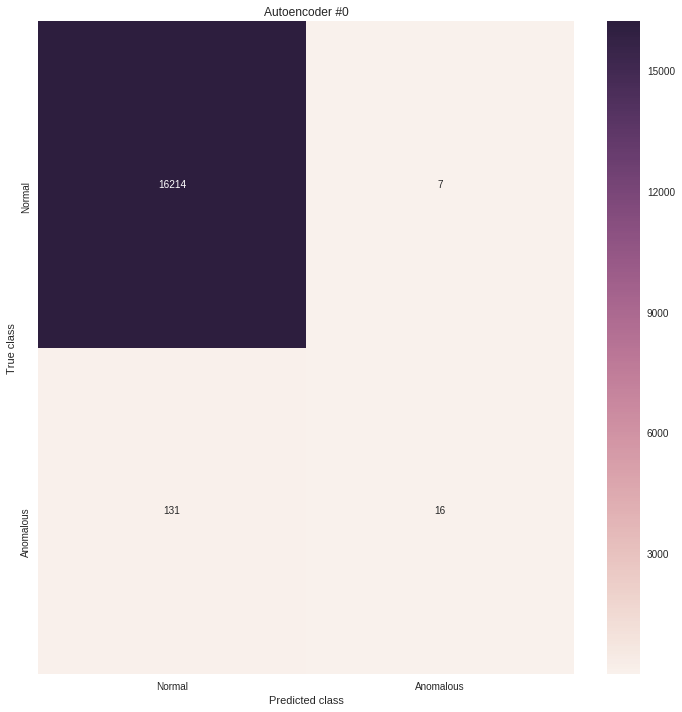

Threshold: 91.2929850625
Adjusted accuracy: 0.0612244897959


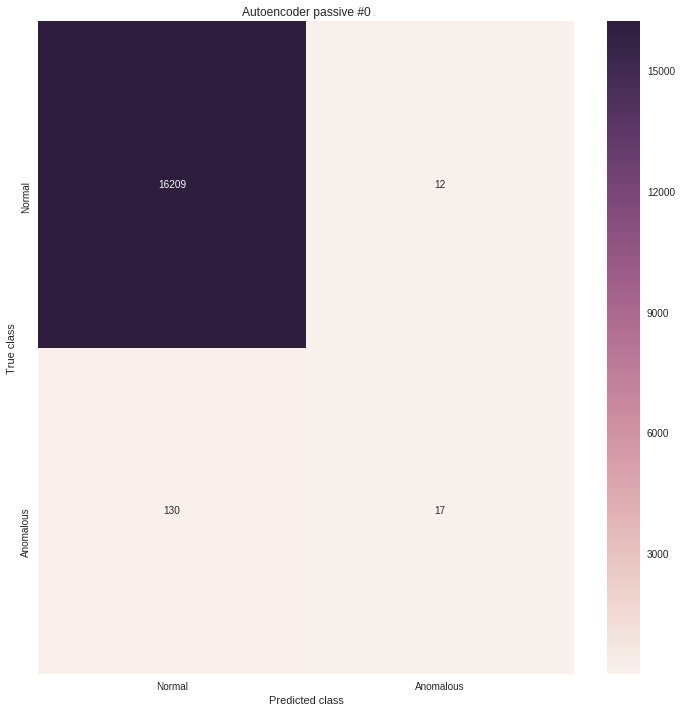

Threshold: 88.8139047004
Adjusted accuracy: 0.0340136054422


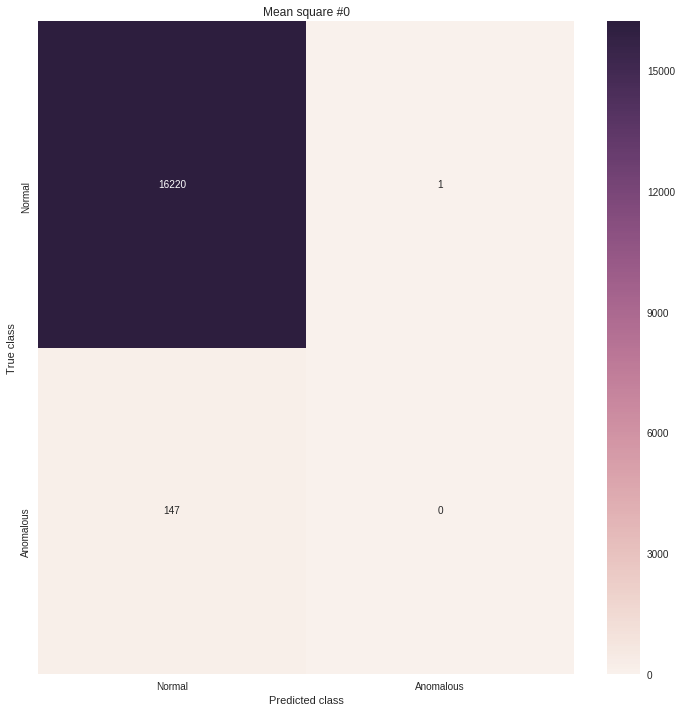

 11%|█         | 1/9 [00:02<00:19,  2.48s/it]

Threshold: 3178.36384431
Adjusted accuracy: -0.00680272108843
FOLD 1


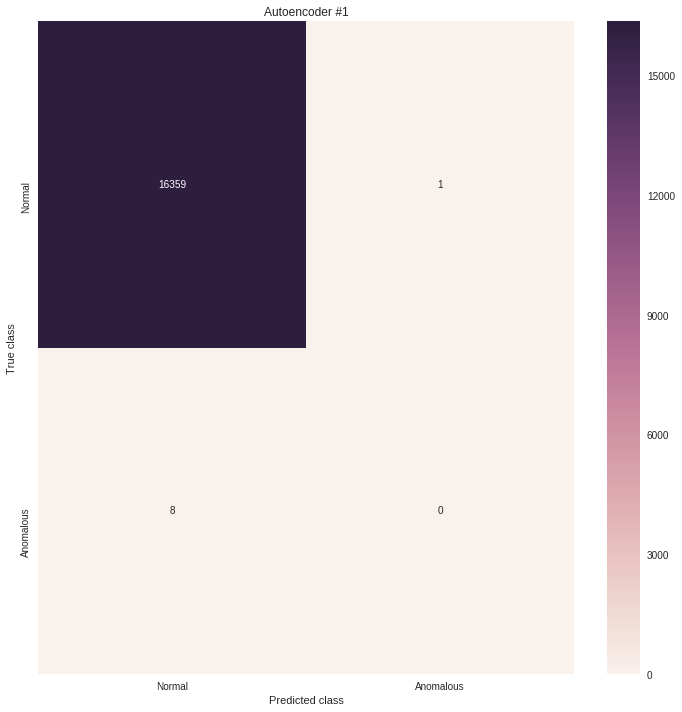

Threshold: 171.285120375
Adjusted accuracy: -0.125


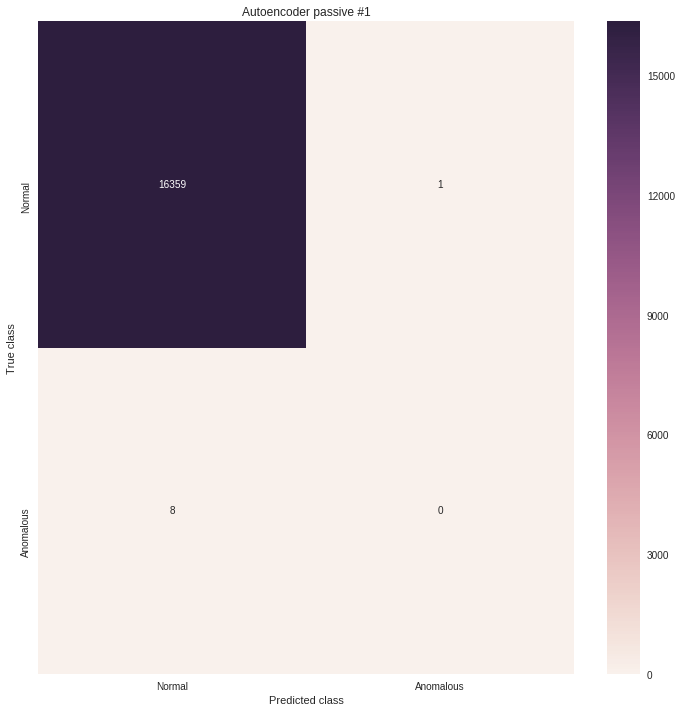

Threshold: 1257.78639947
Adjusted accuracy: -0.125


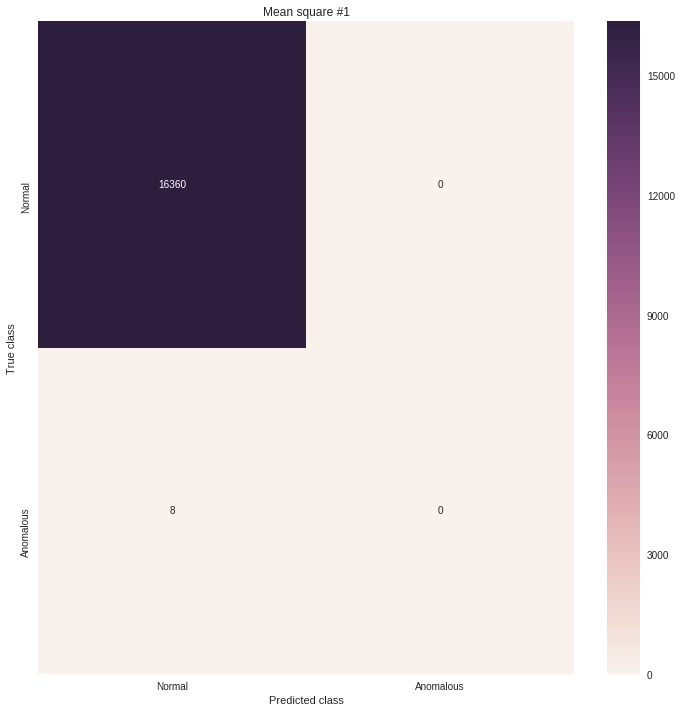

 22%|██▏       | 2/9 [00:05<00:17,  2.53s/it]

Threshold: 28893.797563
Adjusted accuracy: 0.0
FOLD 2


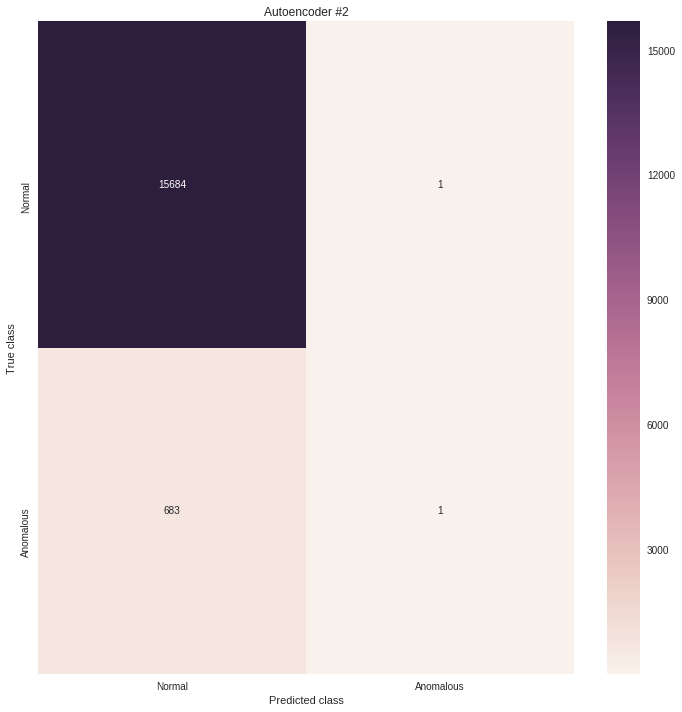

Threshold: 437.856875589
Adjusted accuracy: 0.0


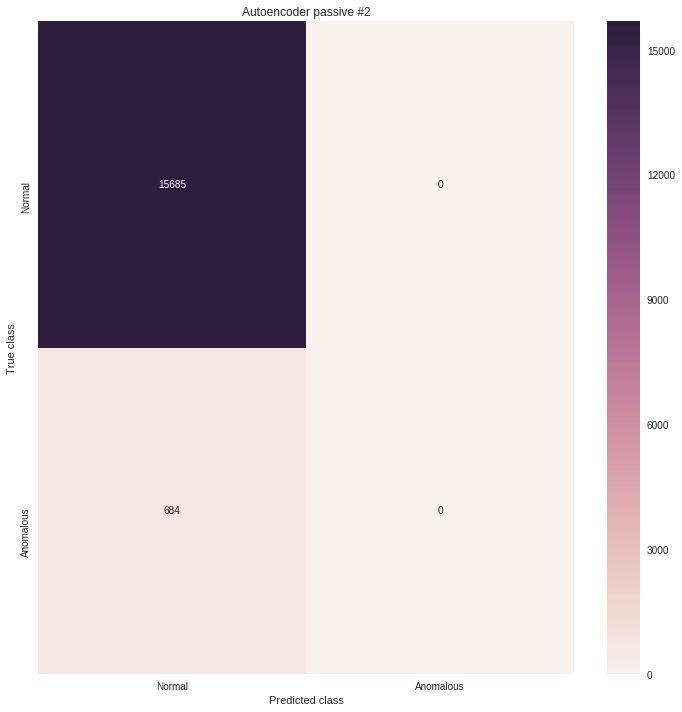

Threshold: 1384.44104794
Adjusted accuracy: 0.0


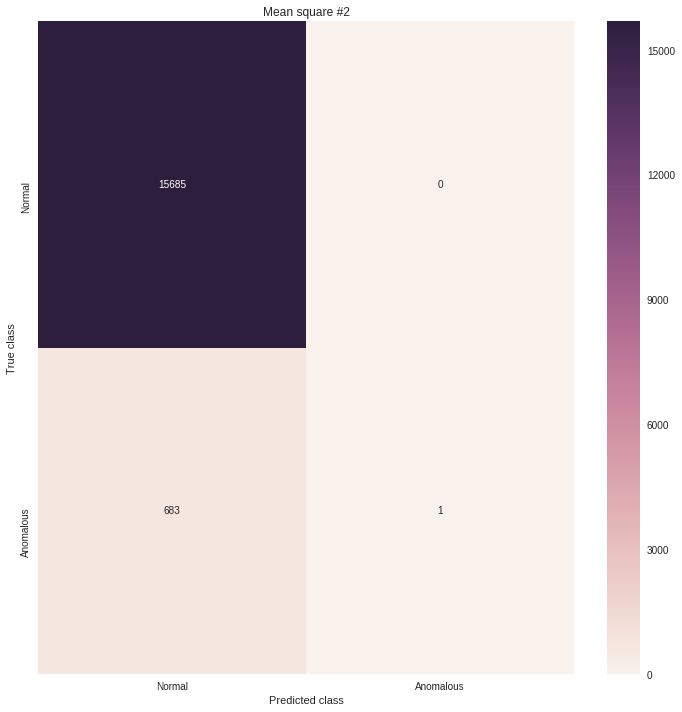

 33%|███▎      | 3/9 [00:06<00:13,  2.20s/it]

Threshold: 2071.64669031
Adjusted accuracy: 0.00146198830409
FOLD 3


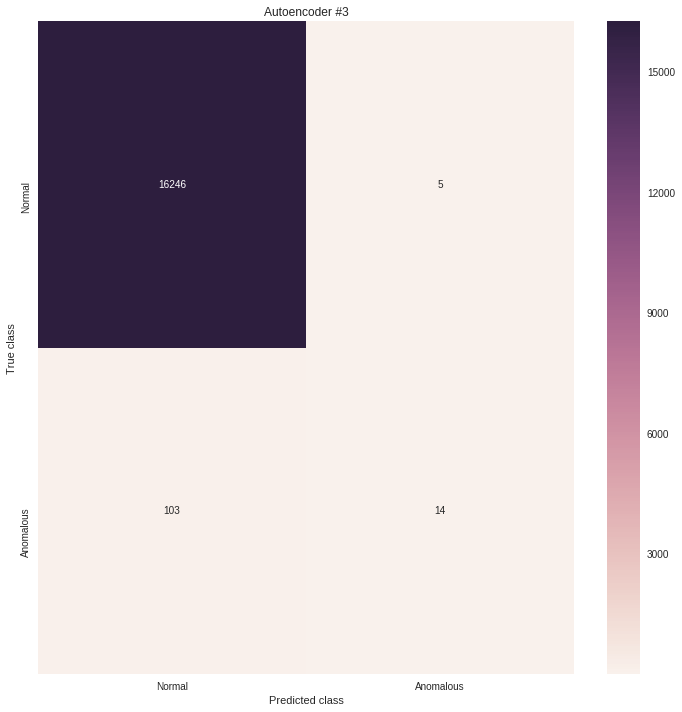

Threshold: 121.086251173
Adjusted accuracy: 0.0769230769231


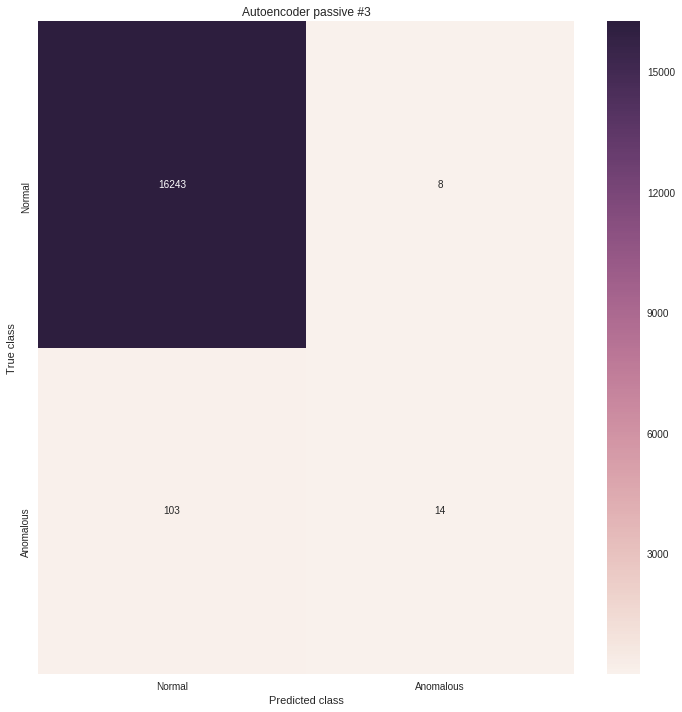

Threshold: 127.569031032
Adjusted accuracy: 0.0512820512821


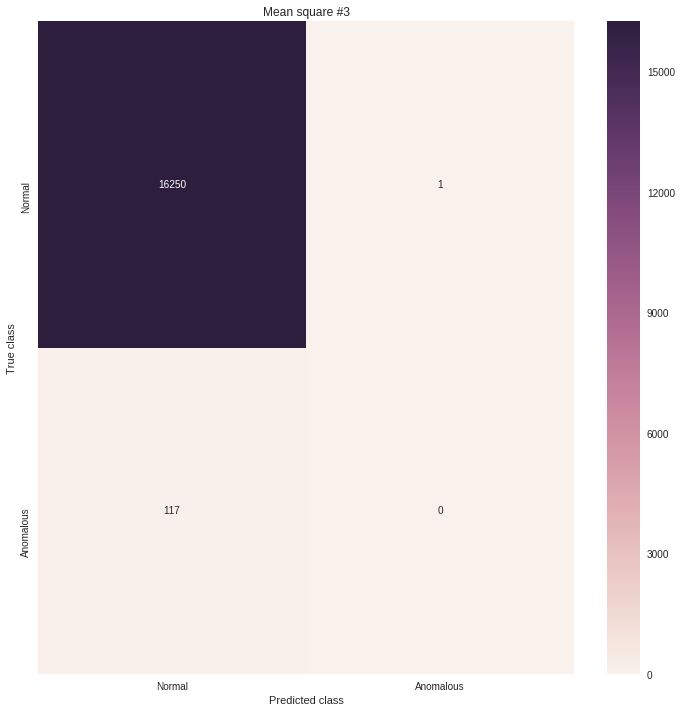

 44%|████▍     | 4/9 [00:07<00:09,  2.00s/it]

Threshold: 1220.83291602
Adjusted accuracy: -0.008547008547
FOLD 4


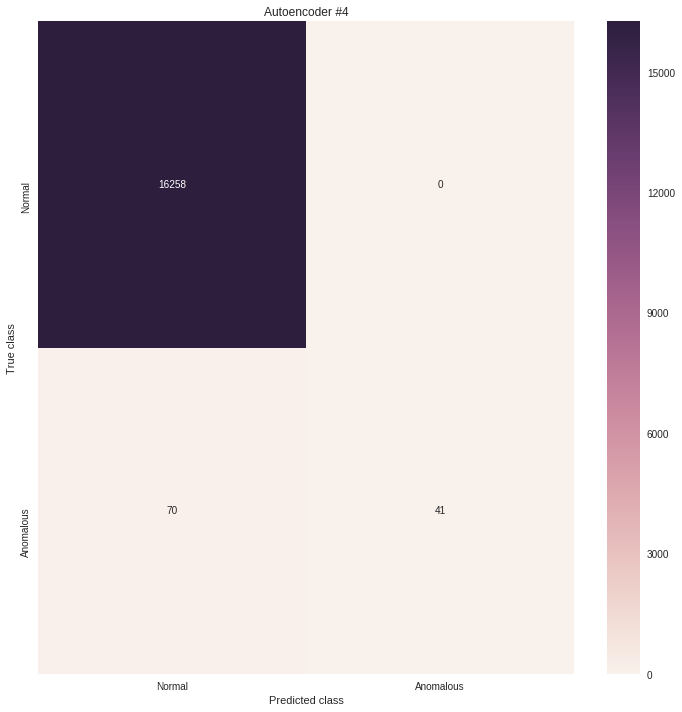

Threshold: 786.286300883
Adjusted accuracy: 0.369369369369


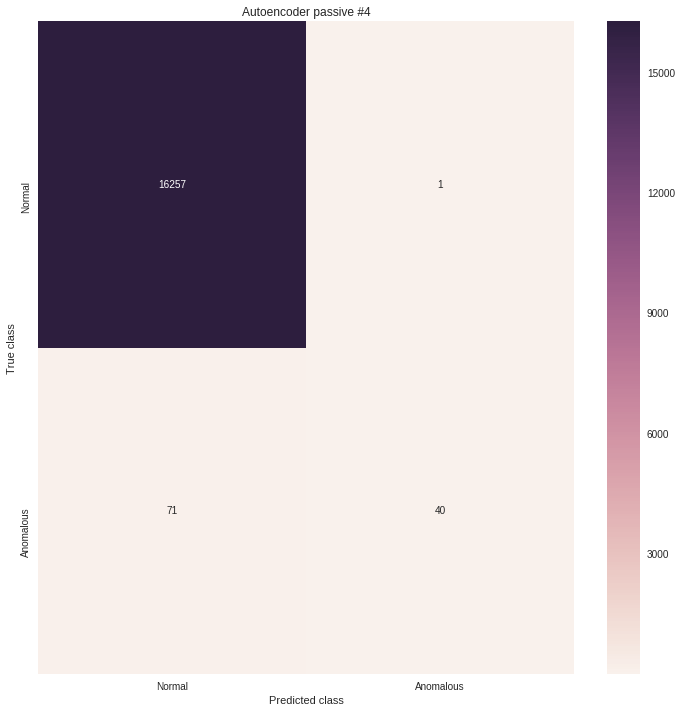

Threshold: 1648.53701743
Adjusted accuracy: 0.351351351351


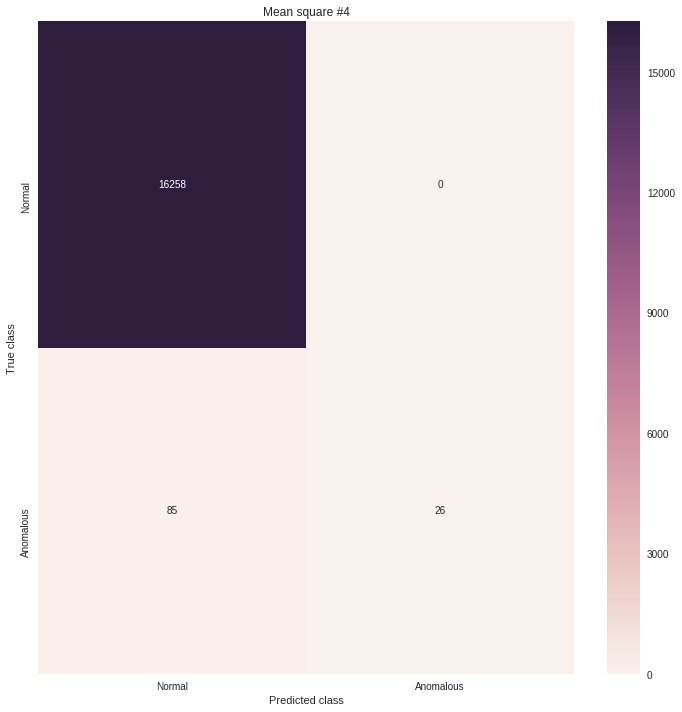

 56%|█████▌    | 5/9 [00:09<00:07,  1.90s/it]

Threshold: 91090.3807192
Adjusted accuracy: 0.234234234234
FOLD 5


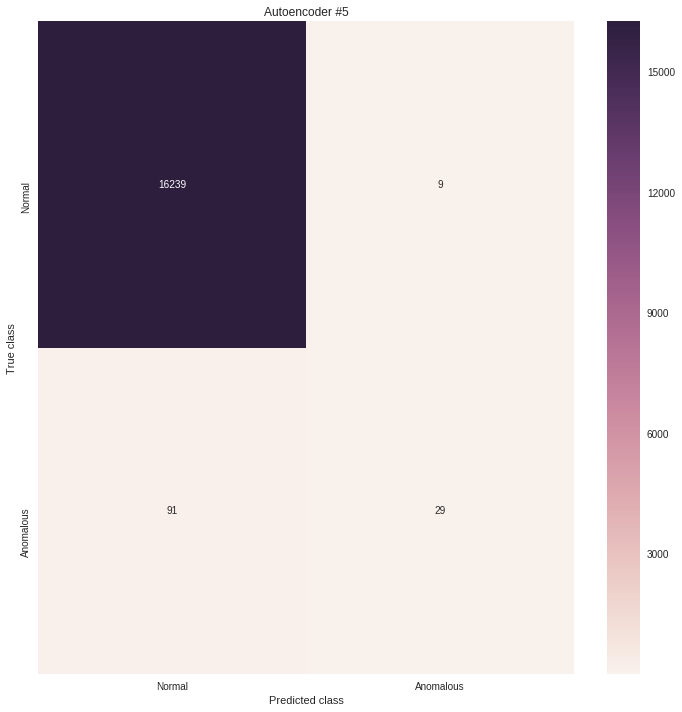

Threshold: 142.411077886
Adjusted accuracy: 0.166666666667


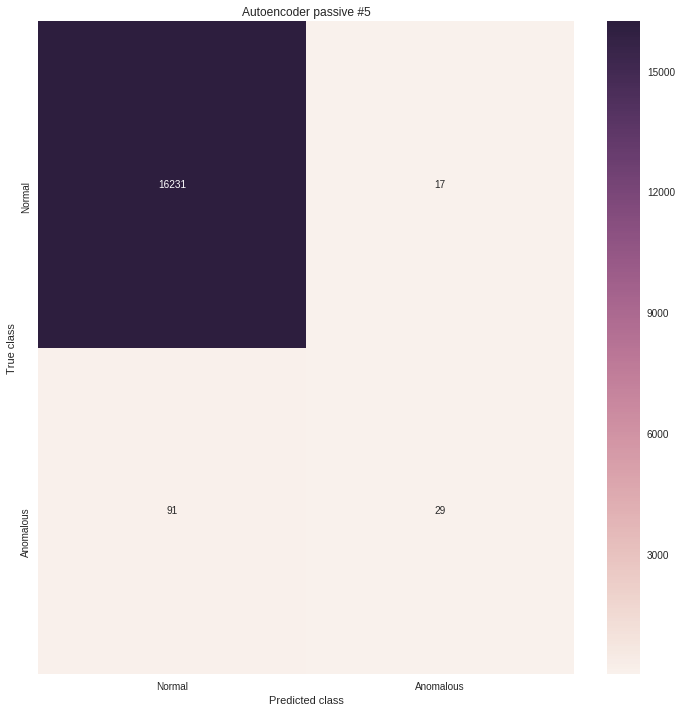

Threshold: 154.422770969
Adjusted accuracy: 0.1


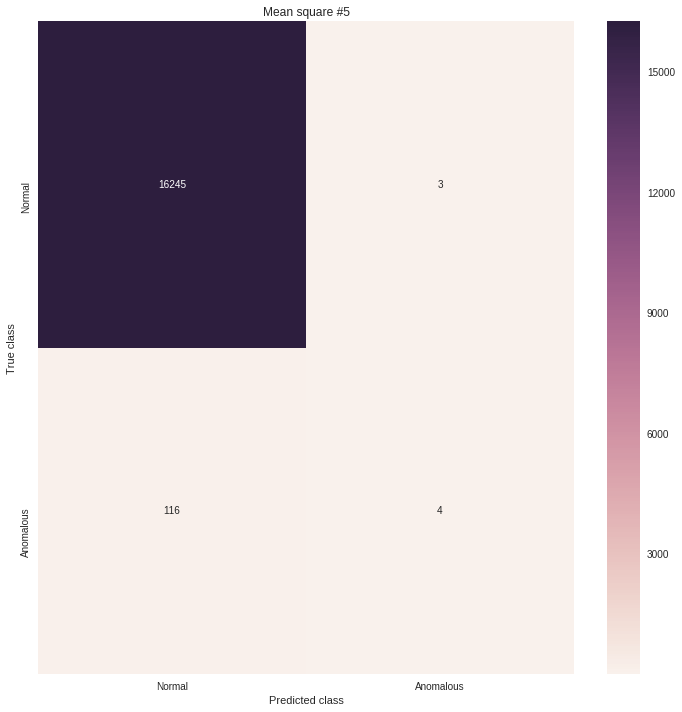

 67%|██████▋   | 6/9 [00:11<00:05,  1.85s/it]

Threshold: 884.438960434
Adjusted accuracy: 0.00833333333333
FOLD 6


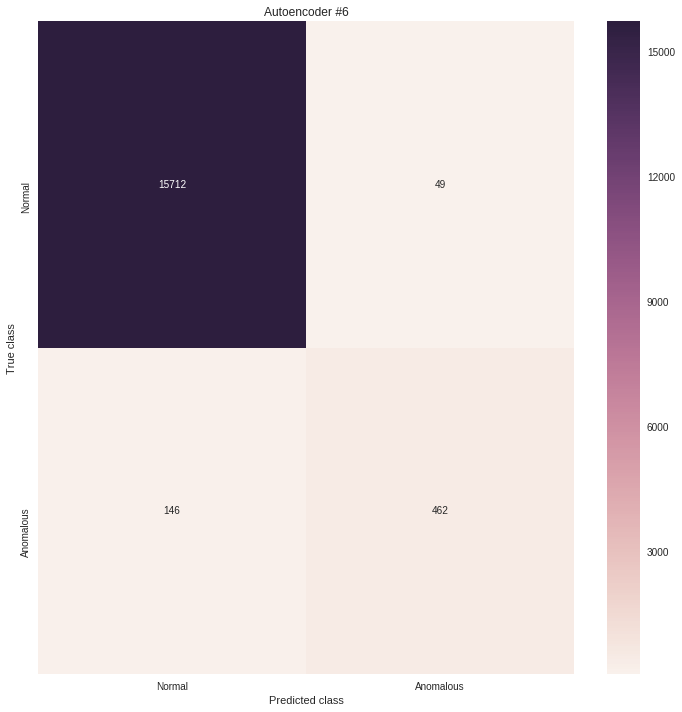

Threshold: 44.7477878591
Adjusted accuracy: 0.679276315789


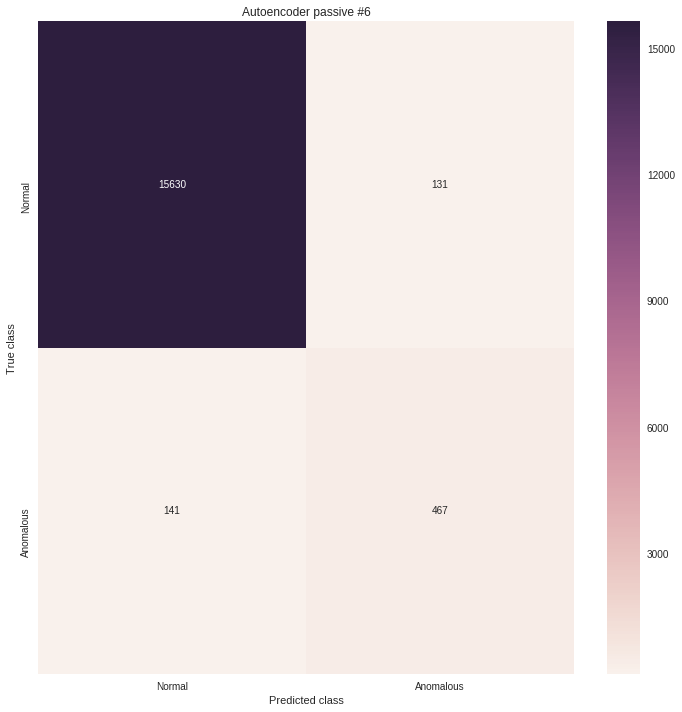

Threshold: 37.306917111
Adjusted accuracy: 0.552631578947


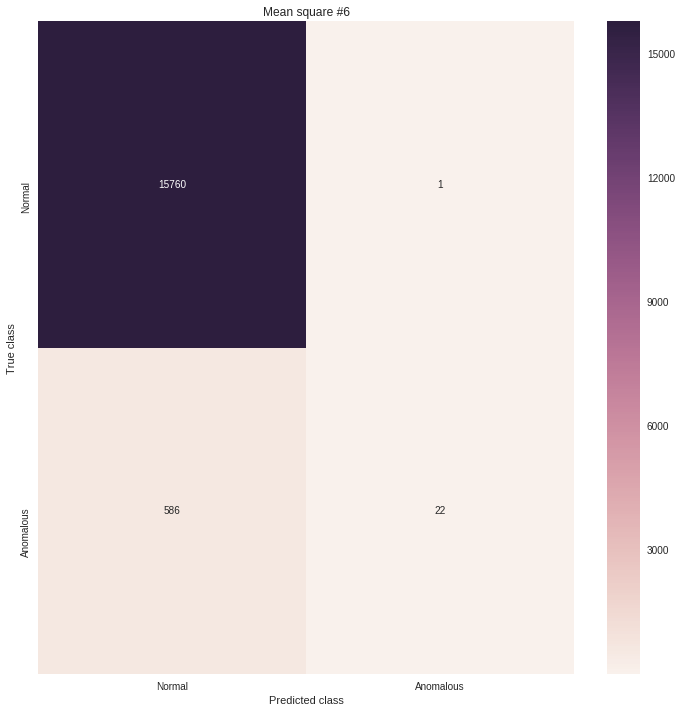

 78%|███████▊  | 7/9 [00:12<00:03,  1.80s/it]

Threshold: 2838.99295959
Adjusted accuracy: 0.0345394736842
FOLD 7


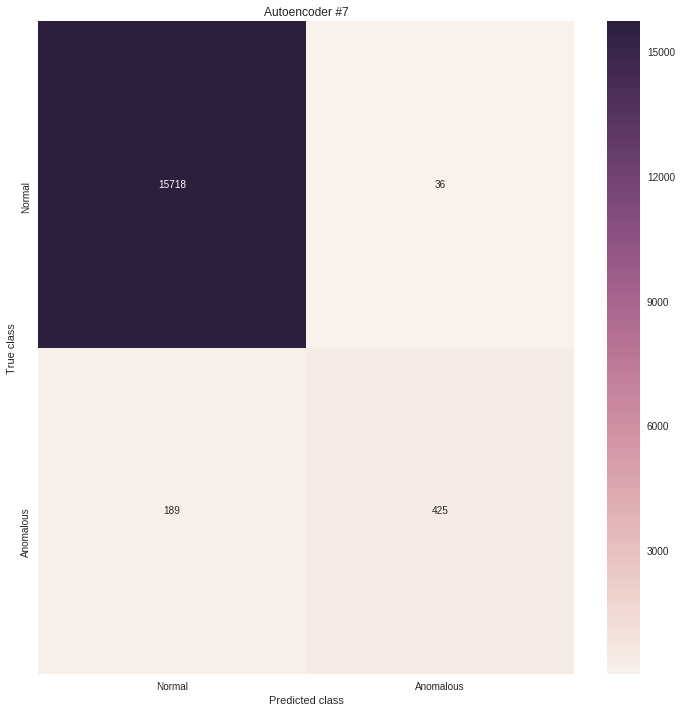

Threshold: 262.5341477
Adjusted accuracy: 0.633550488599


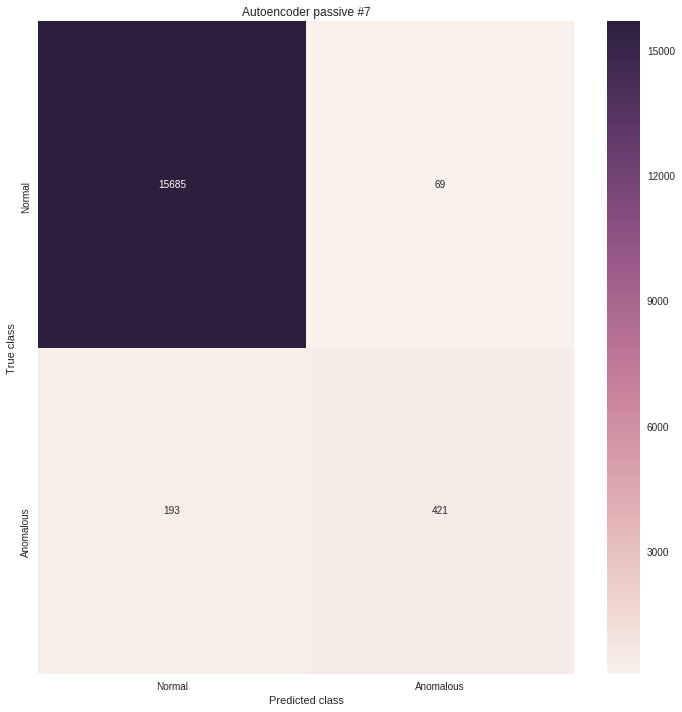

Threshold: 332.718554495
Adjusted accuracy: 0.57328990228


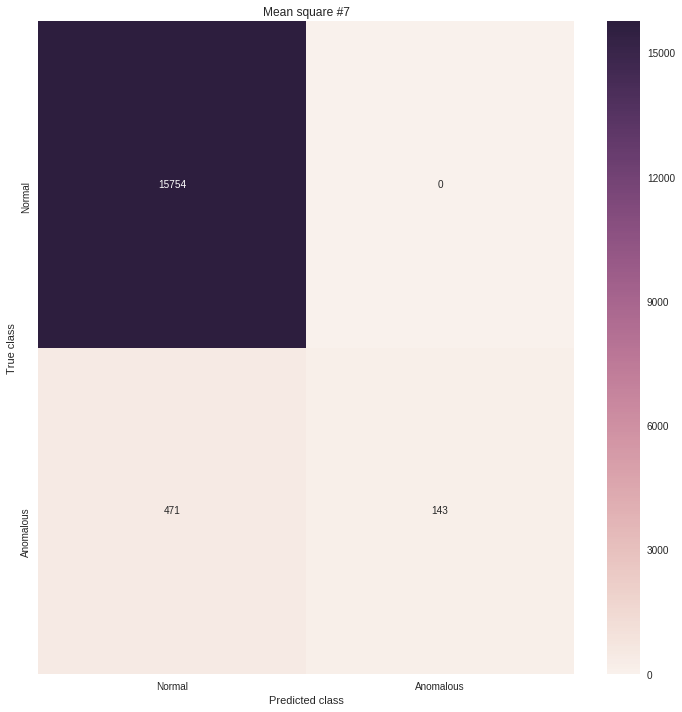

 89%|████████▉ | 8/9 [00:14<00:01,  1.77s/it]

Threshold: 31221.849503
Adjusted accuracy: 0.232899022801
FOLD 8


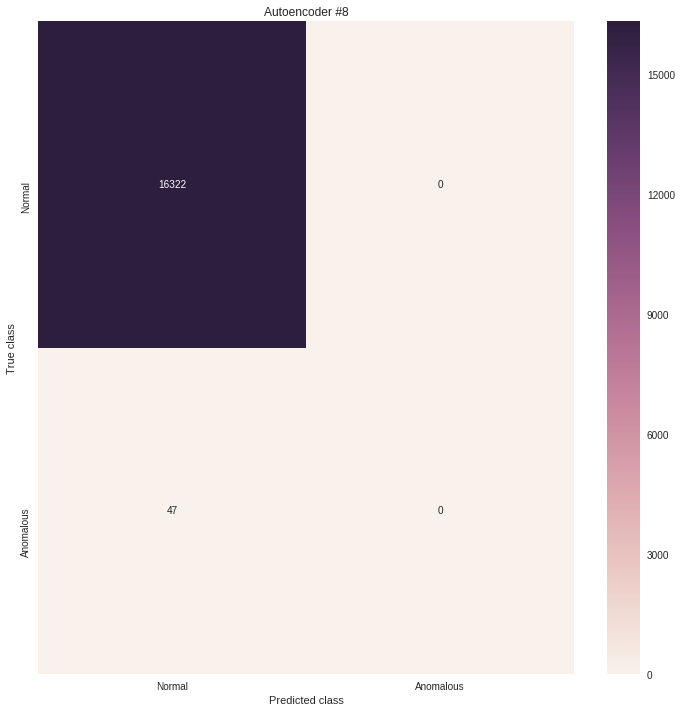

Threshold: 7277329071.92
Adjusted accuracy: 0.0


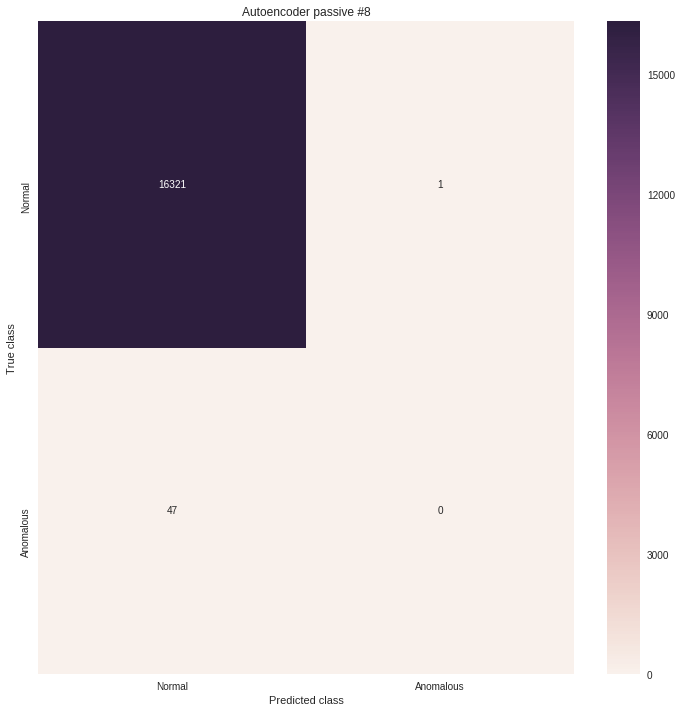

Threshold: 709406387.761
Adjusted accuracy: -0.0212765957447


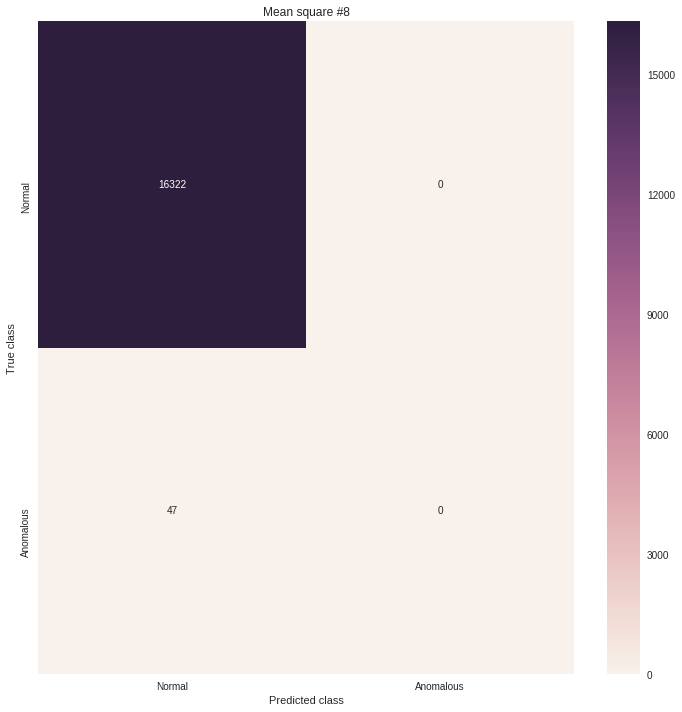

100%|██████████| 9/9 [00:15<00:00,  1.75s/it]

Threshold: 621676488791.0
Adjusted accuracy: 0.0


In [28]:
plt.rcParams['figure.figsize'] = [10, 5]
for i in tqdm(range(9)):
    ae_labels = [1 if e > ae_cutoffs[i] else 0 for e in ae_scores[i]]
    ae_base_labels = [1 if e > ae_base_cutoffs[i] else 0 for e in ae_base_scores[i]]
    ms_labels = [1 if e > ms_cutoffs[i] else 0 for e in ms_scores[i]]
    
    print("FOLD", i)
    ae_tr = conf_matrix(ae_scores[i], true_labels[i], ae_cutoffs[i], "Autoencoder #" + str(i))
    ae_base_tr = conf_matrix(ae_base_scores[i], true_labels[i], ae_base_cutoffs[i], "Autoencoder passive #" + str(i))
    ms_tr = conf_matrix(ms_scores[i], true_labels[i], ms_cutoffs[i], "Mean square #" + str(i))
    
    ae_thresholds.append(ae_tr)
    ae_base_thresholds.append(ae_base_tr)
    ms_thresholds.append(ms_tr)

In [29]:
ae_thresholds

[91.292985062497863,
 171.28512037501102,
 437.85687558942669,
 121.08625117296884,
 786.28630088283137,
 142.41107788644268,
 44.747787859129261,
 262.53414770047755,
 7277329071.9182415]

In [30]:
ae_base_thresholds

[88.813904700442976,
 1257.7863994721743,
 1384.4410479413434,
 127.56903103167429,
 1648.5370174275599,
 154.42277096856571,
 37.306917111035169,
 332.71855449463413,
 709406387.76065671]

(0, 1)

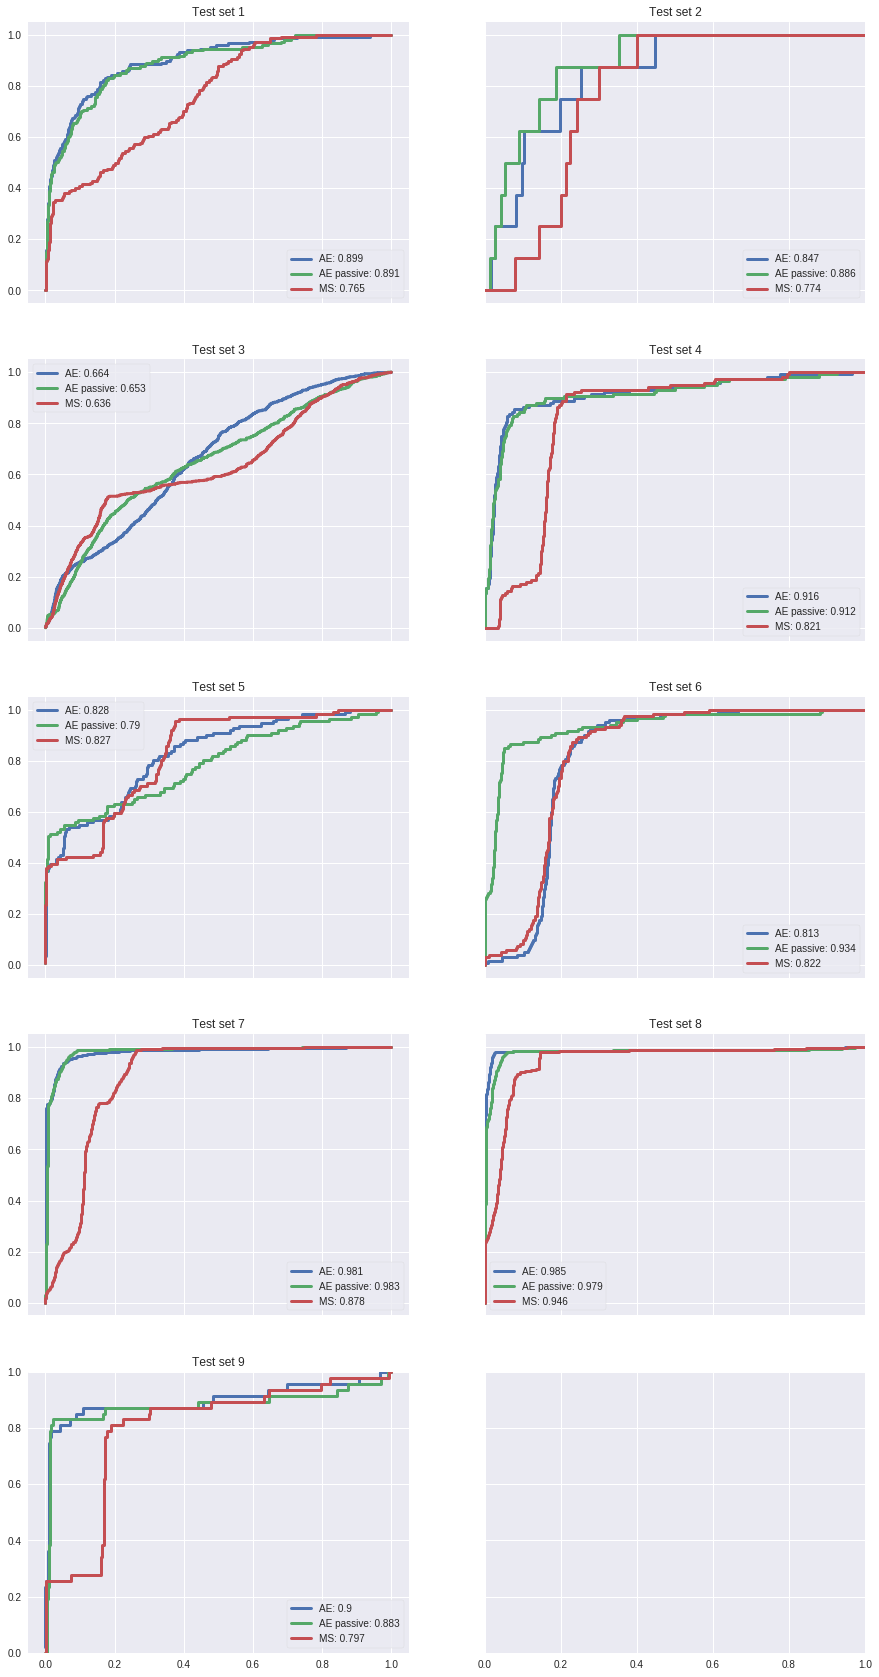

In [12]:
plt.rcParams['figure.figsize'] = [15, 30]

f, axes = plt.subplots(5, 2, sharex='col', sharey='row')
axes_list = list(chain(*axes))

for j in range(9):
    label = true_labels[j]
    scores = [ae_scores[j], ae_base_scores[j], ms_scores[j]]
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        ax = axes_list[j]
        ax.plot(fpr,
                 tpr,
                 linewidth=3,
                 label=("%s: %s" % (names[i], round(roc_auc, 3))))
        
        ax.legend(frameon=True)
        ax.set_title("Test set %s" % (j+1))

plt.ylim([0, 1])
plt.xlim([0, 1])

Good lumis: 16221
Bad lumis: 147
Ratio of bad lumis: 0.00898093841642


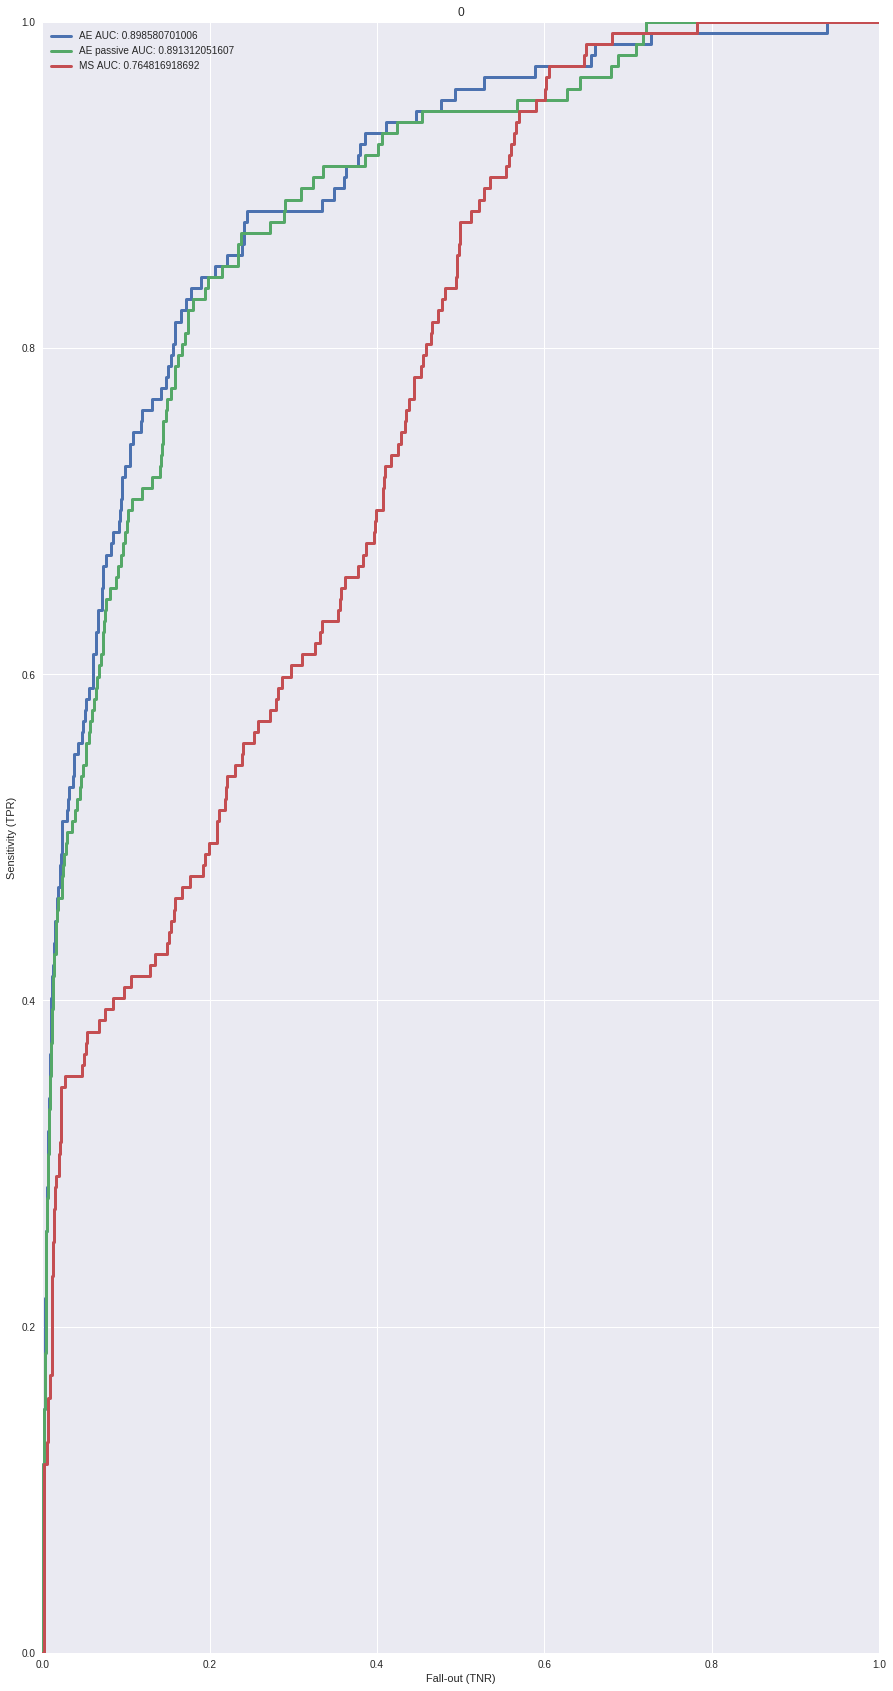

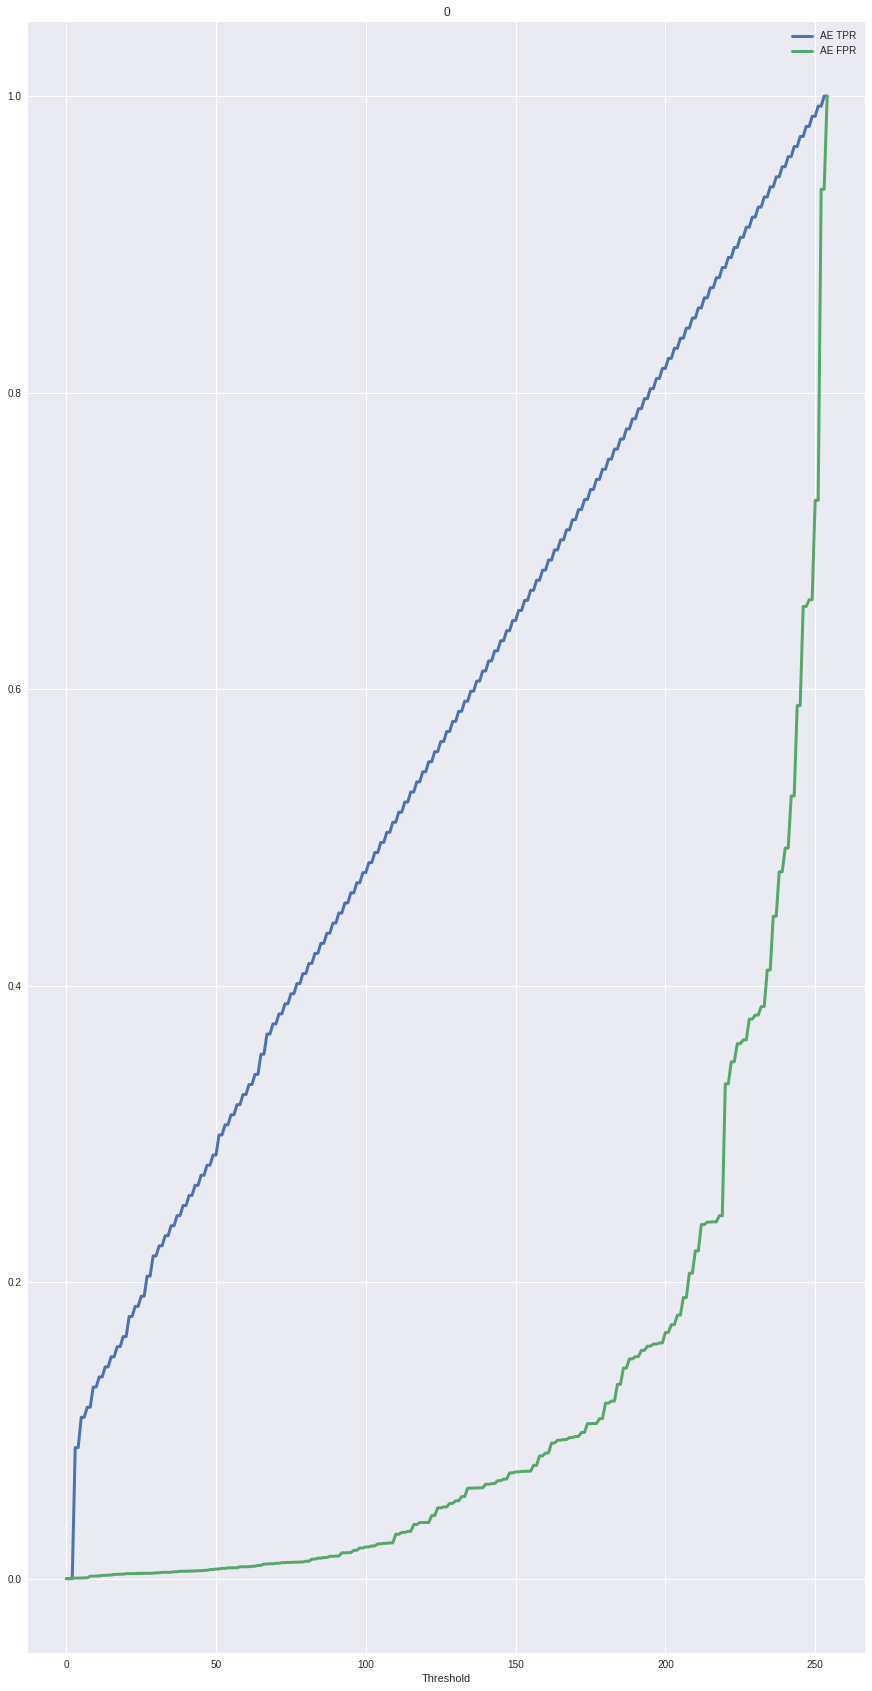

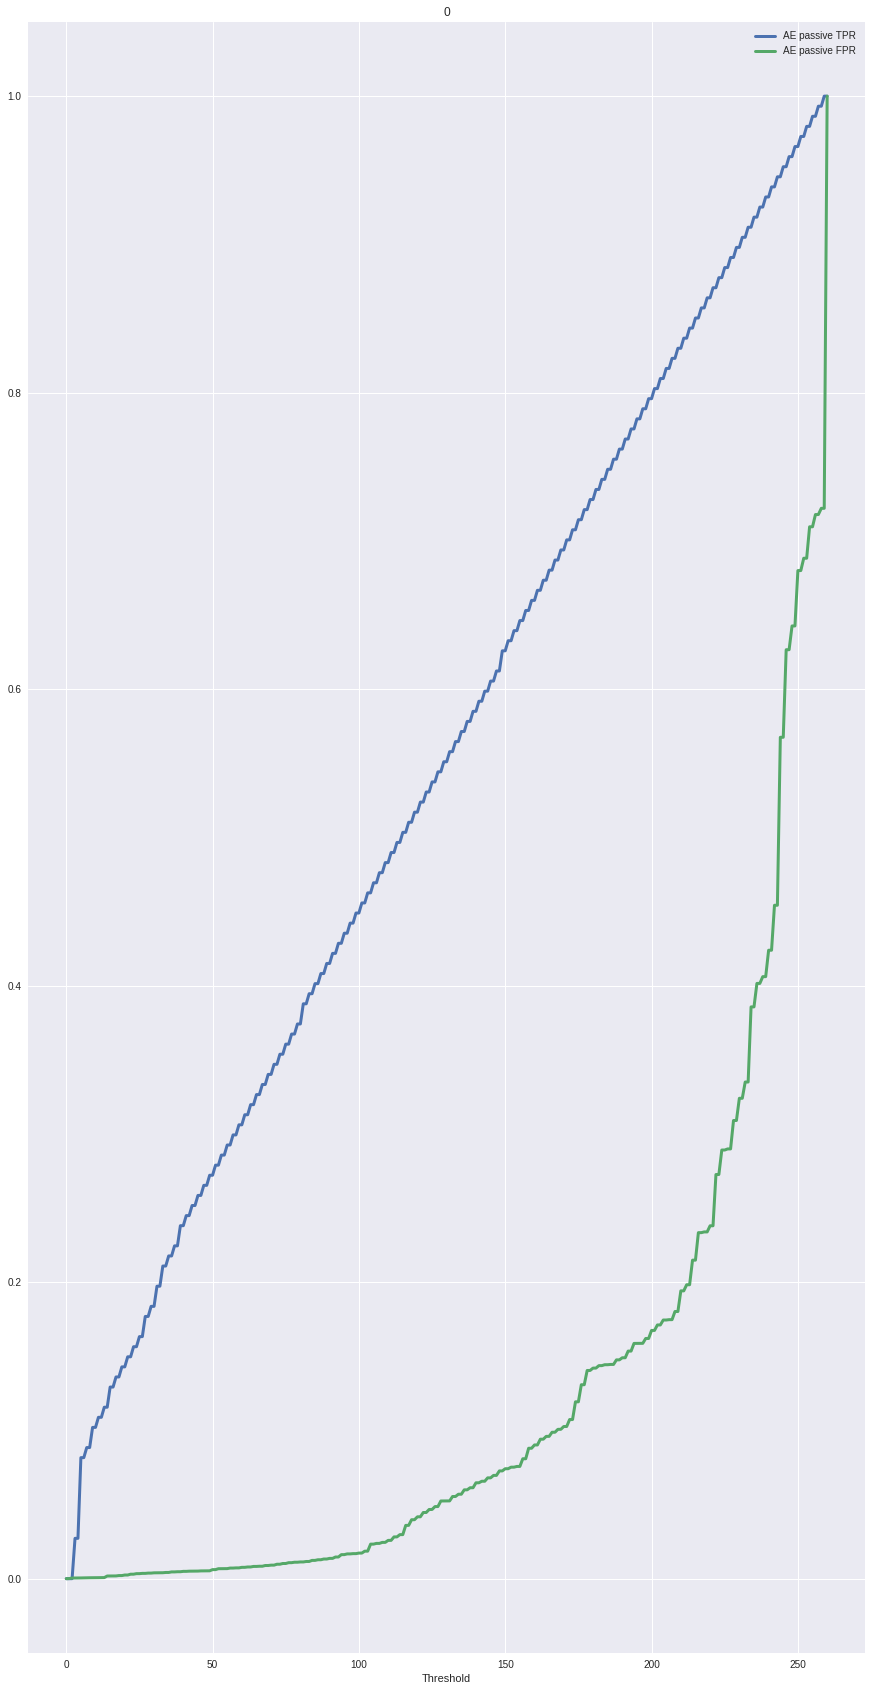

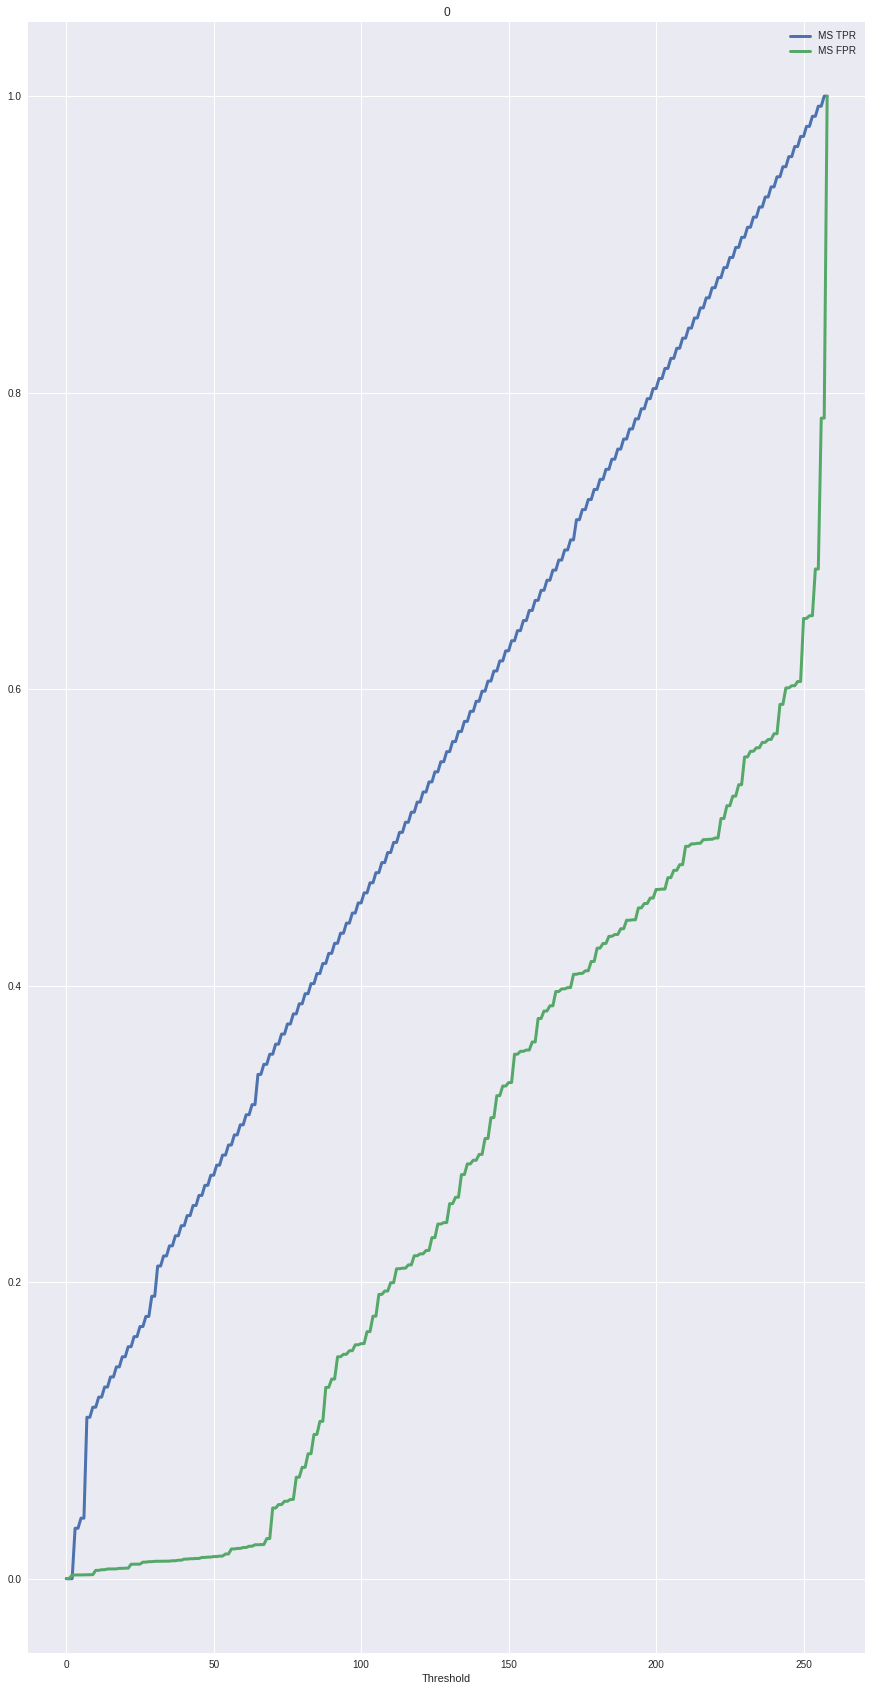

Good lumis: 16360
Bad lumis: 8
Ratio of bad lumis: 0.000488758553275


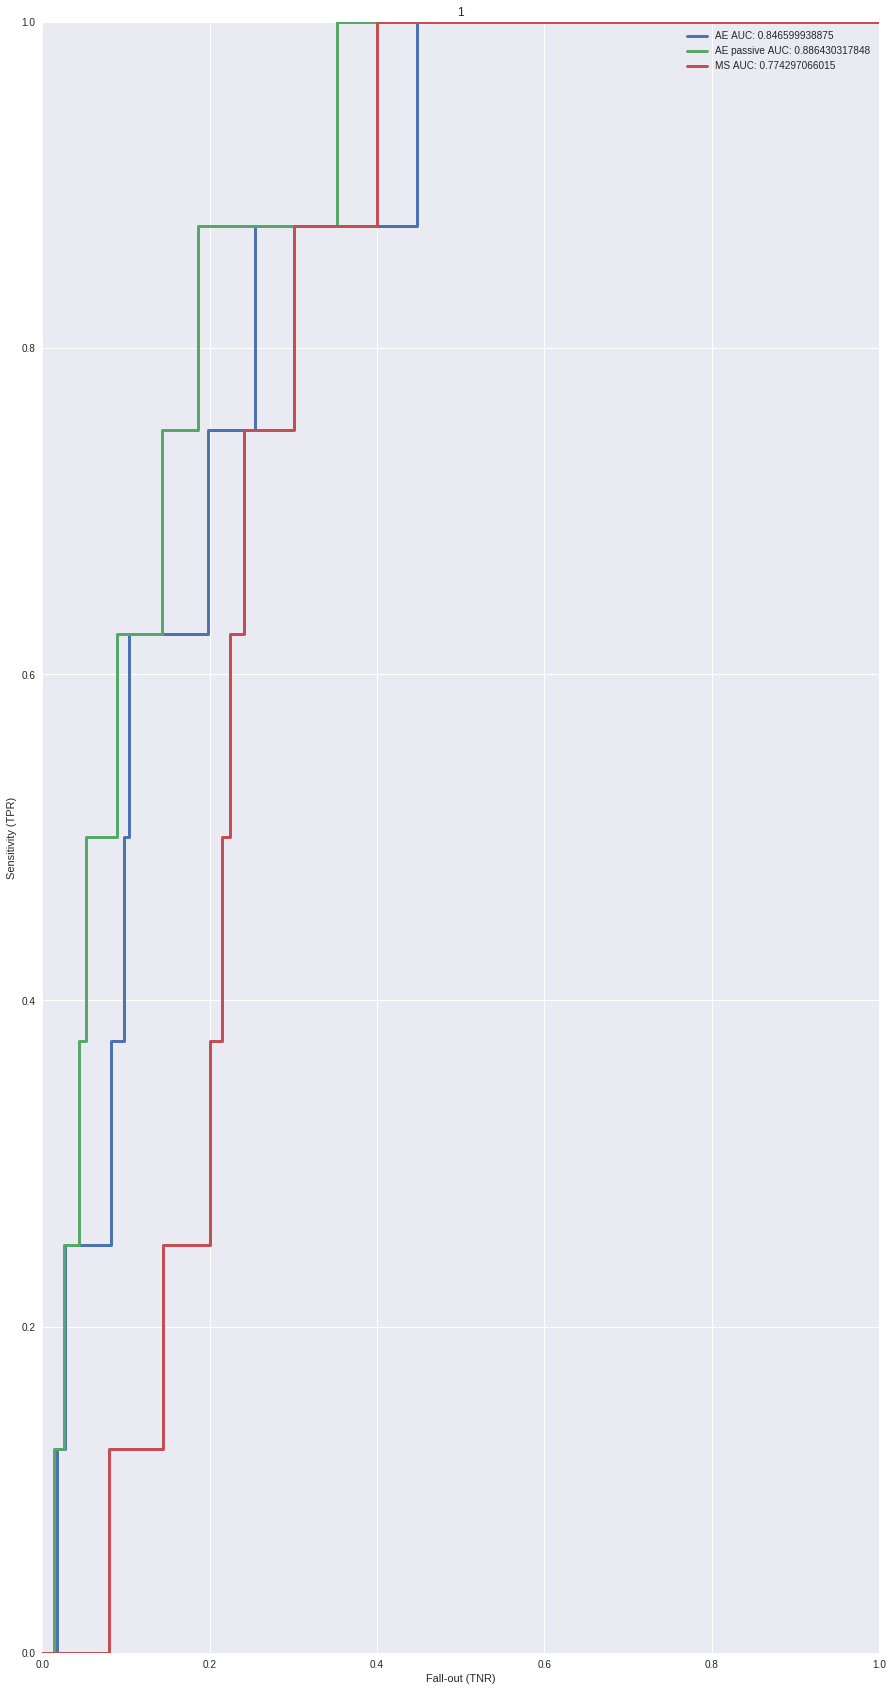

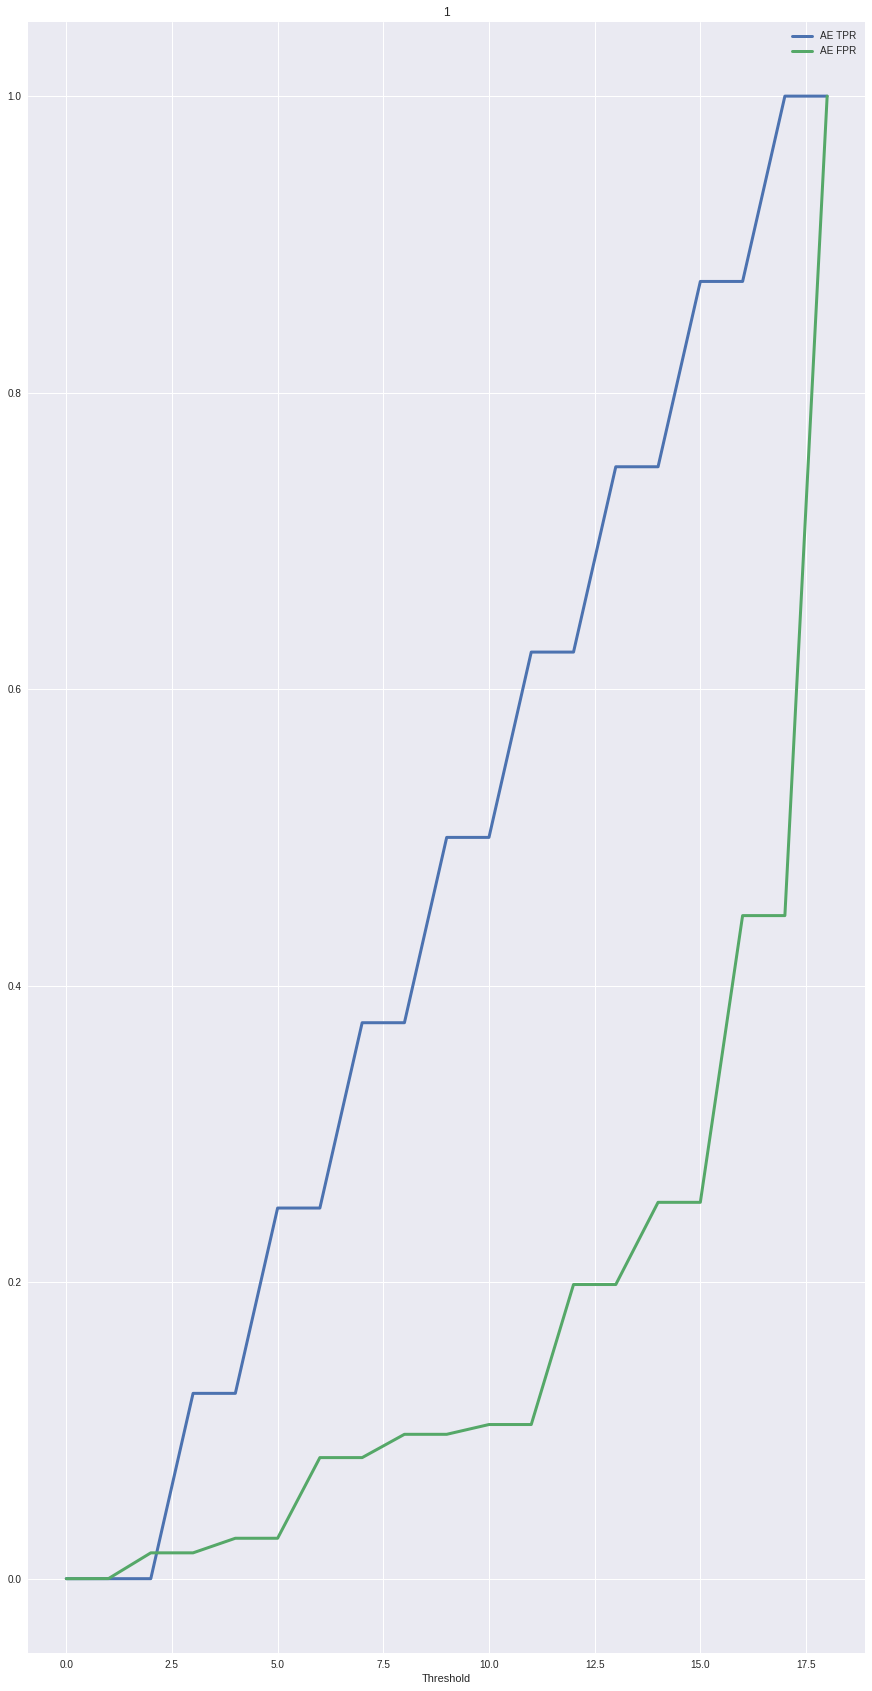

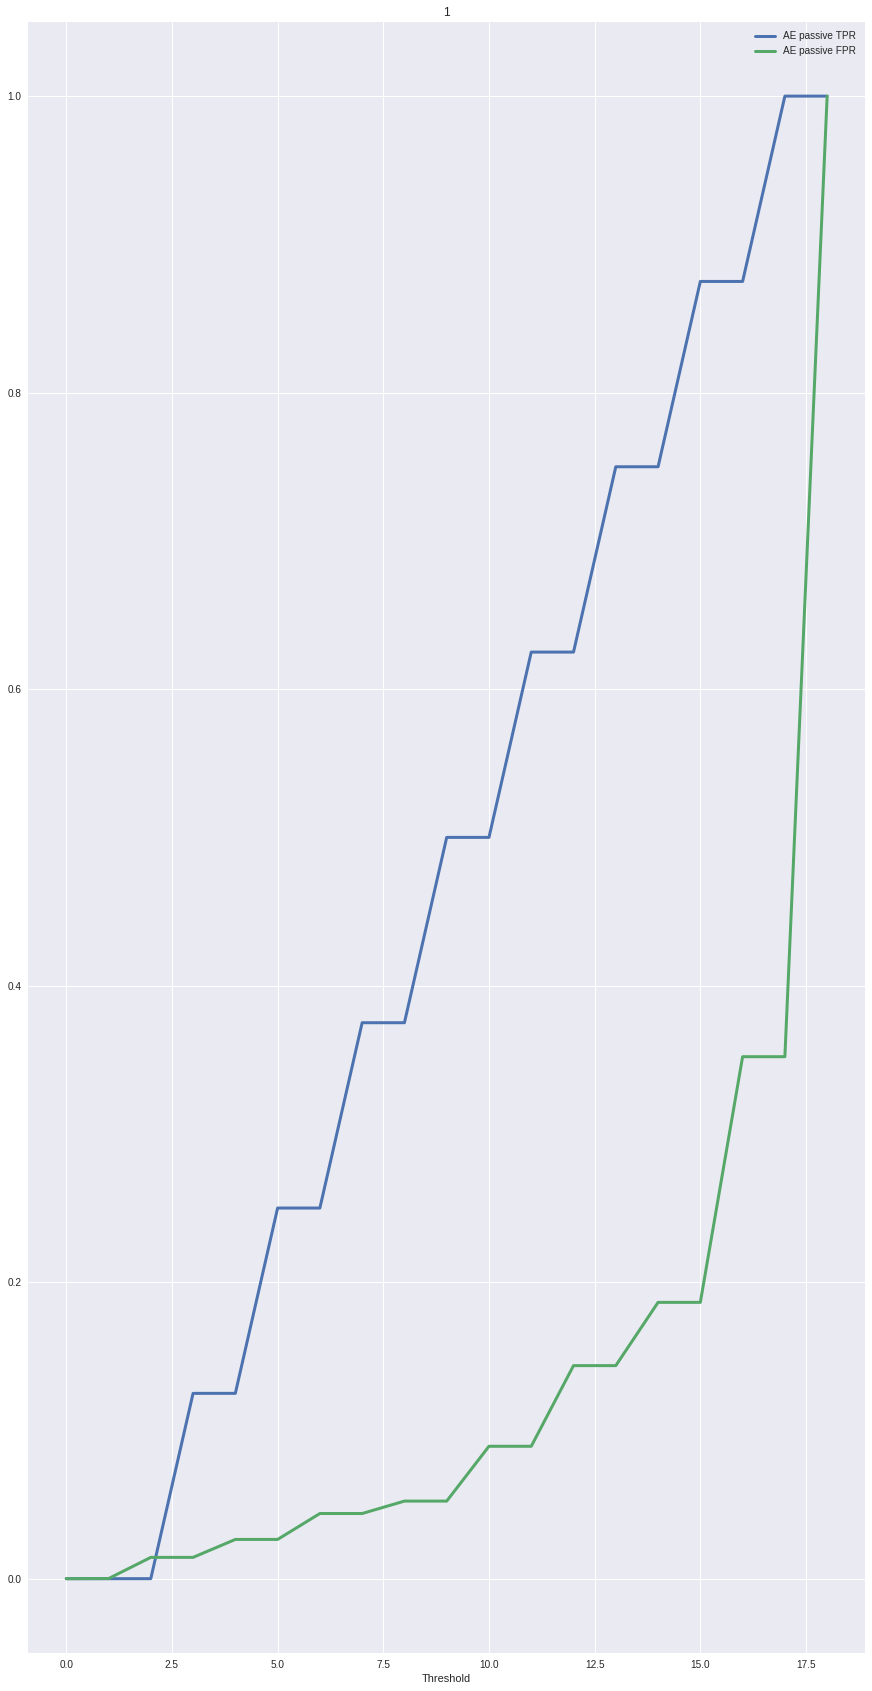

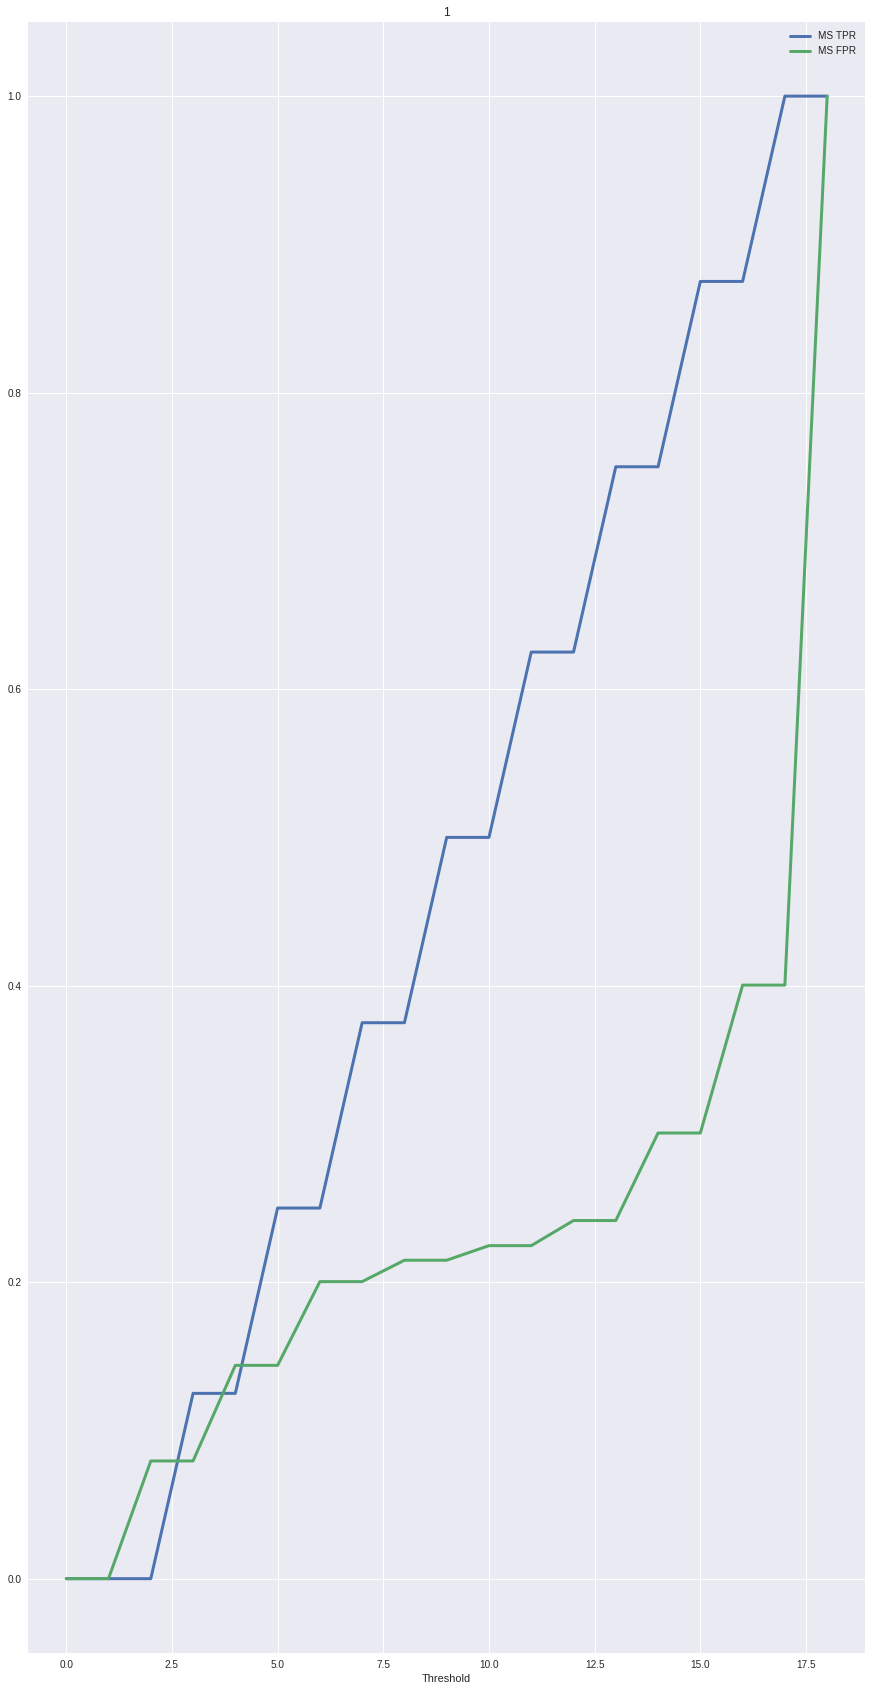

Good lumis: 15685
Bad lumis: 684
Ratio of bad lumis: 0.0417863033783


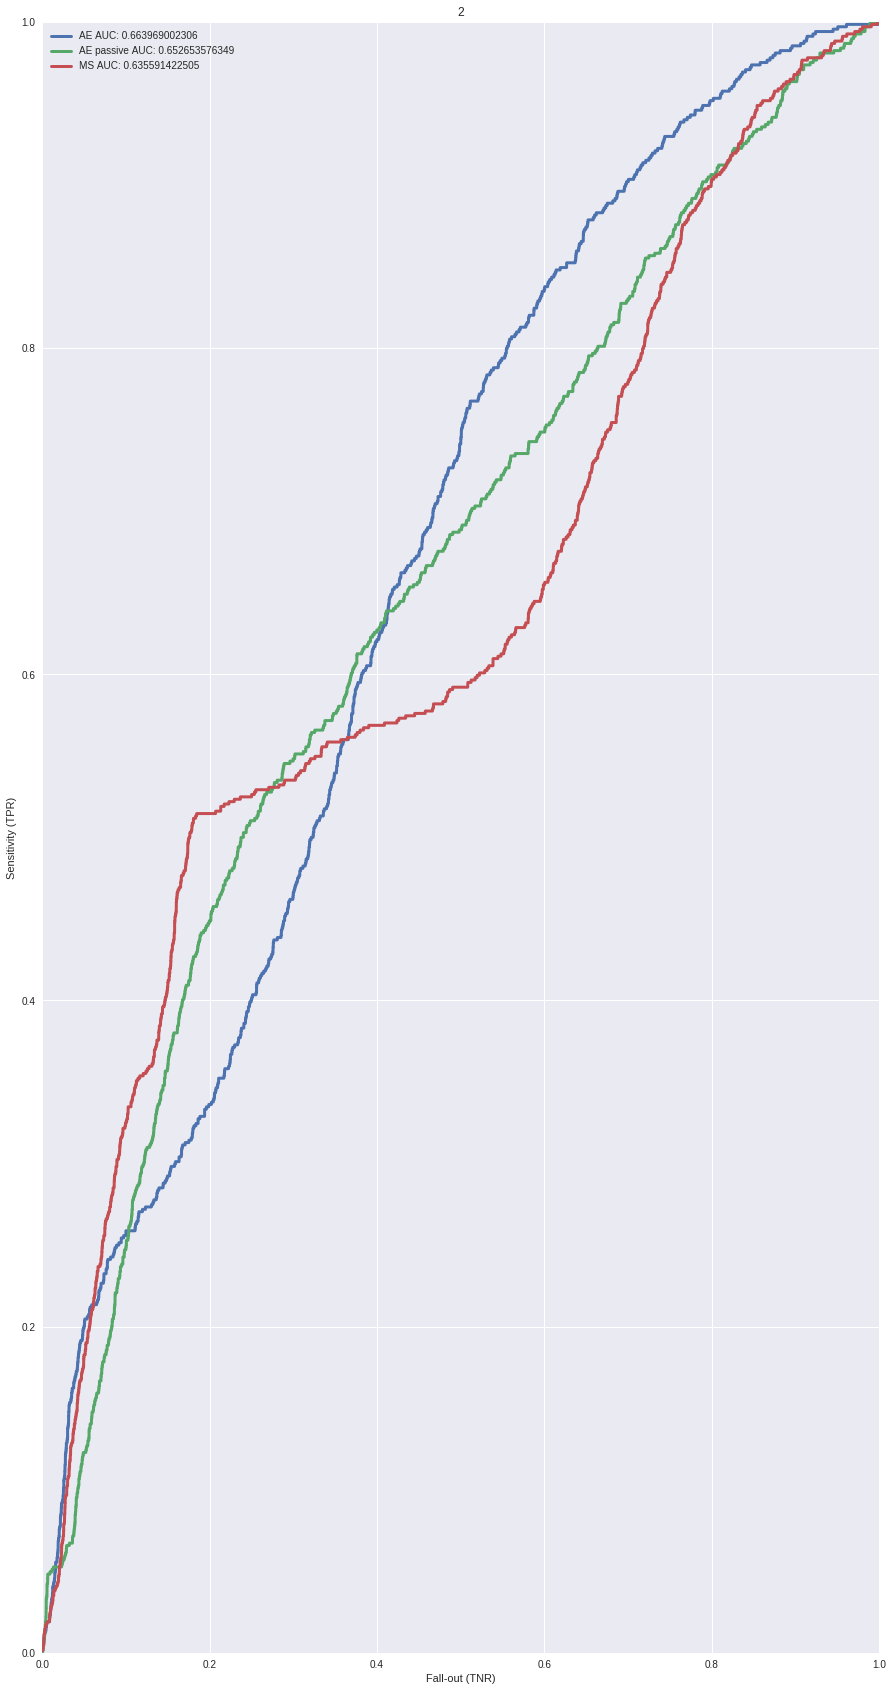

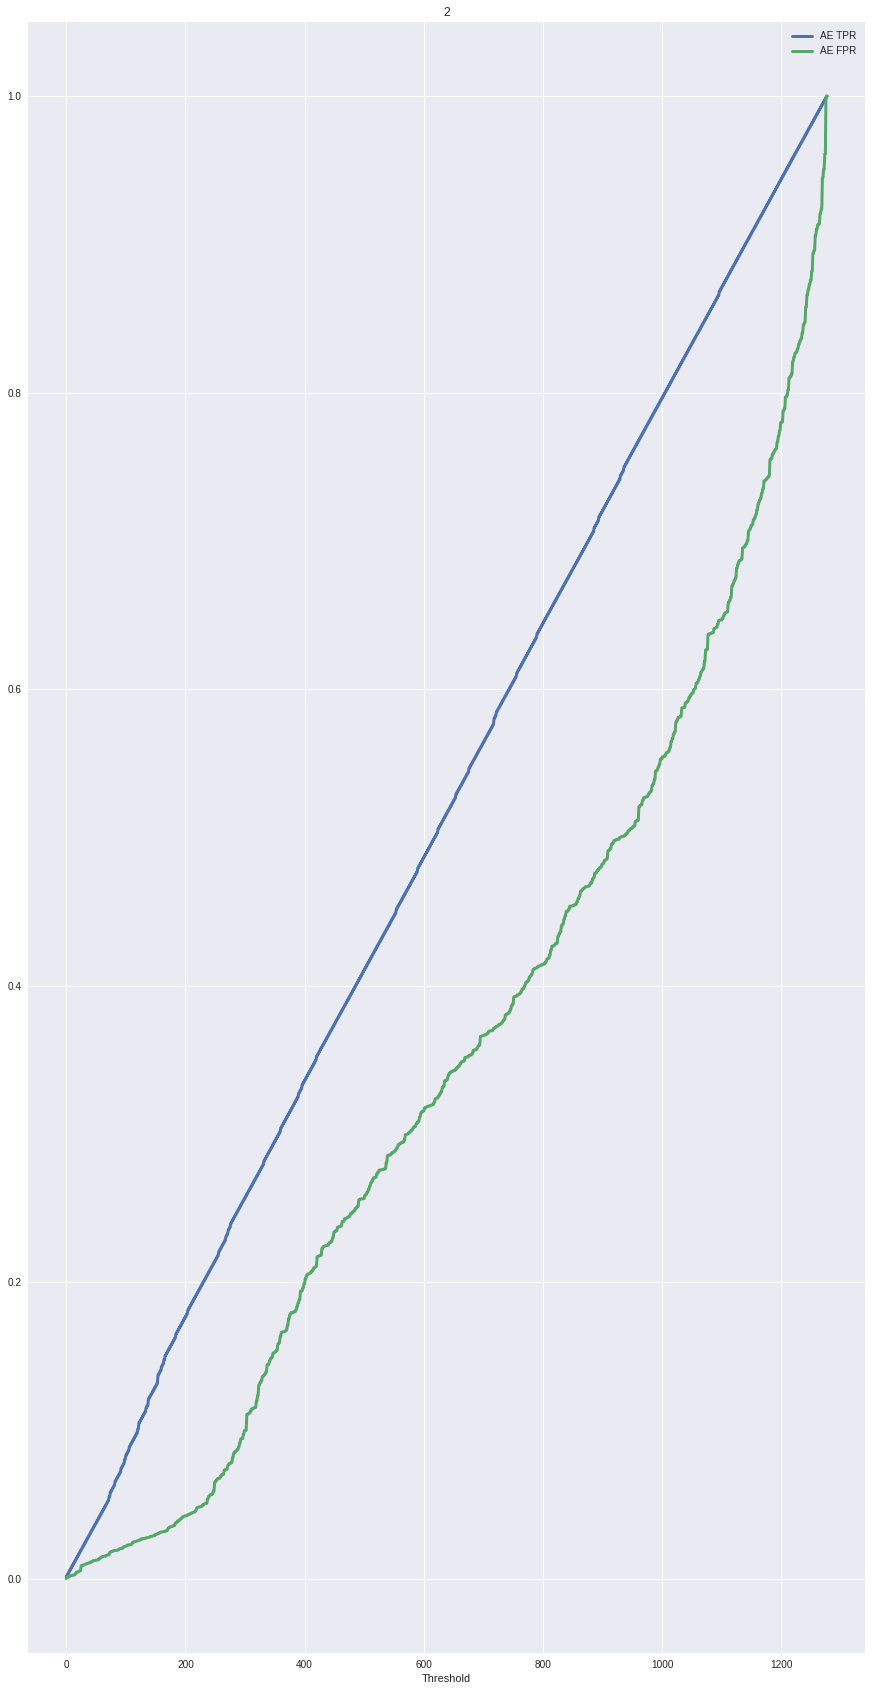

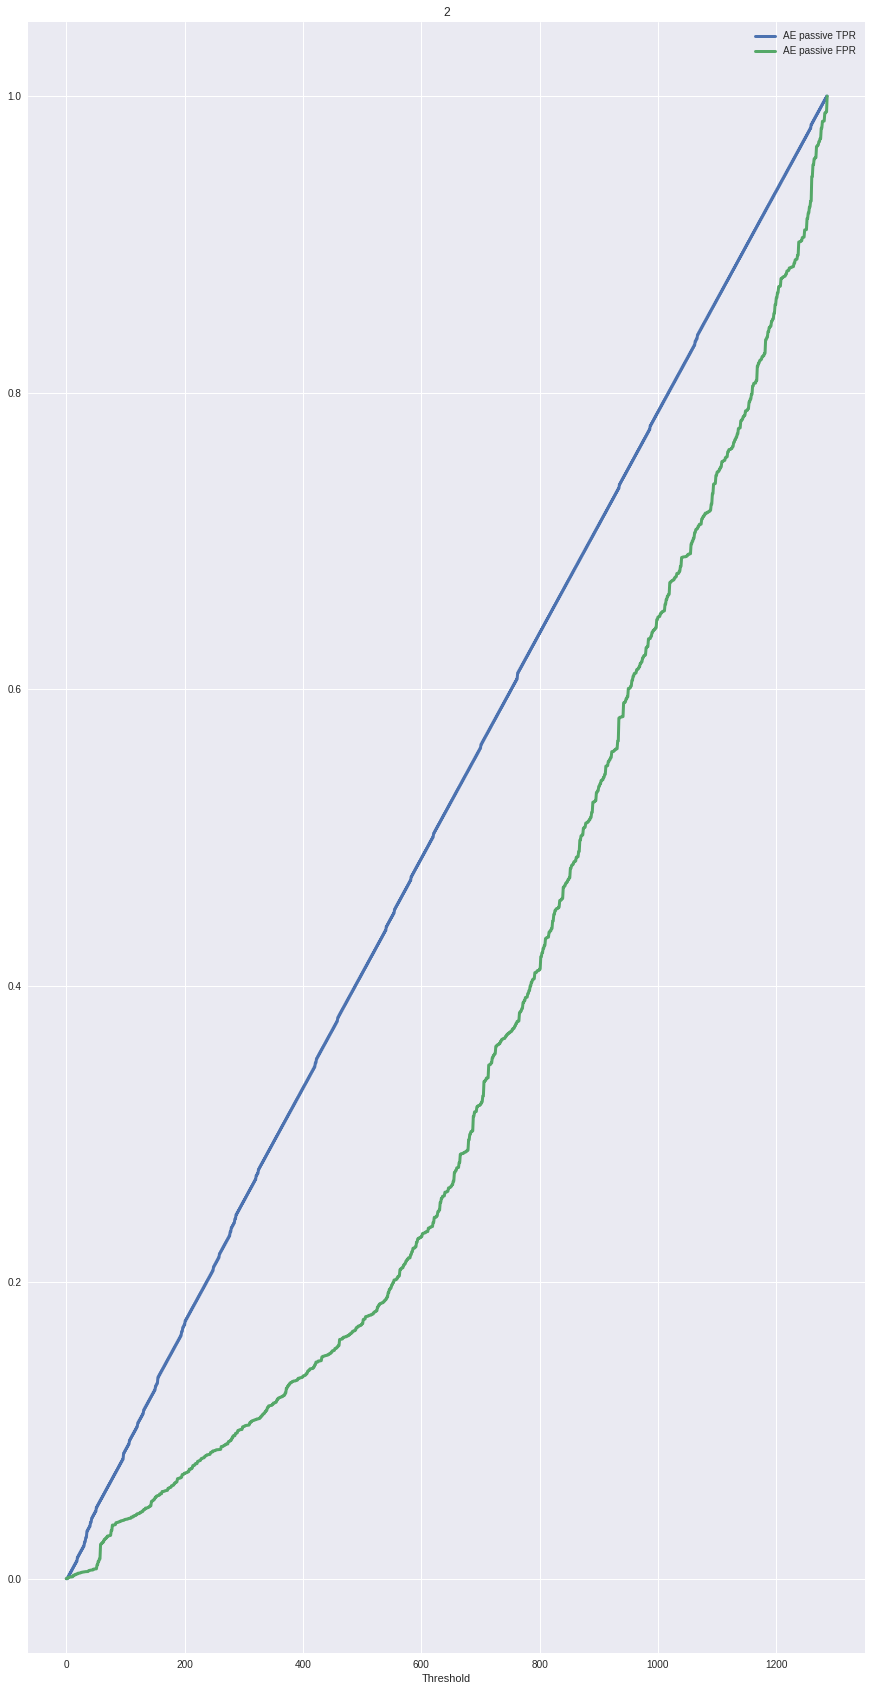

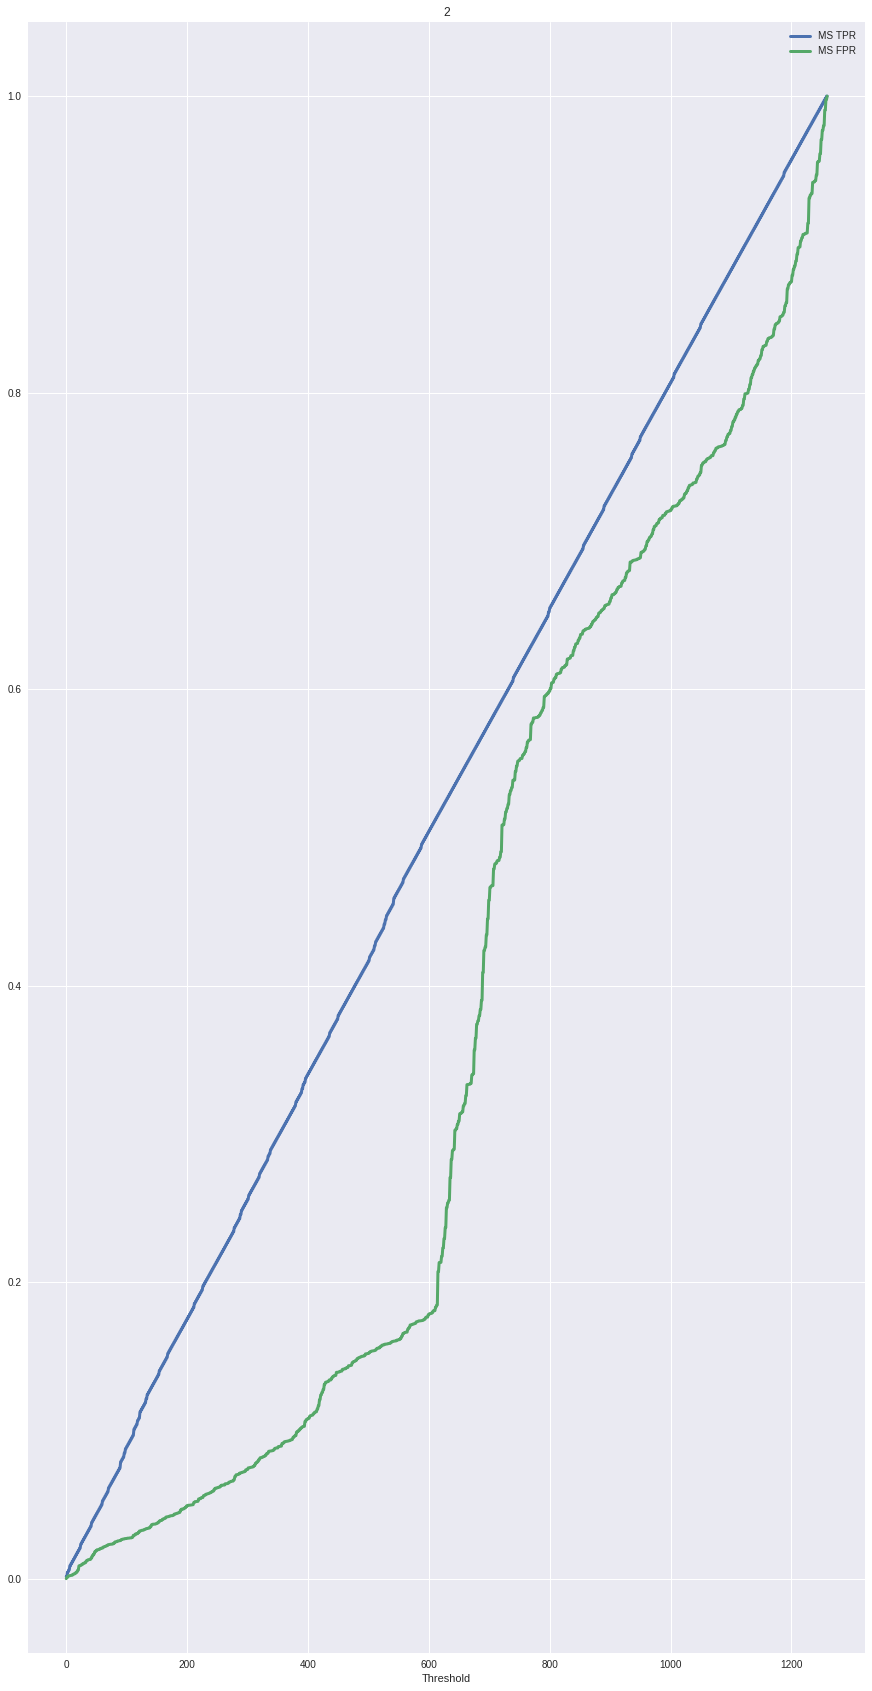

Good lumis: 16251
Bad lumis: 117
Ratio of bad lumis: 0.00714809384164


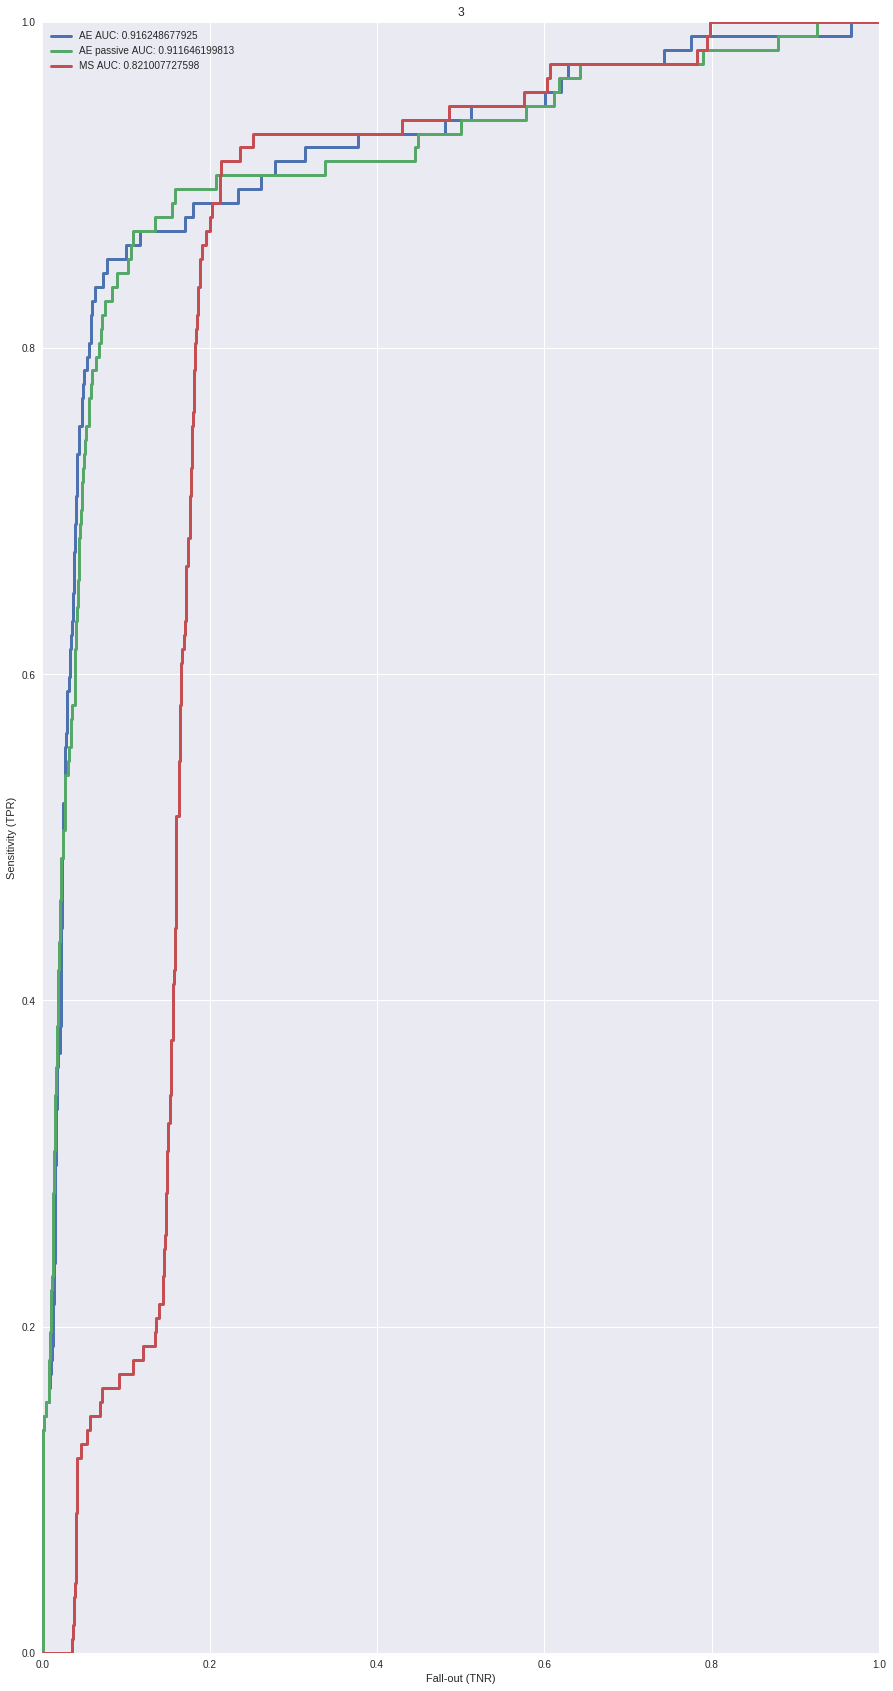

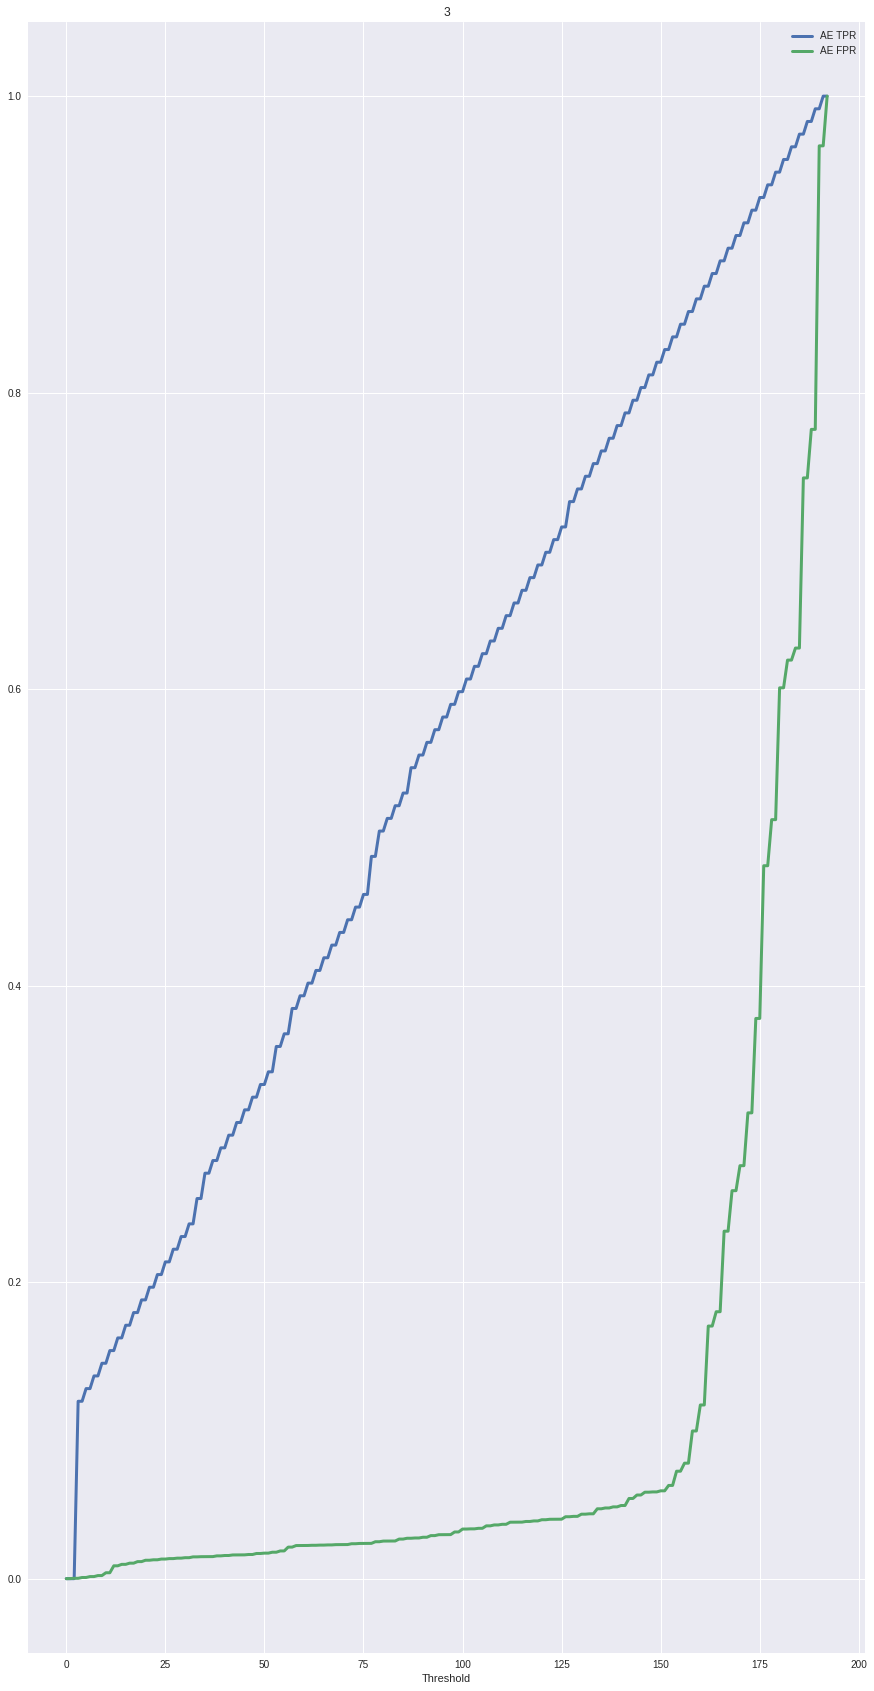

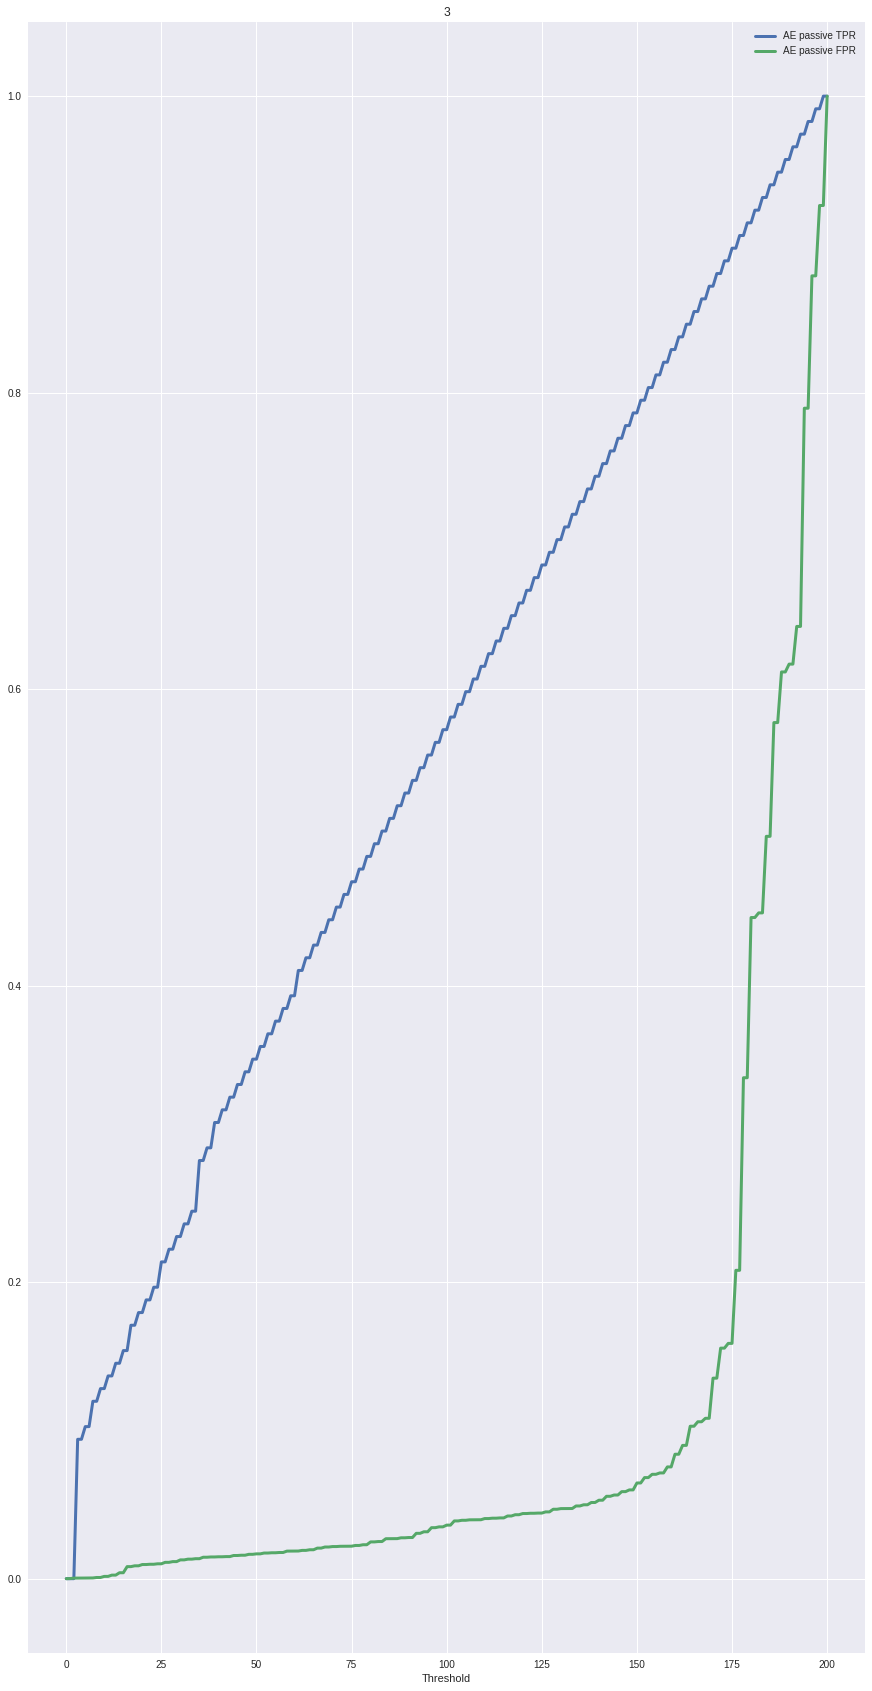

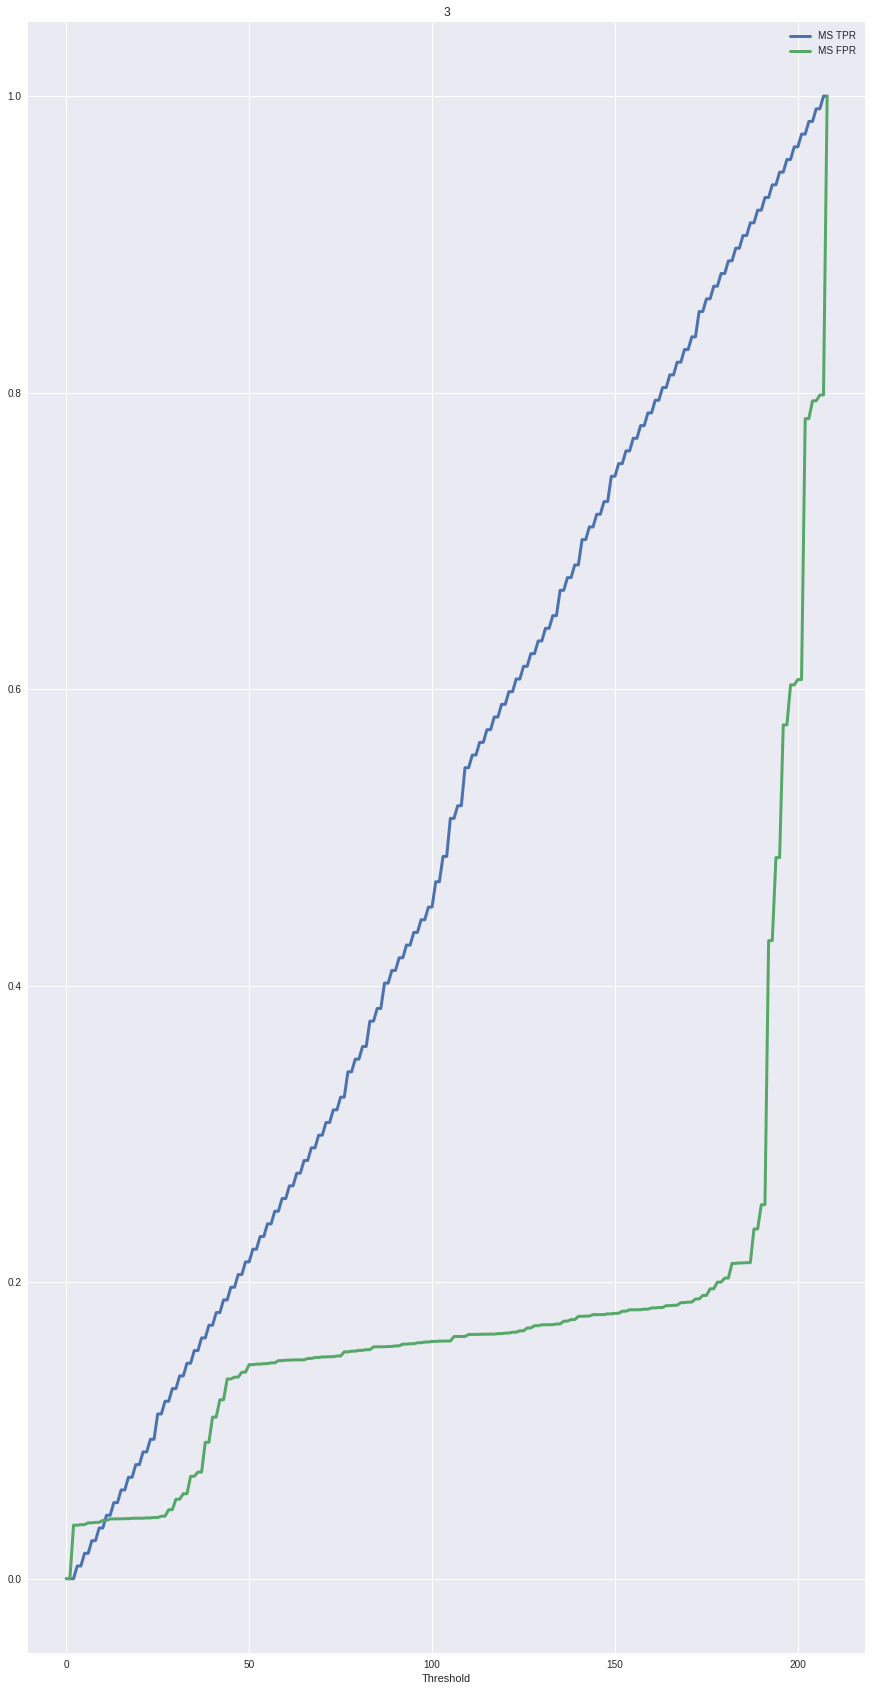

Good lumis: 16258
Bad lumis: 111
Ratio of bad lumis: 0.00678111063596


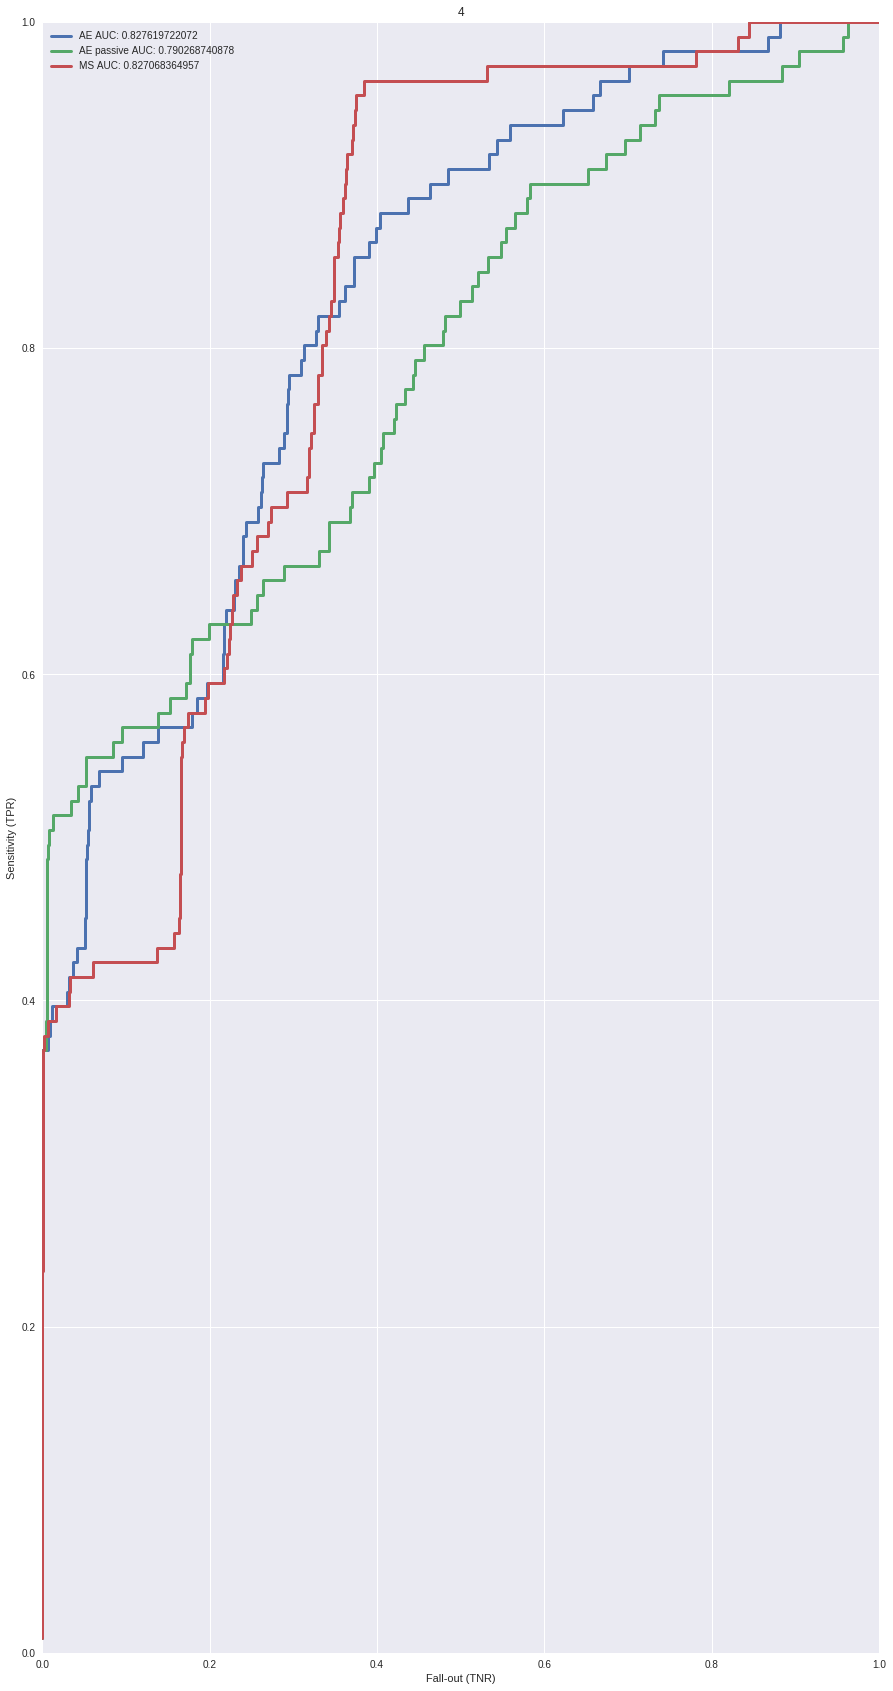

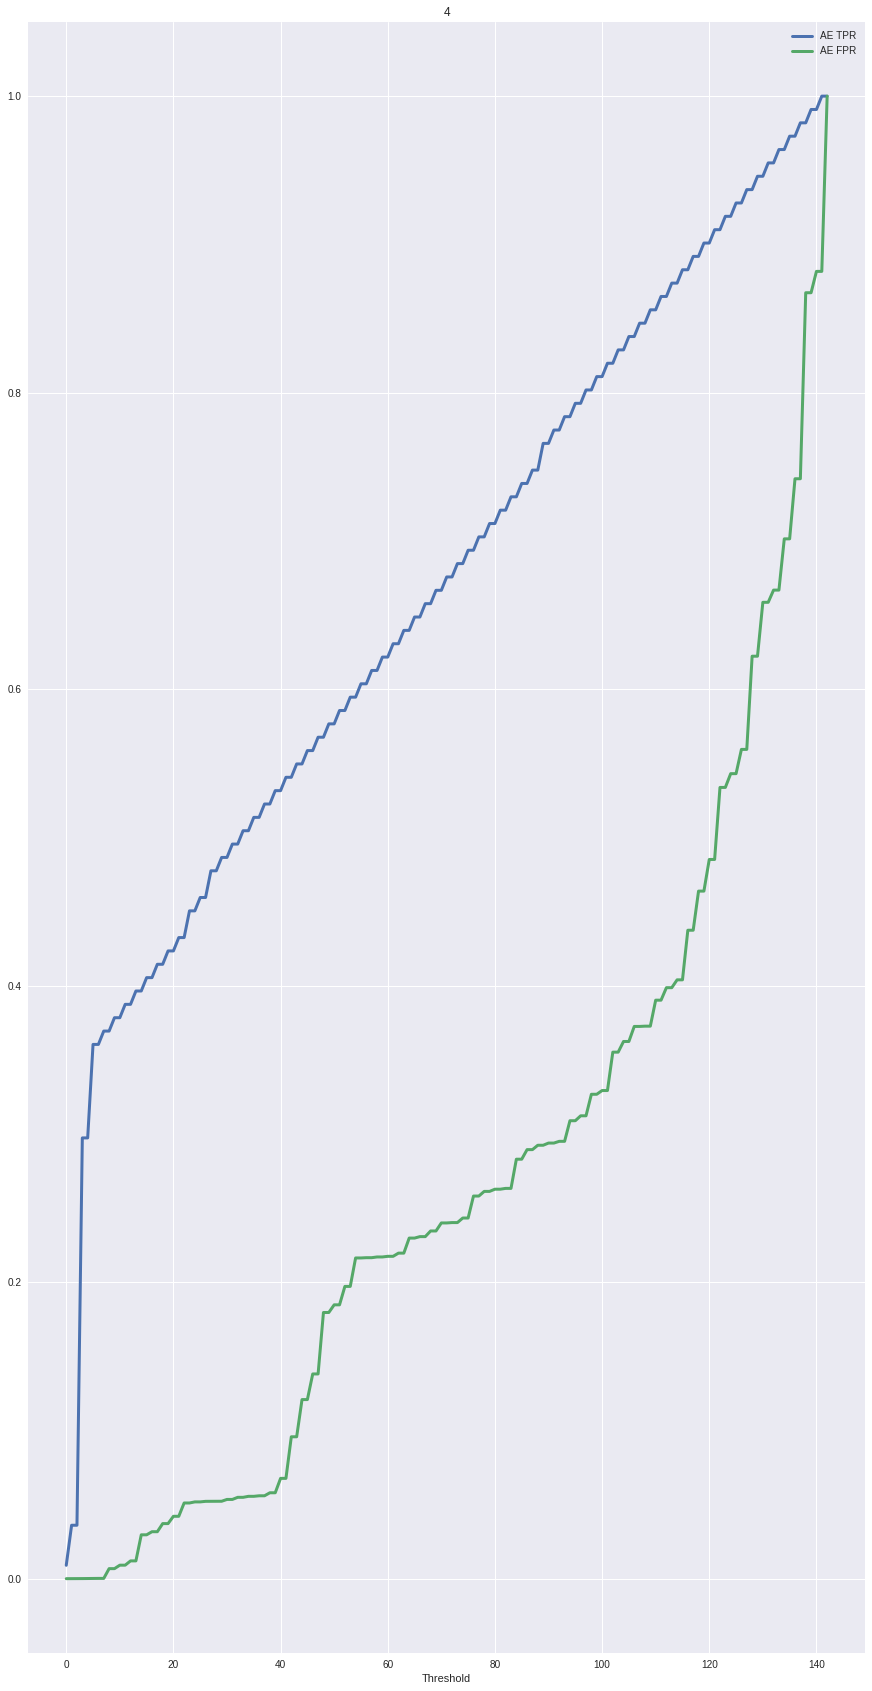

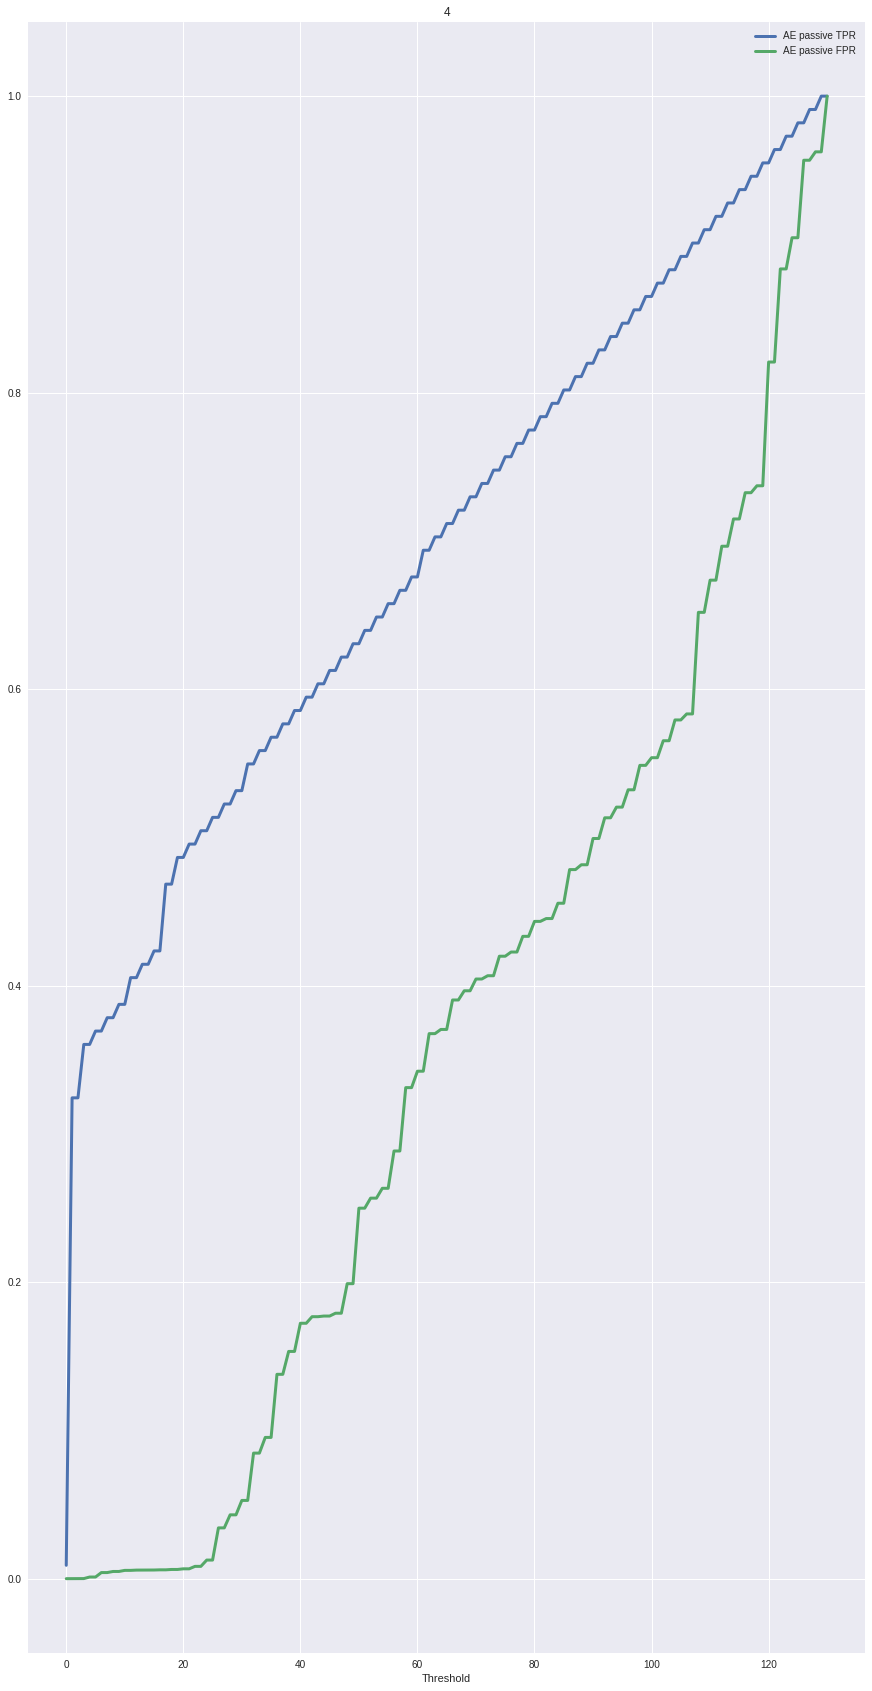

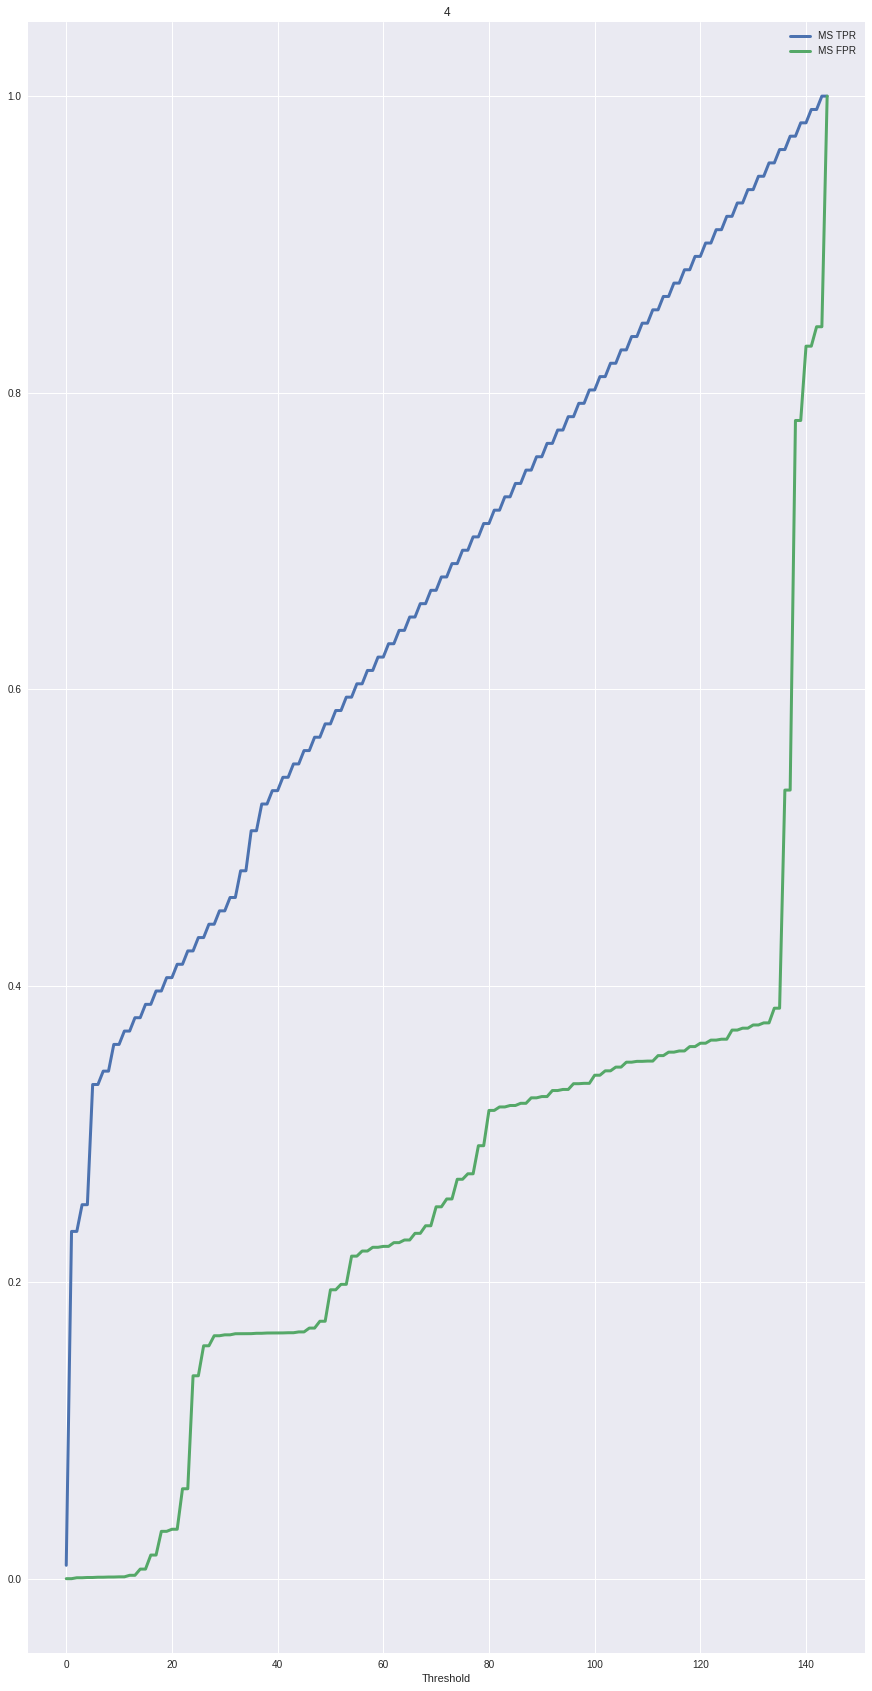

Good lumis: 16248
Bad lumis: 120
Ratio of bad lumis: 0.00733137829912


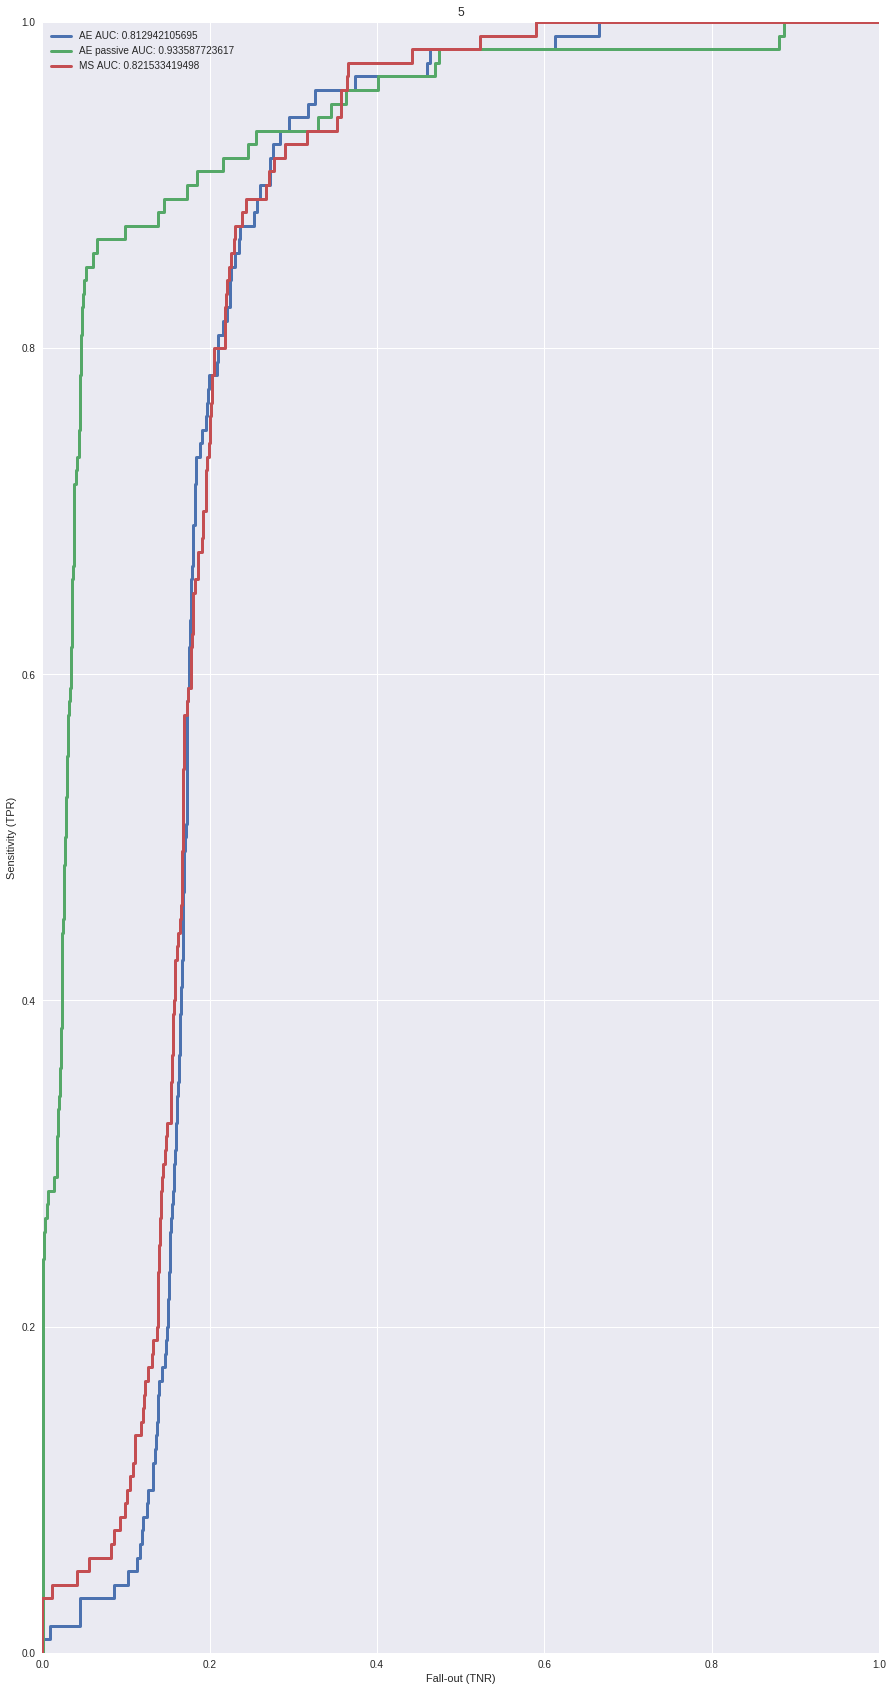

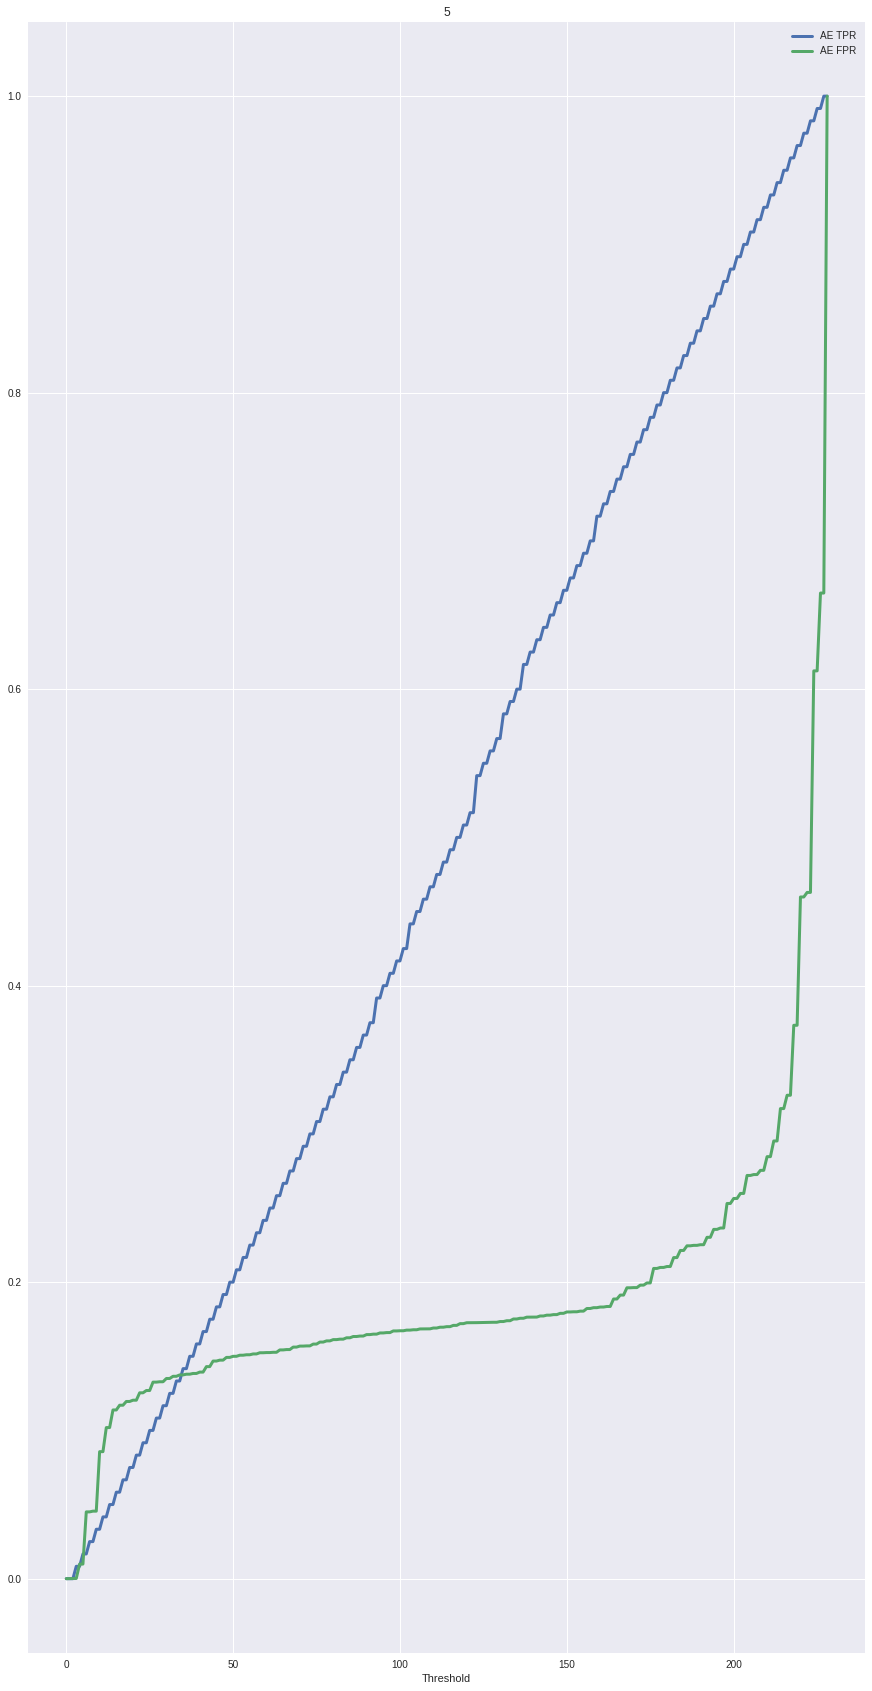

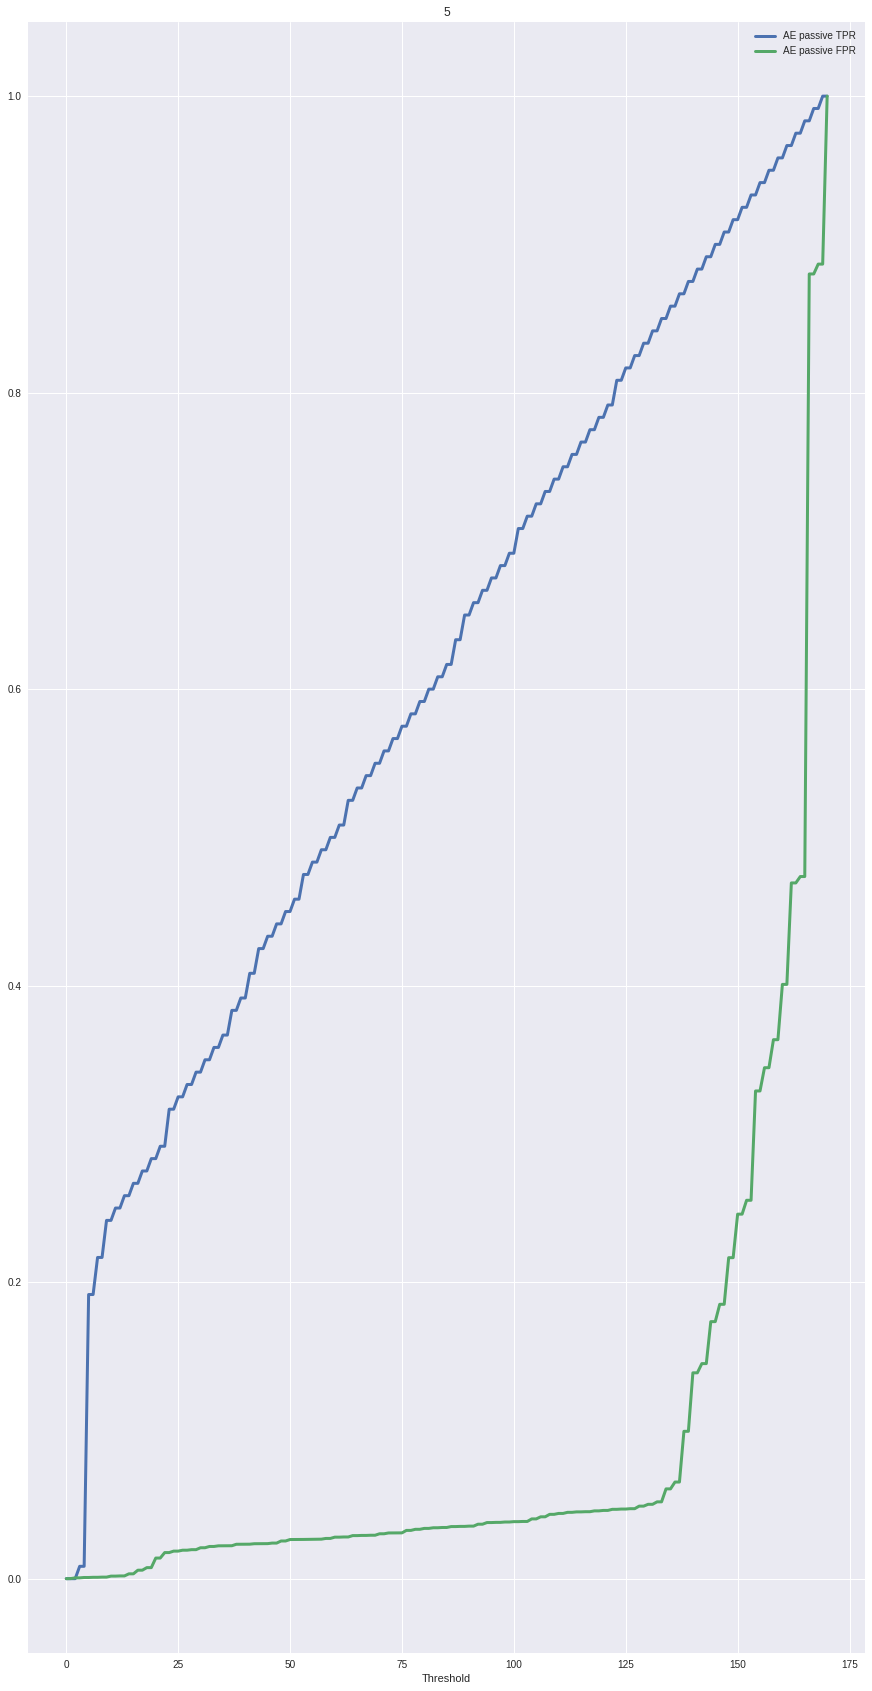

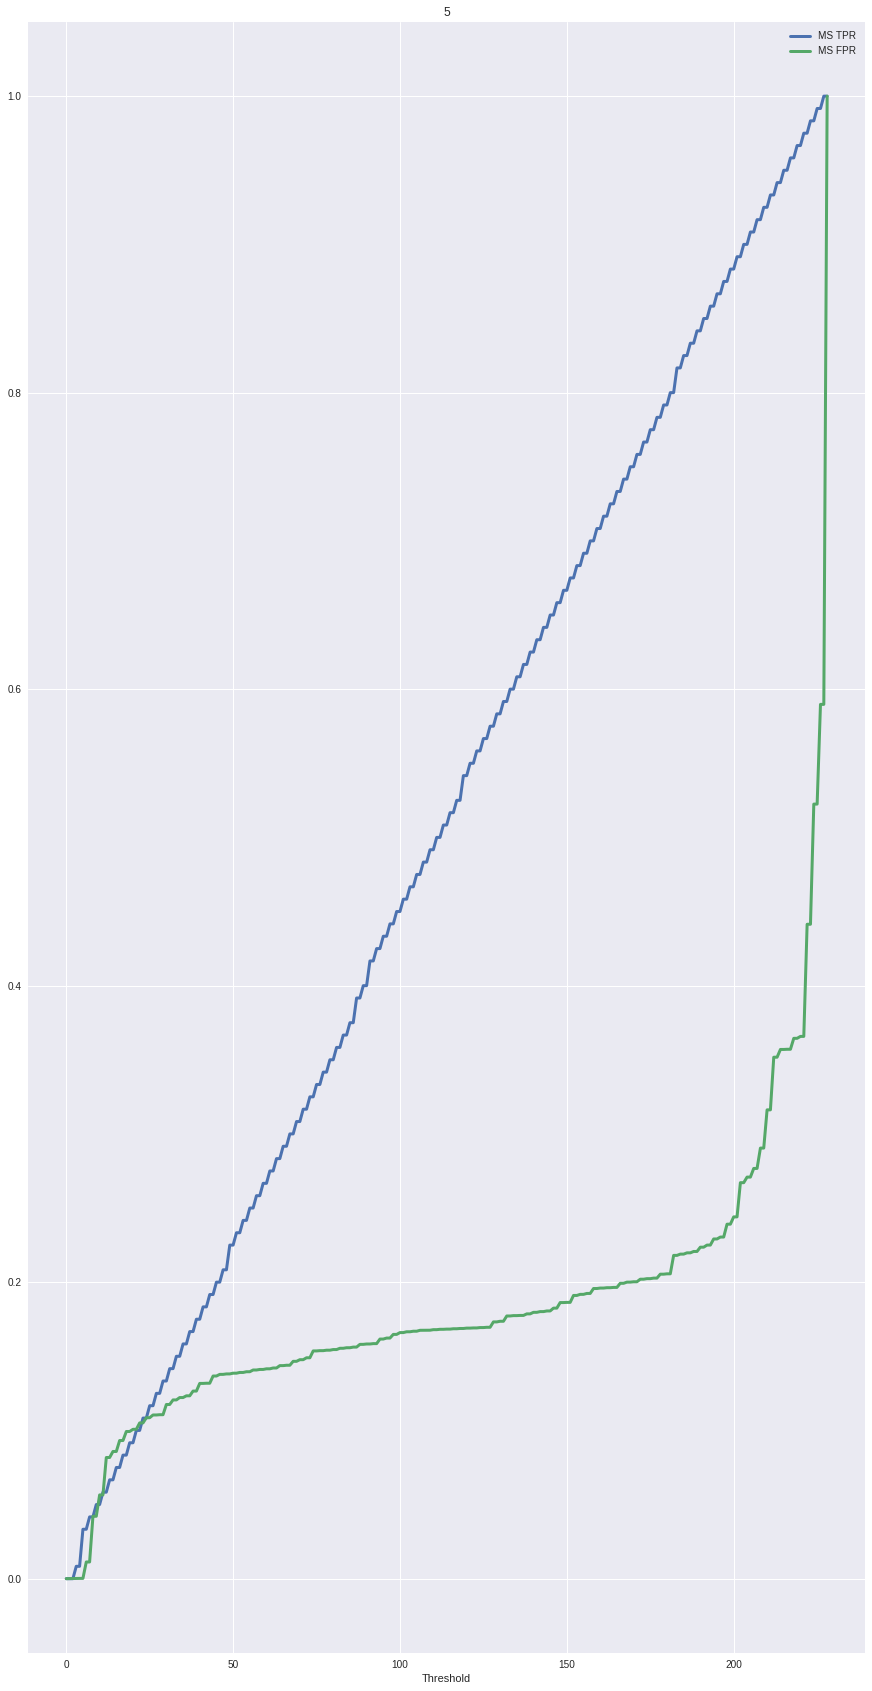

Good lumis: 15761
Bad lumis: 608
Ratio of bad lumis: 0.0371433807807


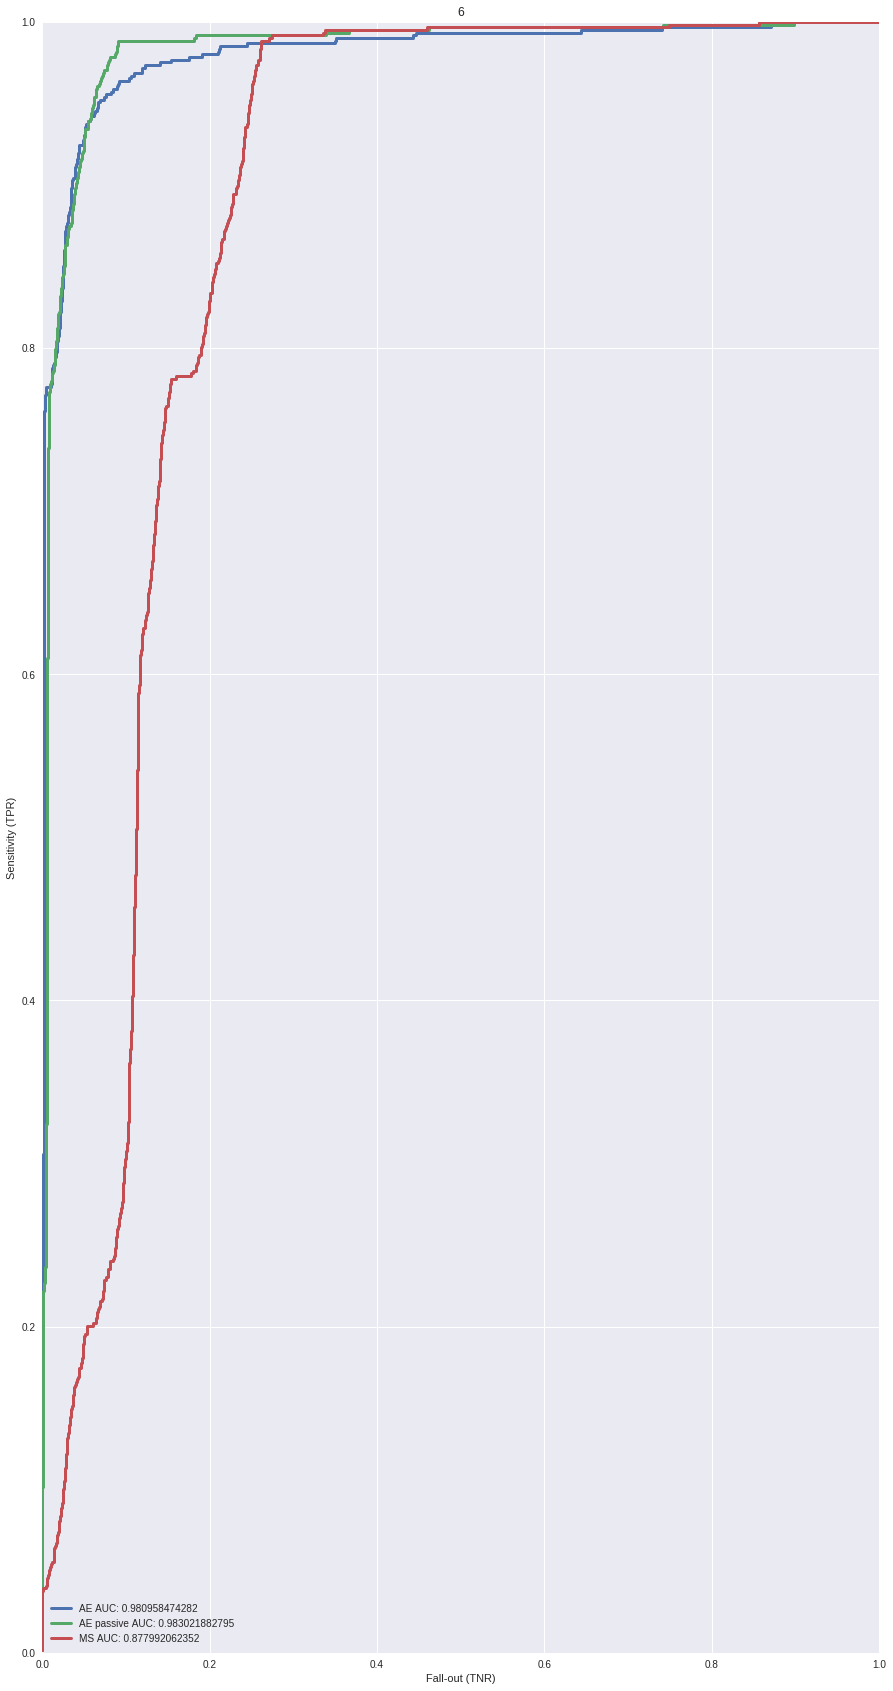

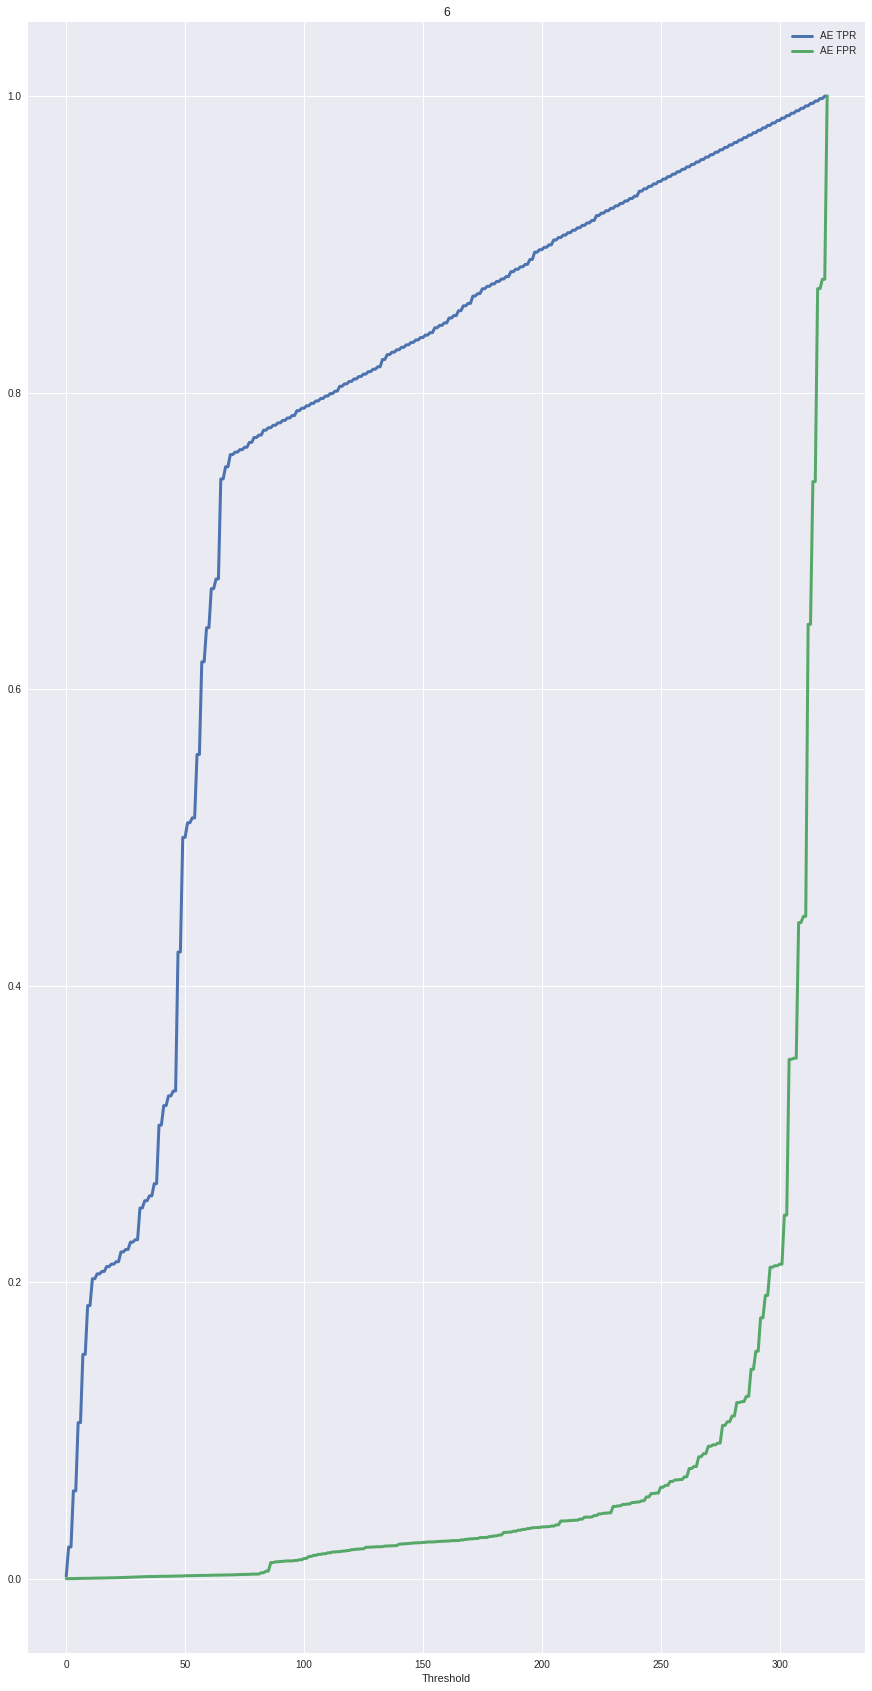

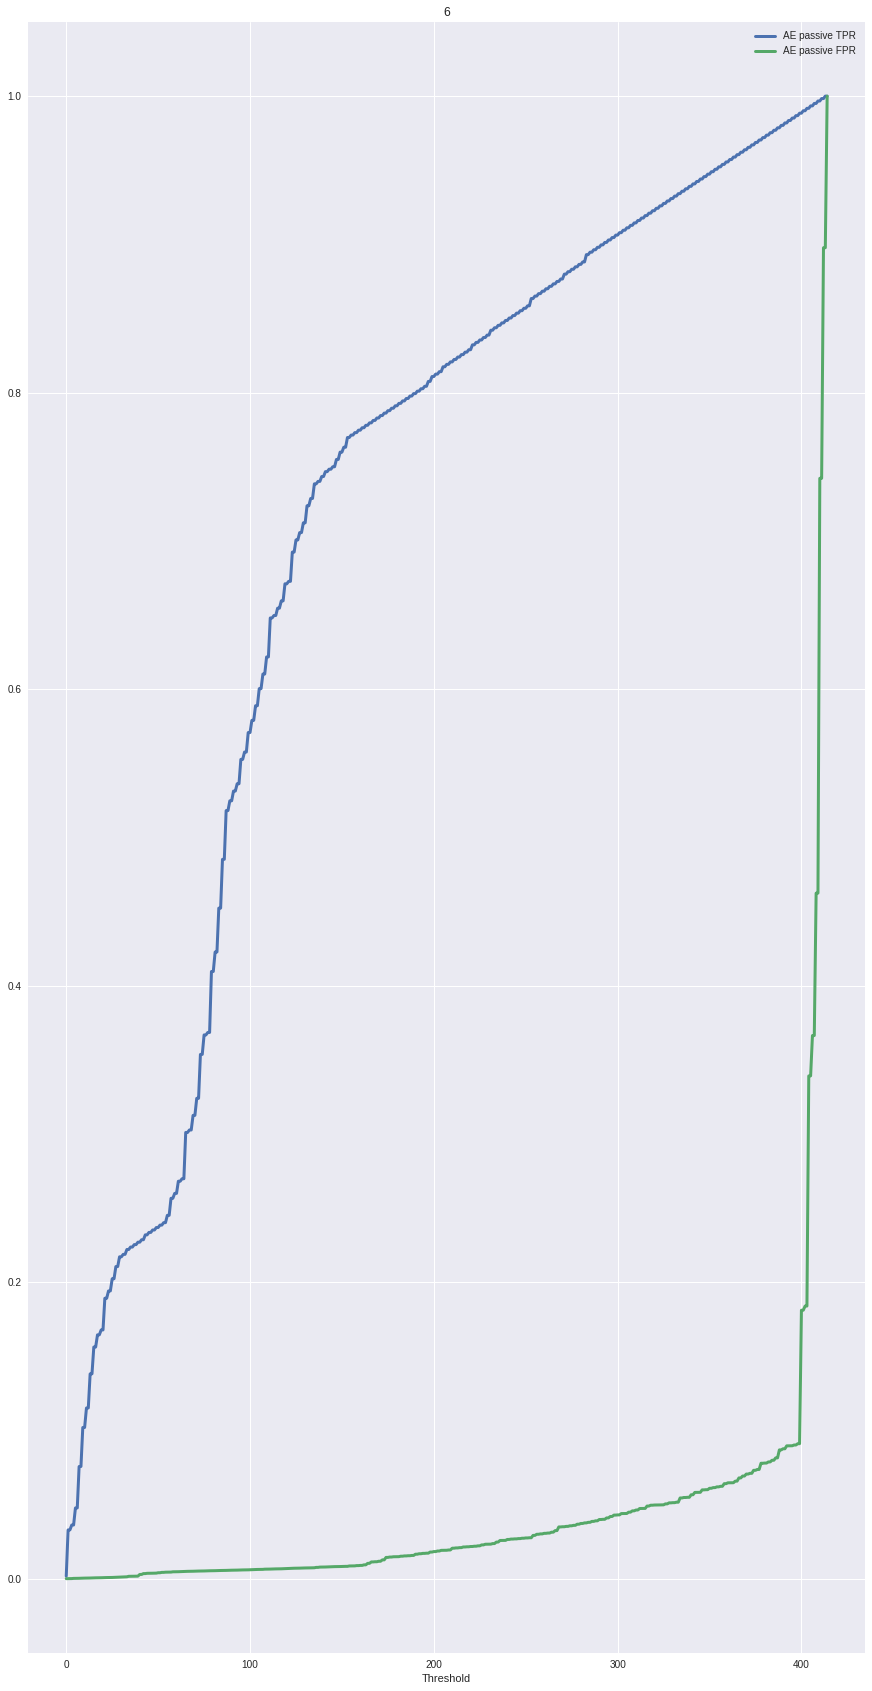

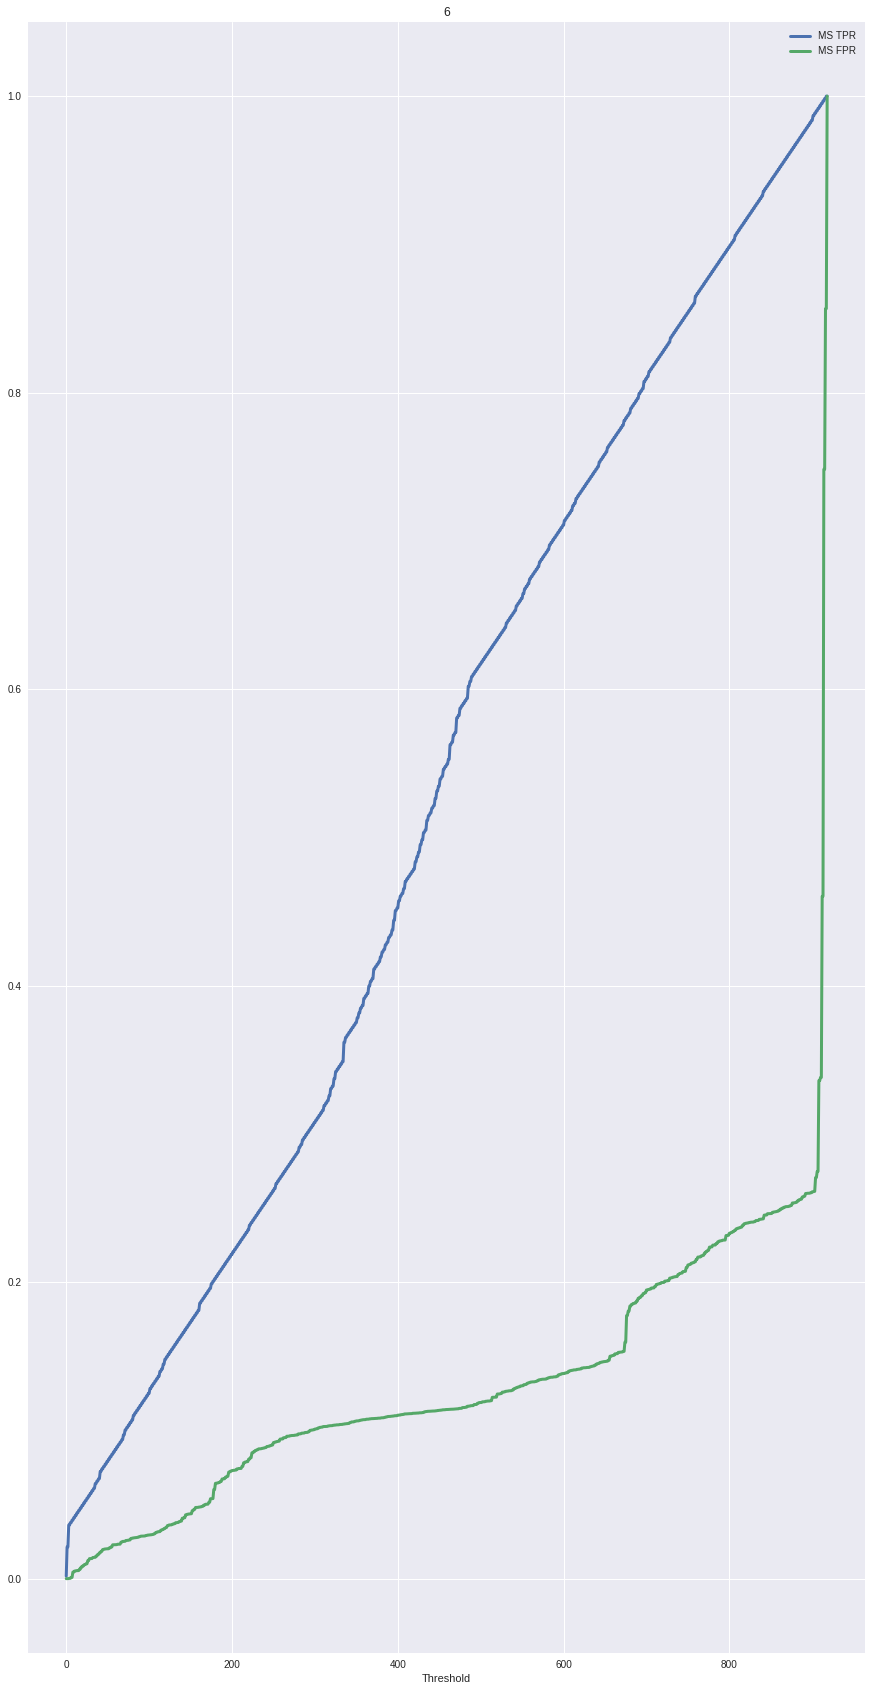

Good lumis: 15754
Bad lumis: 614
Ratio of bad lumis: 0.0375122189638


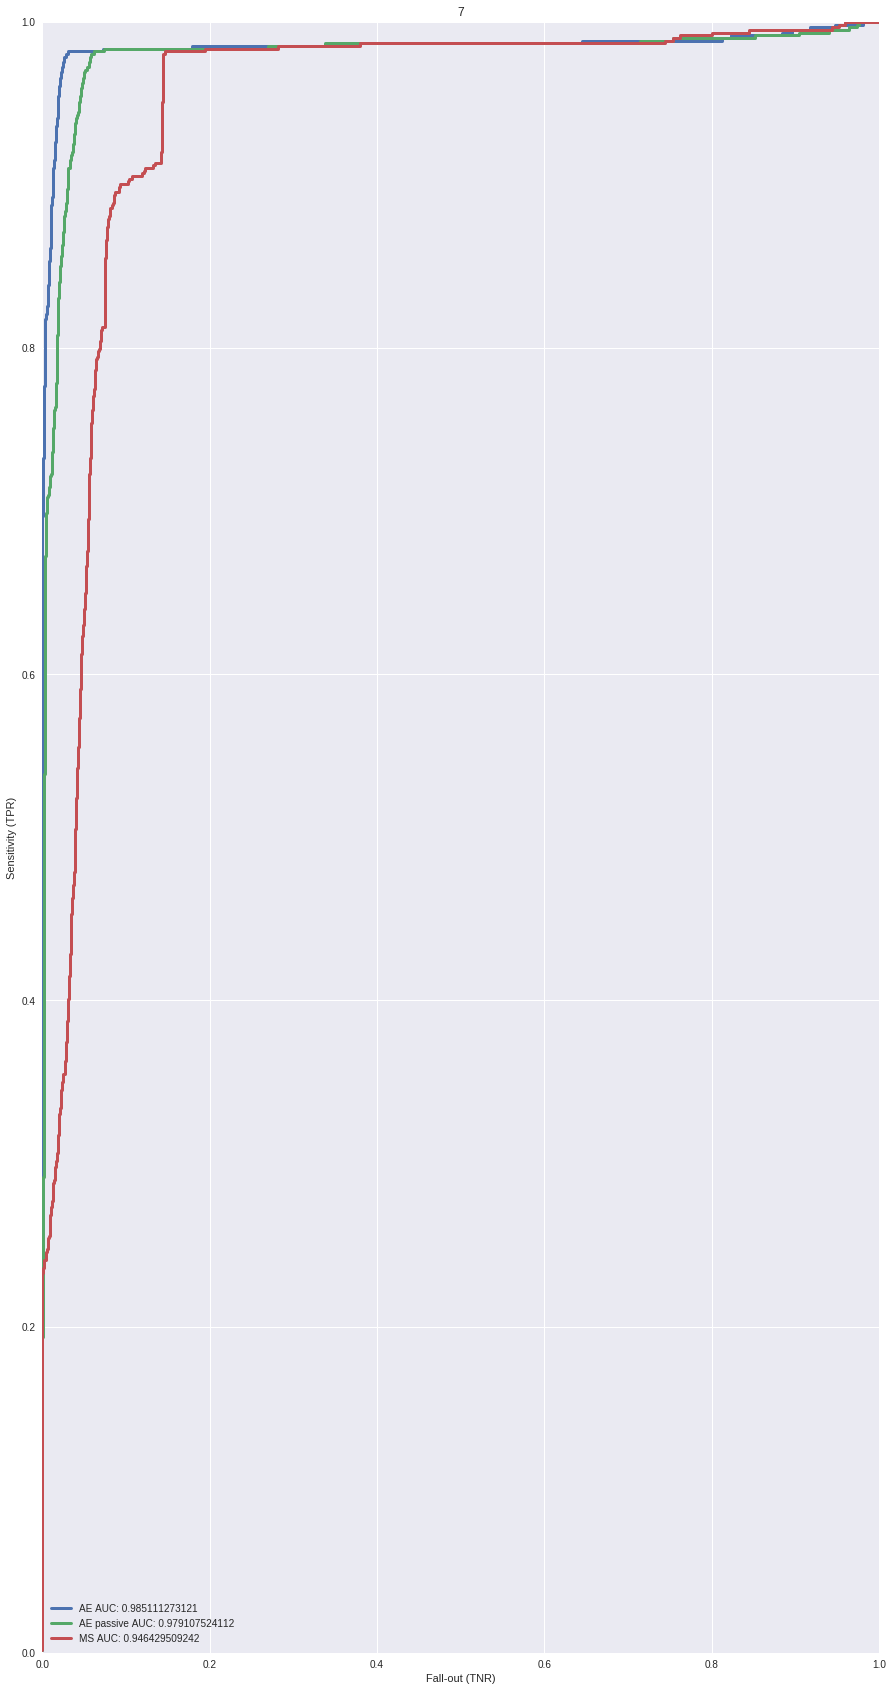

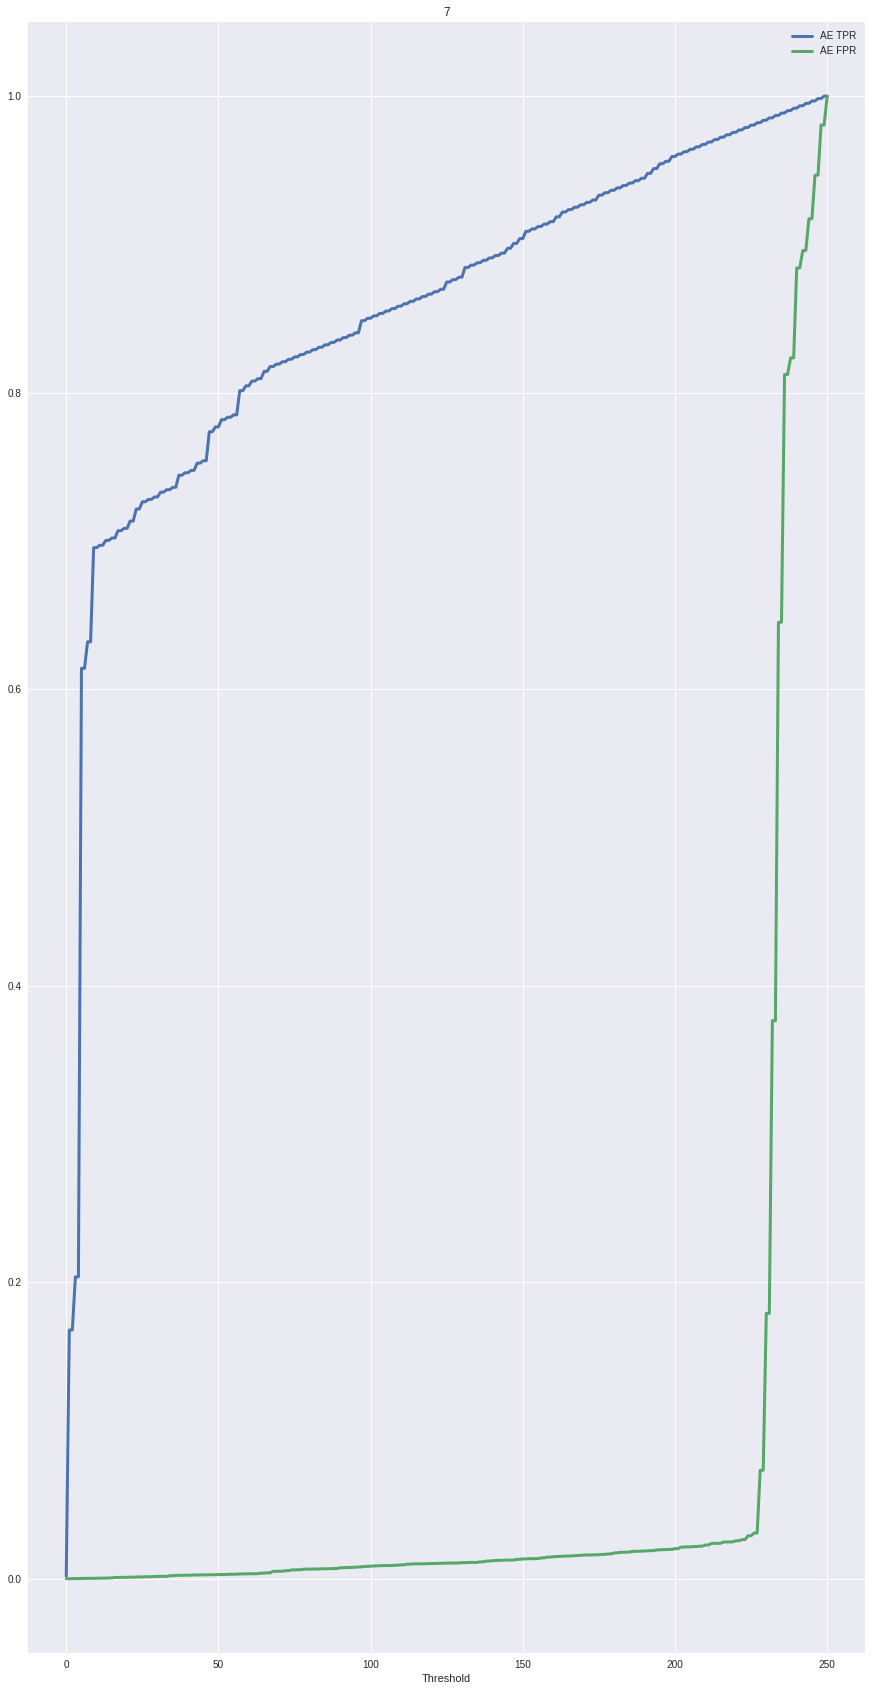

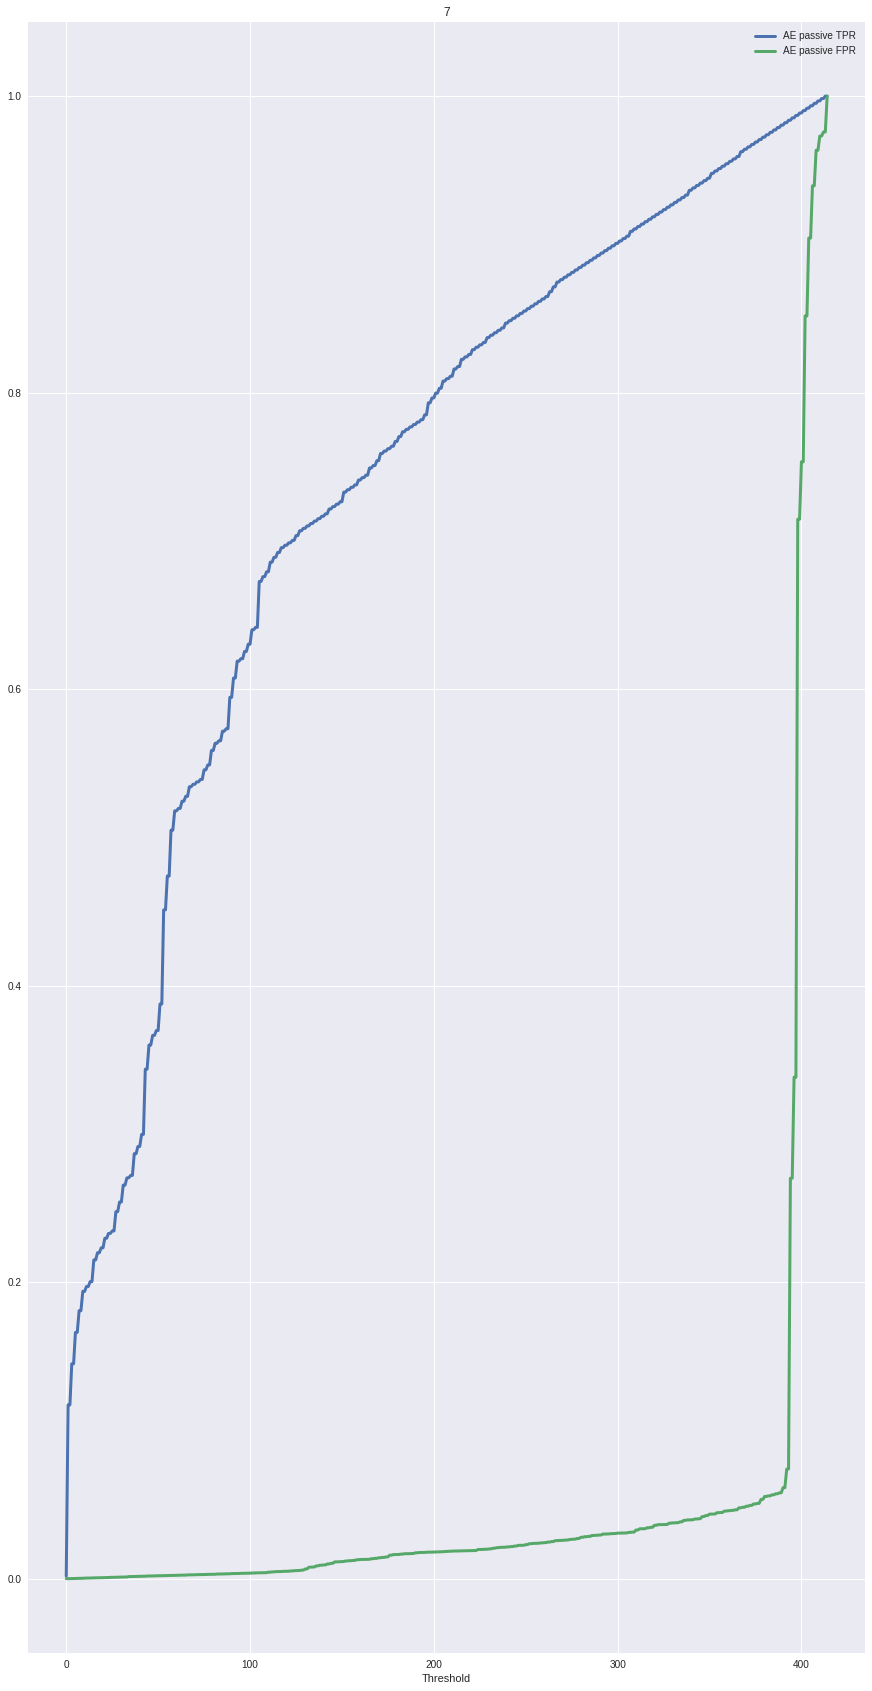

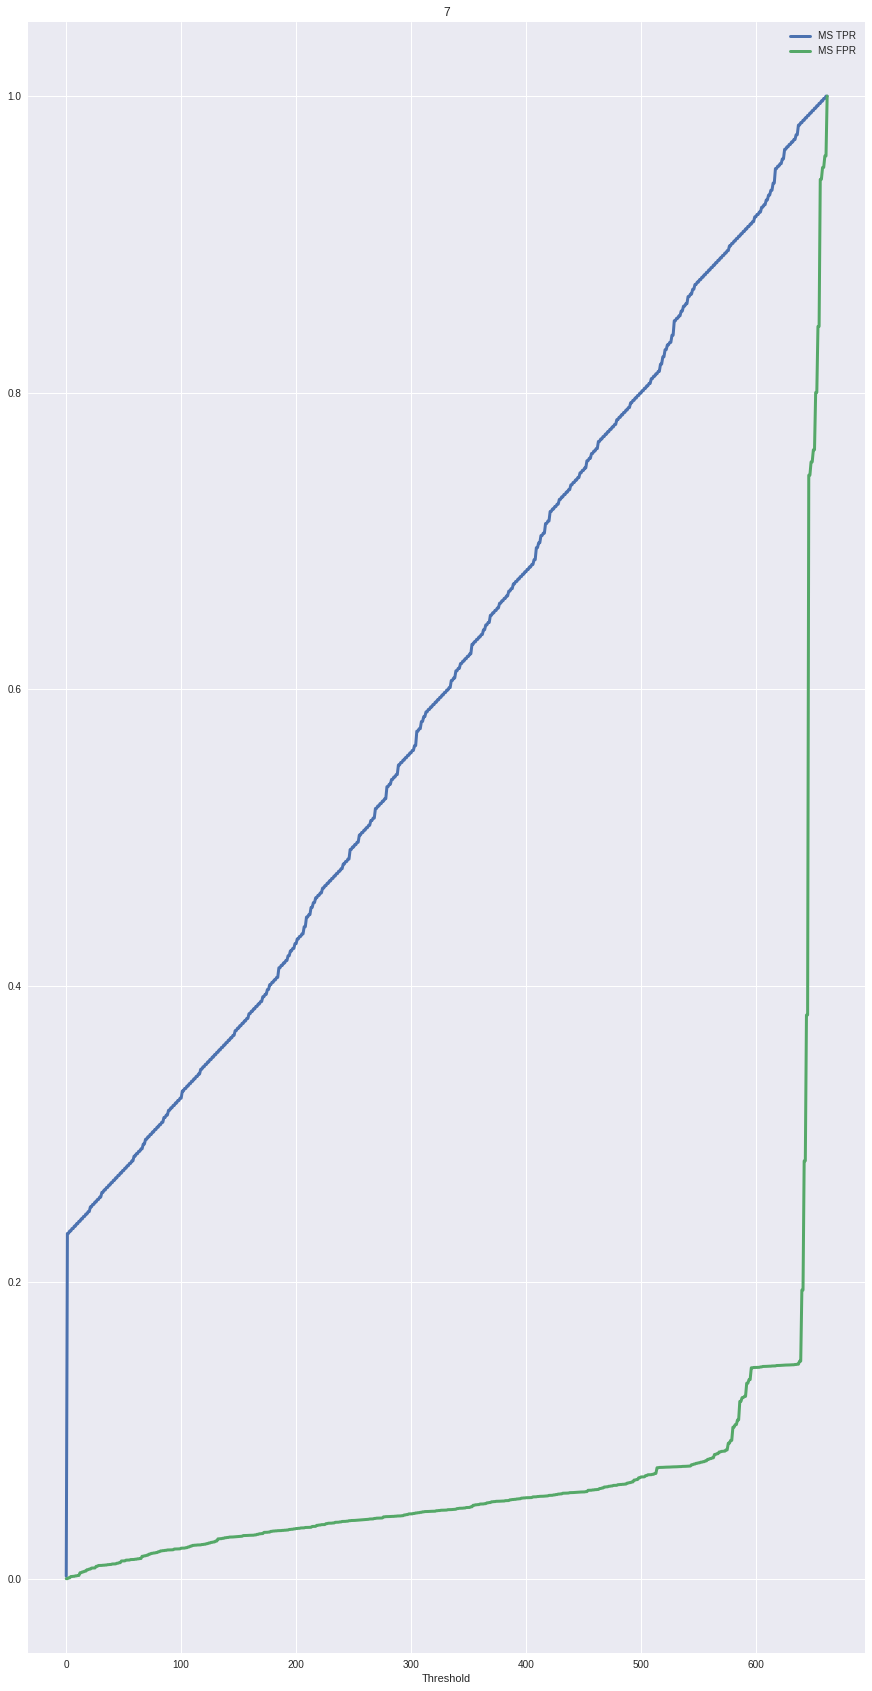

Good lumis: 16322
Bad lumis: 47
Ratio of bad lumis: 0.00287128108009


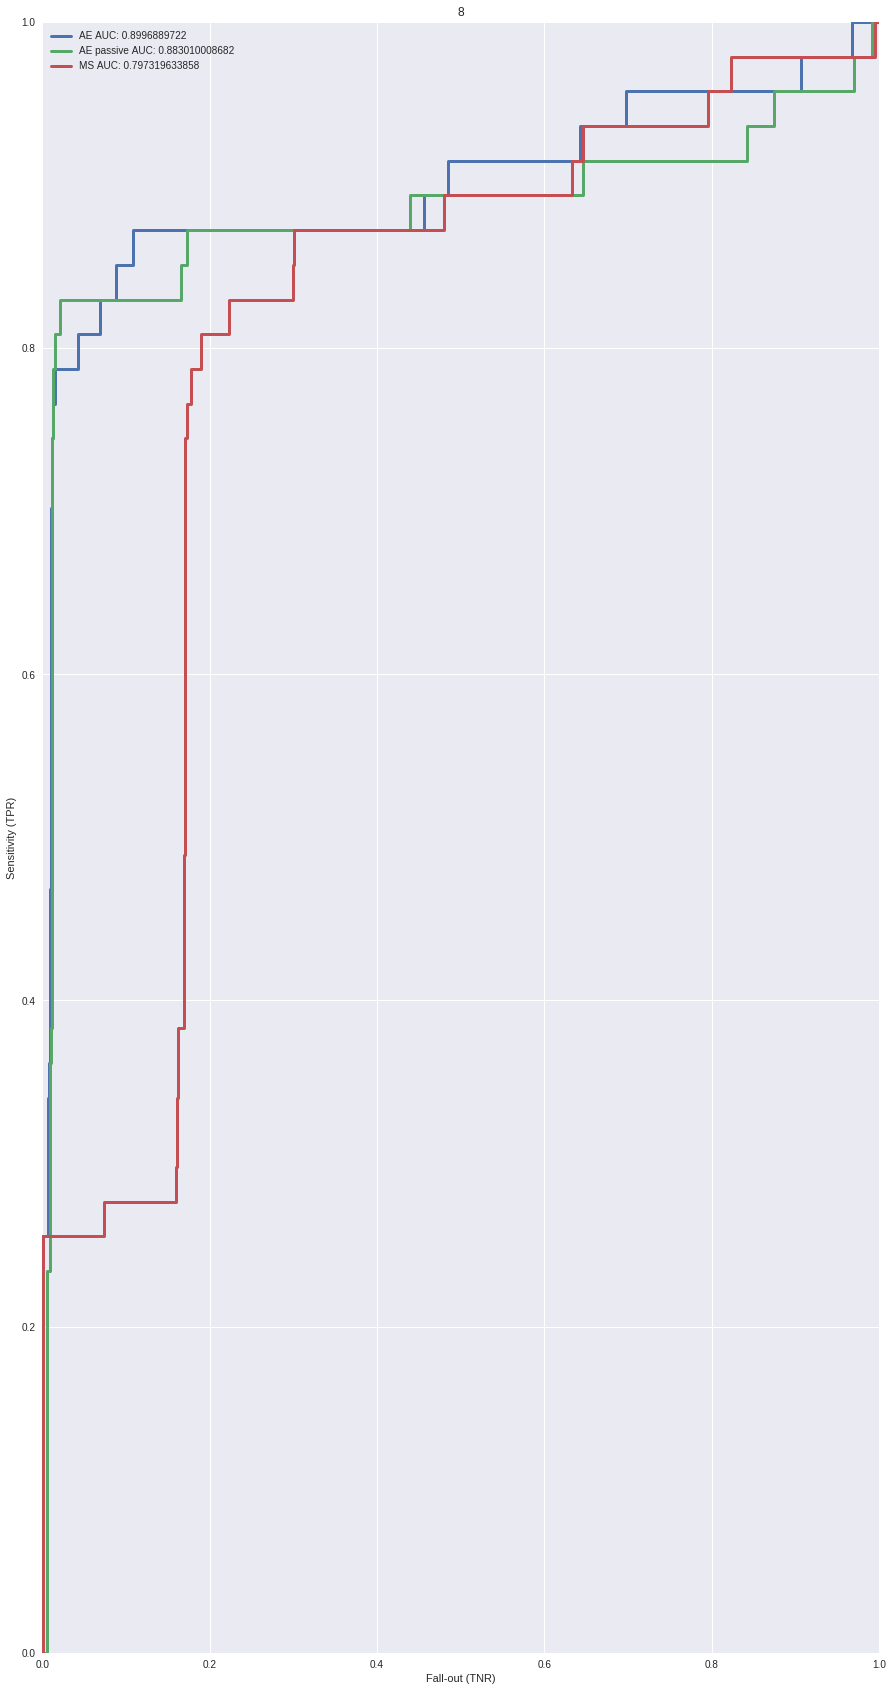

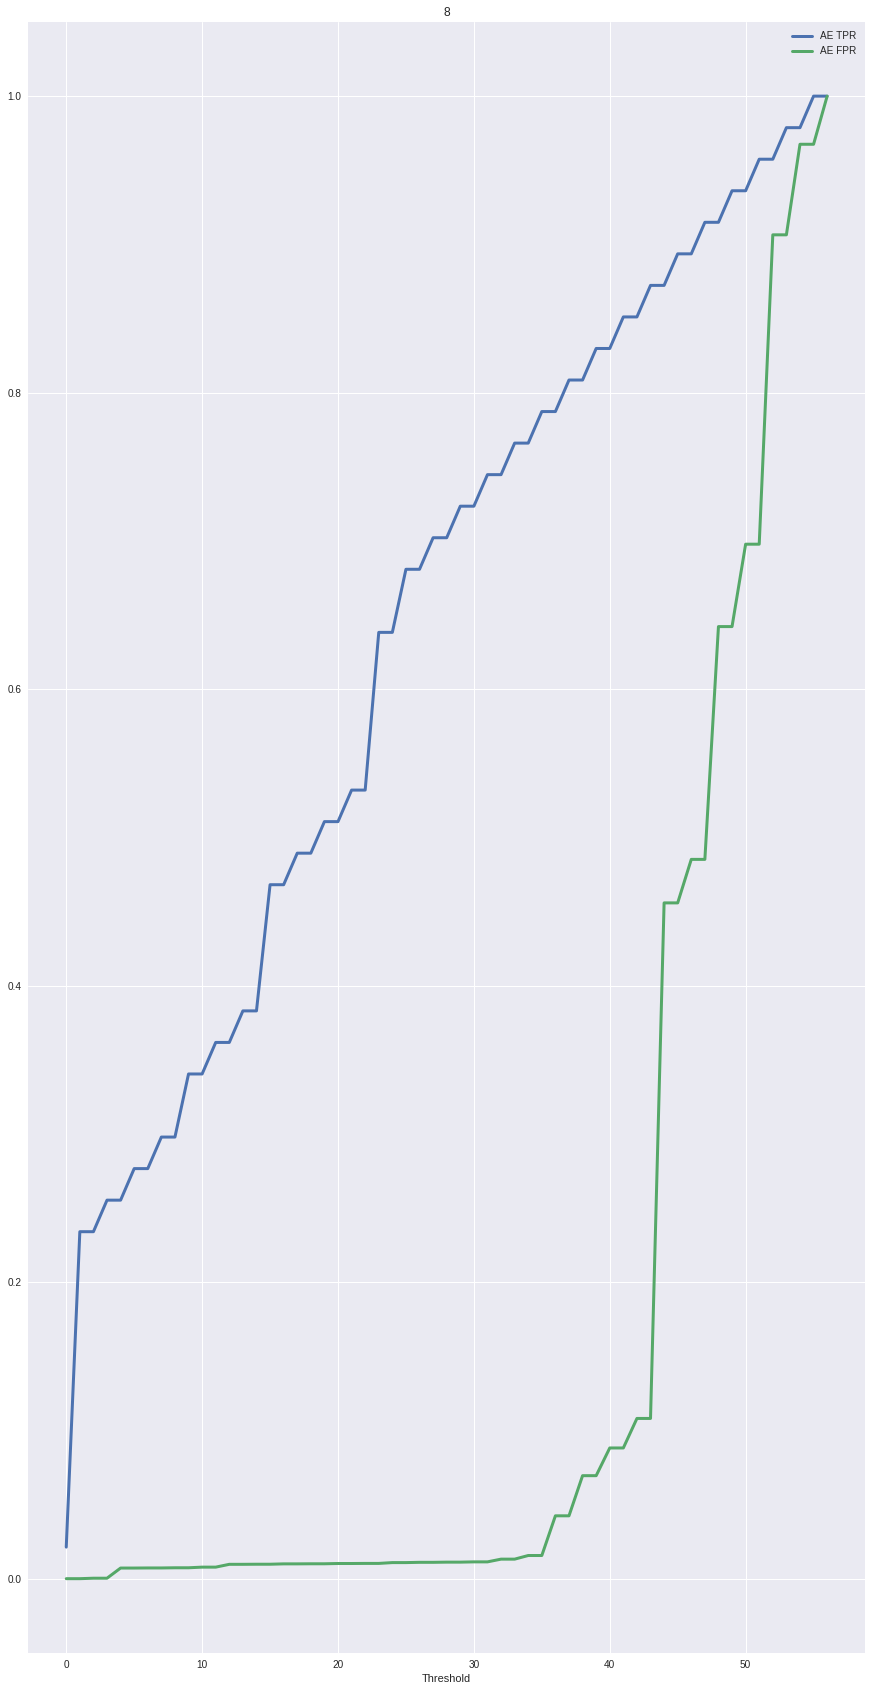

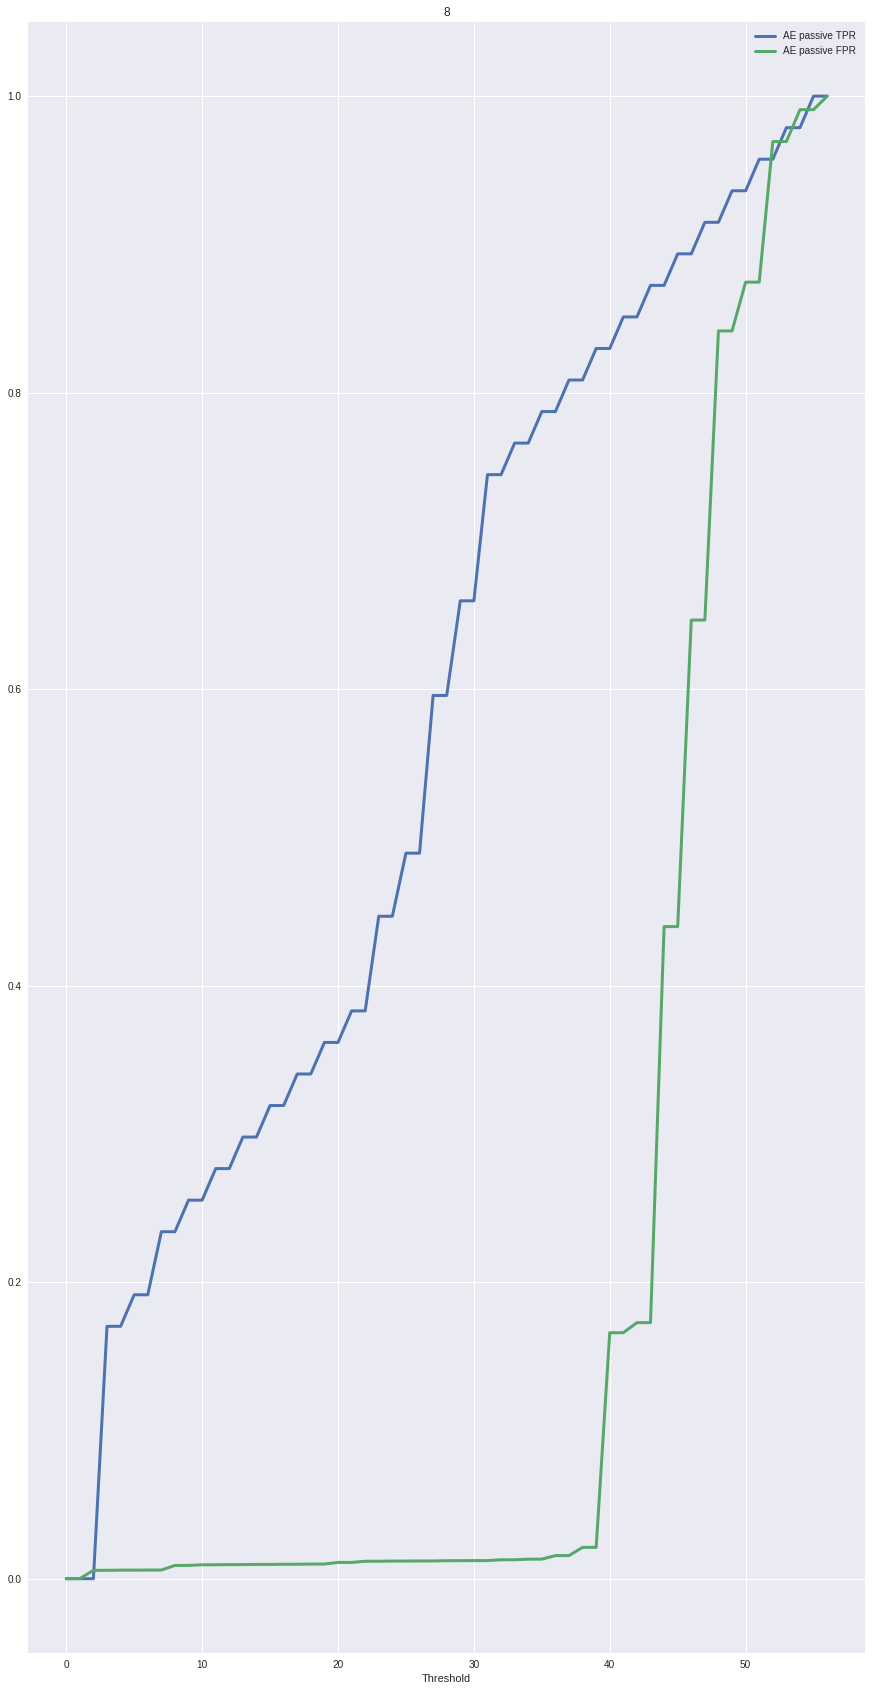

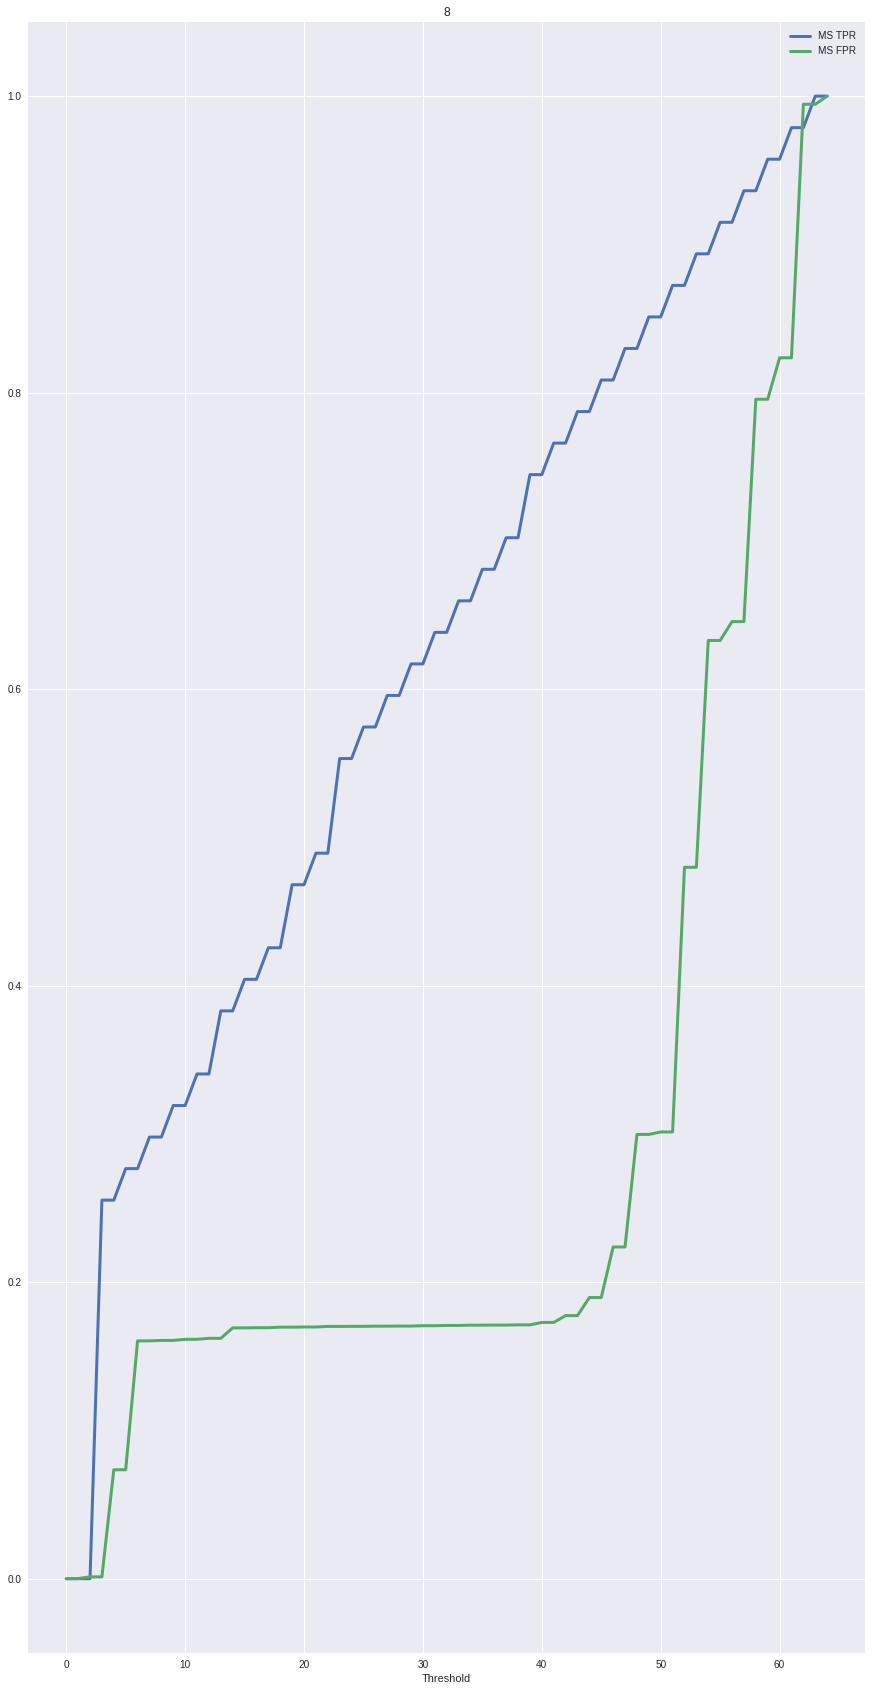

Mean AE score: 0.870190985276
Mean AE passive score: 0.879004225078
Mean MS score: 0.807339569413


In [13]:
ae_roc_auc = []
ae_base_roc_auc = []
ms_roc_auc = []
# rf_roc_auc = []
for i in range(9):
    print("Good lumis:", inliers[i])
    print("Bad lumis:", outliers[i])
    print("Ratio of bad lumis:", outliers[i]/len(true_labels[i]))
    ae_roc_auc.append(roc_auc_score(true_labels[i], ae_scores[i]))
    ms_roc_auc.append(roc_auc_score(true_labels[i], ms_scores[i]))
    ae_base_roc_auc.append(roc_auc_score(true_labels[i], ae_base_scores[i]))
#     rf_roc_auc.append(roc_auc_score(true_labels[i], rf_scores[i]))
    get_roc_curve(true_labels[i], [ae_scores[i], ae_base_scores[i], ms_scores[i]], names, i)
print("Mean AE score:", np.mean(ae_roc_auc))
print("Mean AE passive score:", np.mean(ae_base_roc_auc))
print("Mean MS score:", np.mean(ms_roc_auc))
# print("Mean RF score:", np.mean(rf_roc_auc))